In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device} for inference')

Using cuda:0 for inference


In [ ]:
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/CleanDisaster_Data.csv")

In [ ]:
data[4000:5000]

,Tweets,Disasterclass,CleanTweets
4000,Keyport Hurricane Sandy Damage,damaged_infrastructure,keyport hurricane sandy damag
4001,This is for my people 🙏🏼\nYou are on my mind ♥...,damaged_infrastructure,this for people you are mind repost everydayir...
4002,You're doing it wrong...\n#sandydamage,damaged_infrastructure,you doing wrong sandydamag
4003,اینجا سرپل ذهاب!!!\nمانور تیم های امدادی سازما...,damaged_infrastructure,rcs earthquake sarpolzahab
4004,آرام بخواب غرب میهن من.\nآرام تر از هر ریشتر ل...,damaged_infrastructure,earthquak
...,...,...,...
4995,I just watched the building across the street ...,damaged_infrastructure,just watched the building across the street co...
4996,#chevy #chevrolet #cruze #chevycruze #wrecked...,damaged_infrastructure,chevy chevrolet cruze chevycruze wrecked wreck...
4997,Hope y'all having a great Easter weekend 🎉and ...,damaged_infrastructure,hope all having great easter weekend and your ...
4998,A little throw back to remember for the rest o...,damaged_infrastructure,little throw back remember for the rest life j...


In [ ]:
len(data)

5831

In [ ]:
data['Disasterclass'].unique()

array(['Non damage', 'human damage', 'flood', 'fires',
       'damaged_infrastructure', 'damaged_nature'], dtype=object)

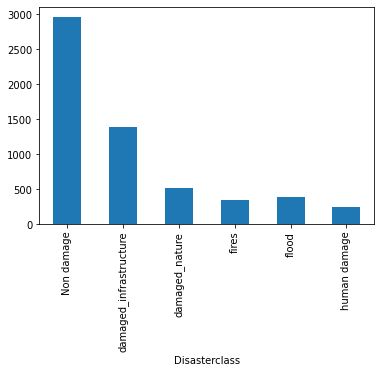

In [ ]:
data.groupby(['Disasterclass']).size().plot.bar()

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 17.1 MB/s 
     |████████████████████████████████| 895 kB 35.6 MB/s 
     |████████████████████████████████| 6.8 MB 39.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
data['CleanTweets'].iloc[4604]

nan

In [ ]:
data['CleanTweets'].dropna(inplace=True)
data = data[data['CleanTweets'].notna()]

In [ ]:
for text in range(len(data['CleanTweets'])):
   if isinstance(data["CleanTweets"].iloc[text],float):
       print(text,type(data["CleanTweets"].iloc[text]))
       print(data["CleanTweets"].iloc[text])

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
labels = {'Non damage':0,
          'human damage':1,
          'flood':2,
          'fires':3,
          'damaged_infrastructure':4,
          'damaged_nature':5
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Disasterclass']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['CleanTweets']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
df=Dataset(data)

In [ ]:

np.random.seed(112)
df_train, df_val, df_test = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(data)), int(.9*len(data))])

print(len(df_train),len(df_val), len(df_test))

4645 581 581


In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 6)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
"""As you can see from the code above, BERT model outputs two variables:
The first variable, which we named _ in the code above, contains the embedding vectors of all of the tokens in a sequence.
The second variable, which we named pooled_output, contains the embedding vector of [CLS] token. For a text classification task, it is enough to use this embedding as an input for our classifier."""

'As you can see from the code above, BERT model outputs two variables:\nThe first variable, which we named _ in the code above, contains the embedding vectors of all of the tokens in a sequence.\nThe second variable, which we named pooled_output, contains the embedding vector of [CLS] token. For a text classification task, it is enough to use this embedding as an input for our classifier.'

In [ ]:
import torch

In [ ]:
train, val = Dataset(df_train), Dataset(df_val)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)


In [ ]:
from torch.optim import Adam
EPOCHS = 5
model = BertClassifier()
model = model.to(device)
LR = 1e-6              
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)
"""checkpoint = torch.load('/content/drive/MyDrive/MLBert/104.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_num = checkpoint['epoch']
batch_loss = checkpoint['loss']"""
#criterion = criterion.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


"checkpoint = torch.load('/content/drive/MyDrive/MLBert/104.pth')\nmodel.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\nepoch_num = checkpoint['epoch']\nbatch_loss = checkpoint['loss']"

In [ ]:

from tqdm import tqdm

def train(model, train_dataloader, val_dataloader,epochs):
    train_loss=[]
    train_acc=[]
    val_loss=[]
    val_acc=[]
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            train_
            torch.save({
            'epoch': epoch_num,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss':batch_loss,
            },'/content/drive/MyDrive/MLBert/'+str(epoch_num+200)+'.pth')
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataloader): .3f} \
                | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} \
                | Val Loss: {total_loss_val / len(val_dataloader): .3f} \
                | Val Accuracy: {total_acc_val / len(val_dataloader): .3f}')

In [ ]:
train(model,train_dataloader,val_dataloader,EPOCHS)

Ok5


  0%|          | 0/2323 [00:00<?, ?it/s]

Ok7
Ok8
Ok9


  0%|          | 1/2323 [00:00<23:21,  1.66it/s]

Ok7
Ok8
Ok9


  0%|          | 2/2323 [00:01<20:49,  1.86it/s]

Ok7
Ok8
Ok9


  0%|          | 3/2323 [00:01<19:31,  1.98it/s]

Ok7
Ok8
Ok9


  0%|          | 4/2323 [00:02<19:22,  2.00it/s]

Ok7
Ok8
Ok9


  0%|          | 5/2323 [00:02<19:21,  2.00it/s]

Ok7
Ok8
Ok9


  0%|          | 6/2323 [00:03<19:12,  2.01it/s]

Ok7
Ok8
Ok9


  0%|          | 7/2323 [00:03<18:53,  2.04it/s]

Ok7
Ok8
Ok9


  0%|          | 8/2323 [00:03<18:32,  2.08it/s]

Ok7
Ok8
Ok9


  0%|          | 9/2323 [00:04<18:27,  2.09it/s]

Ok7
Ok8
Ok9


  0%|          | 10/2323 [00:04<18:22,  2.10it/s]

Ok7
Ok8
Ok9


  0%|          | 11/2323 [00:05<18:14,  2.11it/s]

Ok7
Ok8
Ok9


  1%|          | 12/2323 [00:05<18:08,  2.12it/s]

Ok7
Ok8
Ok9


  1%|          | 13/2323 [00:06<18:07,  2.12it/s]

Ok7
Ok8
Ok9


  1%|          | 14/2323 [00:06<18:08,  2.12it/s]

Ok7
Ok8
Ok9


  1%|          | 15/2323 [00:07<17:52,  2.15it/s]

Ok7
Ok8
Ok9


  1%|          | 16/2323 [00:07<17:40,  2.18it/s]

Ok7
Ok8
Ok9


  1%|          | 17/2323 [00:08<17:32,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 18/2323 [00:08<17:24,  2.21it/s]

Ok7
Ok8
Ok9


  1%|          | 19/2323 [00:09<17:24,  2.21it/s]

Ok7
Ok8
Ok9


  1%|          | 20/2323 [00:09<17:25,  2.20it/s]

Ok7
Ok8
Ok9


  1%|          | 21/2323 [00:09<17:22,  2.21it/s]

Ok7
Ok8
Ok9


  1%|          | 22/2323 [00:10<17:22,  2.21it/s]

Ok7
Ok8
Ok9


  1%|          | 23/2323 [00:10<17:21,  2.21it/s]

Ok7
Ok8
Ok9


  1%|          | 24/2323 [00:11<17:19,  2.21it/s]

Ok7
Ok8
Ok9


  1%|          | 25/2323 [00:11<17:15,  2.22it/s]

Ok7
Ok8
Ok9


  1%|          | 26/2323 [00:12<17:14,  2.22it/s]

Ok7
Ok8
Ok9


  1%|          | 27/2323 [00:12<17:19,  2.21it/s]

Ok7
Ok8
Ok9


  1%|          | 28/2323 [00:13<17:17,  2.21it/s]

Ok7
Ok8
Ok9


  1%|          | 29/2323 [00:13<17:13,  2.22it/s]

Ok7
Ok8
Ok9


  1%|▏         | 30/2323 [00:14<17:11,  2.22it/s]

Ok7
Ok8
Ok9


  1%|▏         | 31/2323 [00:14<17:13,  2.22it/s]

Ok7
Ok8
Ok9


  1%|▏         | 32/2323 [00:14<17:14,  2.22it/s]

Ok7
Ok8
Ok9


  1%|▏         | 33/2323 [00:15<17:15,  2.21it/s]

Ok7
Ok8
Ok9


  1%|▏         | 34/2323 [00:15<17:14,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 35/2323 [00:16<17:12,  2.22it/s]

Ok7
Ok8
Ok9


  2%|▏         | 36/2323 [00:16<17:09,  2.22it/s]

Ok7
Ok8
Ok9


  2%|▏         | 37/2323 [00:17<17:12,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 38/2323 [00:17<17:12,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 39/2323 [00:18<17:12,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 40/2323 [00:18<17:13,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 41/2323 [00:18<17:12,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 42/2323 [00:19<17:13,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 43/2323 [00:19<17:09,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 44/2323 [00:20<17:10,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 45/2323 [00:20<17:08,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 46/2323 [00:21<17:08,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 47/2323 [00:21<17:12,  2.20it/s]

Ok7
Ok8
Ok9


  2%|▏         | 48/2323 [00:22<17:14,  2.20it/s]

Ok7
Ok8
Ok9


  2%|▏         | 49/2323 [00:22<17:12,  2.20it/s]

Ok7
Ok8
Ok9


  2%|▏         | 50/2323 [00:23<17:09,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 51/2323 [00:23<17:08,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 52/2323 [00:23<17:09,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 53/2323 [00:24<17:07,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 54/2323 [00:24<17:04,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 55/2323 [00:25<17:00,  2.22it/s]

Ok7
Ok8
Ok9


  2%|▏         | 56/2323 [00:25<17:00,  2.22it/s]

Ok7
Ok8
Ok9


  2%|▏         | 57/2323 [00:26<17:04,  2.21it/s]

Ok7
Ok8
Ok9


  2%|▏         | 58/2323 [00:26<17:06,  2.21it/s]

Ok7
Ok8
Ok9


  3%|▎         | 59/2323 [00:27<17:05,  2.21it/s]

Ok7
Ok8
Ok9


  3%|▎         | 60/2323 [00:27<17:06,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 61/2323 [00:28<17:06,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 62/2323 [00:28<17:06,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 63/2323 [00:28<17:04,  2.21it/s]

Ok7
Ok8
Ok9


  3%|▎         | 64/2323 [00:29<17:06,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 65/2323 [00:29<17:02,  2.21it/s]

Ok7
Ok8
Ok9


  3%|▎         | 66/2323 [00:30<17:05,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 67/2323 [00:30<17:05,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 68/2323 [00:31<17:05,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 69/2323 [00:31<17:04,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 70/2323 [00:32<17:01,  2.21it/s]

Ok7
Ok8
Ok9


  3%|▎         | 71/2323 [00:32<17:02,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 72/2323 [00:33<17:03,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 73/2323 [00:33<17:05,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 74/2323 [00:33<17:02,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 75/2323 [00:34<17:01,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 76/2323 [00:34<16:57,  2.21it/s]

Ok7
Ok8
Ok9


  3%|▎         | 77/2323 [00:35<16:55,  2.21it/s]

Ok7
Ok8
Ok9


  3%|▎         | 78/2323 [00:35<17:01,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 79/2323 [00:36<16:58,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 80/2323 [00:36<16:58,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 81/2323 [00:37<16:55,  2.21it/s]

Ok7
Ok8
Ok9


  4%|▎         | 82/2323 [00:37<16:56,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▎         | 83/2323 [00:38<16:56,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▎         | 84/2323 [00:38<16:55,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▎         | 85/2323 [00:38<16:59,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▎         | 86/2323 [00:39<16:55,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▎         | 87/2323 [00:39<17:00,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 88/2323 [00:40<16:58,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▍         | 89/2323 [00:40<16:58,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 90/2323 [00:41<16:58,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 91/2323 [00:41<16:54,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▍         | 92/2323 [00:42<16:54,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▍         | 93/2323 [00:42<16:52,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▍         | 94/2323 [00:43<16:52,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▍         | 95/2323 [00:43<16:54,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▍         | 96/2323 [00:43<16:52,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▍         | 97/2323 [00:44<16:49,  2.21it/s]

Ok7
Ok8
Ok9


  4%|▍         | 98/2323 [00:44<16:50,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▍         | 99/2323 [00:45<16:48,  2.21it/s]

Ok7
Ok8
Ok9


  4%|▍         | 100/2323 [00:45<16:46,  2.21it/s]

Ok7
Ok8
Ok9


  4%|▍         | 101/2323 [00:46<16:46,  2.21it/s]

Ok7
Ok8
Ok9


  4%|▍         | 102/2323 [00:46<16:46,  2.21it/s]

Ok7
Ok8
Ok9


  4%|▍         | 103/2323 [00:47<16:45,  2.21it/s]

Ok7
Ok8
Ok9


  4%|▍         | 104/2323 [00:47<16:46,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 105/2323 [00:48<16:49,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 106/2323 [00:48<16:49,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 107/2323 [00:48<16:48,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 108/2323 [00:49<16:45,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 109/2323 [00:49<16:43,  2.21it/s]

Ok7
Ok8
Ok9


  5%|▍         | 110/2323 [00:50<16:46,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 111/2323 [00:50<16:46,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 112/2323 [00:51<16:52,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▍         | 113/2323 [00:51<16:54,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▍         | 114/2323 [00:52<16:52,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▍         | 115/2323 [00:52<16:53,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▍         | 116/2323 [00:53<16:52,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▌         | 117/2323 [00:53<16:52,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▌         | 118/2323 [00:53<16:47,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 119/2323 [00:54<16:44,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 120/2323 [00:54<16:42,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▌         | 121/2323 [00:55<16:43,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 122/2323 [00:55<16:42,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 123/2323 [00:56<16:45,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 124/2323 [00:56<16:45,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 125/2323 [00:57<16:41,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 126/2323 [00:57<16:42,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 127/2323 [00:58<16:41,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 128/2323 [00:58<16:40,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 129/2323 [00:58<16:38,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 130/2323 [00:59<16:37,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 131/2323 [00:59<16:39,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 132/2323 [01:00<16:36,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 133/2323 [01:00<16:37,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 134/2323 [01:01<16:38,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 135/2323 [01:01<16:38,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 136/2323 [01:02<16:36,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 137/2323 [01:02<16:35,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 138/2323 [01:03<16:38,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 139/2323 [01:03<16:36,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 140/2323 [01:03<16:32,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 141/2323 [01:04<16:35,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 142/2323 [01:04<16:34,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 143/2323 [01:05<16:35,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 144/2323 [01:05<16:34,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 145/2323 [01:06<16:34,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▋         | 146/2323 [01:06<16:35,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▋         | 147/2323 [01:07<16:37,  2.18it/s]

Ok7
Ok8
Ok9


  6%|▋         | 148/2323 [01:07<16:32,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▋         | 149/2323 [01:08<16:36,  2.18it/s]

Ok7
Ok8
Ok9


  6%|▋         | 150/2323 [01:08<16:33,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 151/2323 [01:09<16:33,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 152/2323 [01:09<16:33,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 153/2323 [01:09<16:28,  2.20it/s]

Ok7
Ok8
Ok9


  7%|▋         | 154/2323 [01:10<16:30,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 155/2323 [01:10<16:28,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 156/2323 [01:11<16:30,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 157/2323 [01:11<16:29,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 158/2323 [01:12<16:27,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 159/2323 [01:12<16:26,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 160/2323 [01:13<16:24,  2.20it/s]

Ok7
Ok8
Ok9


  7%|▋         | 161/2323 [01:13<16:31,  2.18it/s]

Ok7
Ok8
Ok9


  7%|▋         | 162/2323 [01:14<16:27,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 163/2323 [01:14<16:27,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 164/2323 [01:14<16:26,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 165/2323 [01:15<16:22,  2.20it/s]

Ok7
Ok8
Ok9


  7%|▋         | 166/2323 [01:15<16:22,  2.20it/s]

Ok7
Ok8
Ok9


  7%|▋         | 167/2323 [01:16<16:22,  2.20it/s]

Ok7
Ok8
Ok9


  7%|▋         | 168/2323 [01:16<16:23,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 169/2323 [01:17<16:21,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 170/2323 [01:17<16:52,  2.13it/s]

Ok7
Ok8
Ok9


  7%|▋         | 171/2323 [01:18<16:37,  2.16it/s]

Ok7
Ok8
Ok9


  7%|▋         | 172/2323 [01:18<16:29,  2.17it/s]

Ok7
Ok8
Ok9


  7%|▋         | 173/2323 [01:19<16:27,  2.18it/s]

Ok7
Ok8
Ok9


  7%|▋         | 174/2323 [01:19<16:24,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 175/2323 [01:20<16:23,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 176/2323 [01:20<16:20,  2.19it/s]

Ok7
Ok8
Ok9


  8%|▊         | 177/2323 [01:20<16:19,  2.19it/s]

Ok7
Ok8
Ok9


  8%|▊         | 178/2323 [01:21<16:18,  2.19it/s]

Ok7
Ok8
Ok9


  8%|▊         | 179/2323 [01:21<16:18,  2.19it/s]

Ok7
Ok8
Ok9


  8%|▊         | 180/2323 [01:22<16:21,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 181/2323 [01:22<16:27,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 182/2323 [01:23<16:31,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 183/2323 [01:23<16:29,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 184/2323 [01:24<16:26,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 185/2323 [01:24<16:28,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 186/2323 [01:25<16:25,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 187/2323 [01:25<16:17,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 188/2323 [01:25<16:16,  2.19it/s]

Ok7
Ok8
Ok9


  8%|▊         | 189/2323 [01:26<16:17,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 190/2323 [01:26<16:22,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 191/2323 [01:27<16:21,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 192/2323 [01:27<16:18,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 193/2323 [01:28<16:17,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 194/2323 [01:28<16:14,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 195/2323 [01:29<16:14,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 196/2323 [01:29<16:14,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 197/2323 [01:30<16:13,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▊         | 198/2323 [01:30<16:09,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▊         | 199/2323 [01:31<16:11,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▊         | 200/2323 [01:31<16:10,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▊         | 201/2323 [01:31<16:09,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▊         | 202/2323 [01:32<16:12,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▊         | 203/2323 [01:32<16:11,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 204/2323 [01:33<16:06,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 205/2323 [01:33<16:08,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 206/2323 [01:34<16:07,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 207/2323 [01:34<16:08,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 208/2323 [01:35<16:08,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 209/2323 [01:35<16:08,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 210/2323 [01:36<16:06,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 211/2323 [01:36<16:04,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 212/2323 [01:36<16:02,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 213/2323 [01:37<16:00,  2.20it/s]

Ok7
Ok8
Ok9


  9%|▉         | 214/2323 [01:37<15:59,  2.20it/s]

Ok7
Ok8
Ok9


  9%|▉         | 215/2323 [01:38<16:02,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 216/2323 [01:38<16:03,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 217/2323 [01:39<16:01,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 218/2323 [01:39<16:00,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 219/2323 [01:40<15:58,  2.20it/s]

Ok7
Ok8
Ok9


  9%|▉         | 220/2323 [01:40<16:01,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 221/2323 [01:41<16:00,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 222/2323 [01:41<15:59,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 223/2323 [01:41<15:59,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 224/2323 [01:42<15:54,  2.20it/s]

Ok7
Ok8
Ok9


 10%|▉         | 225/2323 [01:42<15:59,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 226/2323 [01:43<15:59,  2.18it/s]

Ok7
Ok8
Ok9


 10%|▉         | 227/2323 [01:43<15:58,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 228/2323 [01:44<15:58,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 229/2323 [01:44<15:58,  2.18it/s]

Ok7
Ok8
Ok9


 10%|▉         | 230/2323 [01:45<15:54,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 231/2323 [01:45<15:54,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 232/2323 [01:46<15:57,  2.18it/s]

Ok7
Ok8
Ok9


 10%|█         | 233/2323 [01:46<15:58,  2.18it/s]

Ok7
Ok8
Ok9


 10%|█         | 234/2323 [01:47<15:55,  2.19it/s]

Ok7
Ok8
Ok9


 10%|█         | 235/2323 [01:47<15:55,  2.18it/s]

Ok7
Ok8
Ok9


 10%|█         | 236/2323 [01:47<15:56,  2.18it/s]

Ok7
Ok8
Ok9


 10%|█         | 237/2323 [01:48<15:55,  2.18it/s]

Ok7
Ok8
Ok9


 10%|█         | 238/2323 [01:48<15:51,  2.19it/s]

Ok7
Ok8
Ok9


 10%|█         | 239/2323 [01:49<15:47,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 240/2323 [01:49<15:48,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 241/2323 [01:50<15:48,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 242/2323 [01:50<15:51,  2.19it/s]

Ok7
Ok8
Ok9


 10%|█         | 243/2323 [01:51<15:51,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 244/2323 [01:51<15:52,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 245/2323 [01:52<15:52,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 246/2323 [01:52<15:51,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 247/2323 [01:52<15:48,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 248/2323 [01:53<15:48,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 249/2323 [01:53<15:53,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 250/2323 [01:54<15:50,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 251/2323 [01:54<15:47,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 252/2323 [01:55<15:45,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 253/2323 [01:55<15:42,  2.20it/s]

Ok7
Ok8
Ok9


 11%|█         | 254/2323 [01:56<15:46,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 255/2323 [01:56<15:47,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 256/2323 [01:57<15:48,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 257/2323 [01:57<15:44,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 258/2323 [01:57<15:43,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 259/2323 [01:58<15:44,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 260/2323 [01:58<15:46,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 261/2323 [01:59<15:46,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 262/2323 [01:59<15:43,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 263/2323 [02:00<15:42,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 264/2323 [02:00<15:42,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 265/2323 [02:01<15:41,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 266/2323 [02:01<15:40,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 267/2323 [02:02<15:42,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 268/2323 [02:02<15:39,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 269/2323 [02:03<15:41,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 270/2323 [02:03<15:39,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 271/2323 [02:03<15:36,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 272/2323 [02:04<15:35,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 273/2323 [02:04<15:36,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 274/2323 [02:05<15:37,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 275/2323 [02:05<15:36,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 276/2323 [02:06<15:33,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 277/2323 [02:06<15:32,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 278/2323 [02:07<15:33,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 279/2323 [02:07<15:33,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 280/2323 [02:08<15:29,  2.20it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 281/2323 [02:08<15:31,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 282/2323 [02:08<15:29,  2.20it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 283/2323 [02:09<15:29,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 284/2323 [02:09<15:30,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 285/2323 [02:10<15:31,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 286/2323 [02:10<15:30,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 287/2323 [02:11<15:30,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 288/2323 [02:11<15:28,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 289/2323 [02:12<15:34,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 290/2323 [02:12<15:32,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 291/2323 [02:13<15:32,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 292/2323 [02:13<15:29,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 293/2323 [02:13<15:28,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 294/2323 [02:14<15:27,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 295/2323 [02:14<15:25,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 296/2323 [02:15<15:26,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 297/2323 [02:15<15:27,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 298/2323 [02:16<15:25,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 299/2323 [02:16<15:35,  2.16it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 300/2323 [02:17<15:36,  2.16it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 301/2323 [02:17<15:33,  2.17it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 302/2323 [02:18<15:27,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 303/2323 [02:18<15:32,  2.17it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 304/2323 [02:19<15:38,  2.15it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 305/2323 [02:19<15:34,  2.16it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 306/2323 [02:19<15:30,  2.17it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 307/2323 [02:20<15:31,  2.16it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 308/2323 [02:20<15:30,  2.17it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 309/2323 [02:21<15:29,  2.17it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 310/2323 [02:21<15:27,  2.17it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 311/2323 [02:22<15:27,  2.17it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 312/2323 [02:22<15:20,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 313/2323 [02:23<15:21,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 314/2323 [02:23<15:26,  2.17it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 315/2323 [02:24<15:28,  2.16it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 316/2323 [02:24<15:22,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 317/2323 [02:25<15:22,  2.17it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 318/2323 [02:25<15:27,  2.16it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 319/2323 [02:25<15:22,  2.17it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 320/2323 [02:26<15:16,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 321/2323 [02:26<15:29,  2.15it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 322/2323 [02:27<15:16,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 323/2323 [02:27<15:19,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 324/2323 [02:28<15:17,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 325/2323 [02:28<15:15,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 326/2323 [02:29<15:16,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 327/2323 [02:29<15:13,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 328/2323 [02:30<15:17,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 329/2323 [02:30<15:12,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 330/2323 [02:31<15:18,  2.17it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 331/2323 [02:31<15:17,  2.17it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 332/2323 [02:31<15:21,  2.16it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 333/2323 [02:32<15:23,  2.15it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 334/2323 [02:32<15:27,  2.15it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 335/2323 [02:33<15:20,  2.16it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 336/2323 [02:33<15:14,  2.17it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 337/2323 [02:34<15:12,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 338/2323 [02:34<15:25,  2.14it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 339/2323 [02:35<15:17,  2.16it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 340/2323 [02:35<15:21,  2.15it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 341/2323 [02:36<15:10,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 342/2323 [02:36<15:10,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 343/2323 [02:37<15:14,  2.16it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 344/2323 [02:37<15:14,  2.16it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 345/2323 [02:37<15:07,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 346/2323 [02:38<15:08,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 347/2323 [02:38<15:13,  2.16it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 348/2323 [02:39<15:14,  2.16it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 349/2323 [02:39<15:09,  2.17it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 350/2323 [02:40<15:03,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 351/2323 [02:40<15:02,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 352/2323 [02:41<15:01,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 353/2323 [02:41<15:00,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 354/2323 [02:42<14:59,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 355/2323 [02:42<14:56,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 356/2323 [02:42<14:55,  2.20it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 357/2323 [02:43<14:53,  2.20it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 358/2323 [02:43<14:55,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 359/2323 [02:44<14:55,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 360/2323 [02:44<14:55,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 361/2323 [02:45<14:55,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 362/2323 [02:45<14:54,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 363/2323 [02:46<14:54,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 364/2323 [02:46<14:54,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 365/2323 [02:47<15:00,  2.17it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 366/2323 [02:47<14:56,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 367/2323 [02:48<14:51,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 368/2323 [02:48<14:53,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 369/2323 [02:48<14:54,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 370/2323 [02:49<14:52,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 371/2323 [02:49<14:51,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 372/2323 [02:50<14:50,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 373/2323 [02:50<14:48,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 374/2323 [02:51<14:51,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 375/2323 [02:51<14:50,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 376/2323 [02:52<14:49,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 377/2323 [02:52<14:48,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 378/2323 [02:53<14:47,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 379/2323 [02:53<14:47,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 380/2323 [02:53<14:46,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 381/2323 [02:54<14:48,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 382/2323 [02:54<14:44,  2.20it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 383/2323 [02:55<14:47,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 384/2323 [02:55<15:16,  2.12it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 385/2323 [02:56<15:17,  2.11it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 386/2323 [02:56<14:59,  2.15it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 387/2323 [02:57<15:06,  2.14it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 388/2323 [02:57<15:03,  2.14it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 389/2323 [02:58<14:54,  2.16it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 390/2323 [02:58<14:50,  2.17it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 391/2323 [02:59<14:45,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 392/2323 [02:59<14:46,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 393/2323 [02:59<14:47,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 394/2323 [03:00<14:48,  2.17it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 395/2323 [03:00<14:44,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 396/2323 [03:01<14:43,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 397/2323 [03:01<14:44,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 398/2323 [03:02<14:40,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 399/2323 [03:02<14:39,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 400/2323 [03:03<14:39,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 401/2323 [03:03<14:39,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 402/2323 [03:04<14:41,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 403/2323 [03:04<14:38,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 404/2323 [03:05<14:37,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 405/2323 [03:05<14:37,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 406/2323 [03:05<14:33,  2.20it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 407/2323 [03:06<14:34,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 408/2323 [03:06<14:34,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 409/2323 [03:07<14:33,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 410/2323 [03:07<14:39,  2.17it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 411/2323 [03:08<14:38,  2.18it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 412/2323 [03:08<14:41,  2.17it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 413/2323 [03:09<14:41,  2.17it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 414/2323 [03:09<14:38,  2.17it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 415/2323 [03:10<14:37,  2.17it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 416/2323 [03:10<14:31,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 417/2323 [03:10<14:31,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 418/2323 [03:11<14:33,  2.18it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 419/2323 [03:11<14:30,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 420/2323 [03:12<14:29,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 421/2323 [03:12<14:25,  2.20it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 422/2323 [03:13<14:24,  2.20it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 423/2323 [03:13<14:26,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 424/2323 [03:14<14:25,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 425/2323 [03:14<14:24,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 426/2323 [03:15<14:22,  2.20it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 427/2323 [03:15<14:23,  2.20it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 428/2323 [03:15<14:24,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 429/2323 [03:16<14:24,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 430/2323 [03:16<14:24,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 431/2323 [03:17<14:19,  2.20it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 432/2323 [03:17<14:21,  2.20it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 433/2323 [03:18<14:21,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 434/2323 [03:18<14:22,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 435/2323 [03:19<14:22,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 436/2323 [03:19<14:21,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 437/2323 [03:20<14:17,  2.20it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 438/2323 [03:20<14:18,  2.20it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 439/2323 [03:20<14:18,  2.20it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 440/2323 [03:21<14:19,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 441/2323 [03:21<14:20,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 442/2323 [03:22<14:19,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 443/2323 [03:22<14:17,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 444/2323 [03:23<14:17,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 445/2323 [03:23<14:20,  2.18it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 446/2323 [03:24<14:18,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 447/2323 [03:24<14:20,  2.18it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 448/2323 [03:25<14:19,  2.18it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 449/2323 [03:25<14:16,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 450/2323 [03:26<14:14,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 451/2323 [03:26<14:13,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 452/2323 [03:26<14:15,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 453/2323 [03:27<14:13,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 454/2323 [03:27<14:11,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 455/2323 [03:28<14:11,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 456/2323 [03:28<14:17,  2.18it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 457/2323 [03:29<14:17,  2.18it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 458/2323 [03:29<14:13,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 459/2323 [03:30<14:13,  2.18it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 460/2323 [03:30<14:12,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 461/2323 [03:31<14:18,  2.17it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 462/2323 [03:31<14:12,  2.18it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 463/2323 [03:31<14:13,  2.18it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 464/2323 [03:32<14:07,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 465/2323 [03:32<14:06,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 466/2323 [03:33<14:12,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 467/2323 [03:33<14:11,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 468/2323 [03:34<14:10,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 469/2323 [03:34<14:10,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 470/2323 [03:35<14:11,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 471/2323 [03:35<14:10,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 472/2323 [03:36<14:08,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 473/2323 [03:36<14:10,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 474/2323 [03:37<14:09,  2.18it/s]

Ok7
Ok8
Ok9


 20%|██        | 475/2323 [03:37<14:13,  2.17it/s]

Ok7
Ok8
Ok9


 20%|██        | 476/2323 [03:37<14:17,  2.15it/s]

Ok7
Ok8
Ok9


 21%|██        | 477/2323 [03:38<14:15,  2.16it/s]

Ok7
Ok8
Ok9


 21%|██        | 478/2323 [03:38<14:10,  2.17it/s]

Ok7
Ok8
Ok9


 21%|██        | 479/2323 [03:39<14:07,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 480/2323 [03:39<14:05,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 481/2323 [03:40<14:04,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 482/2323 [03:40<14:02,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 483/2323 [03:41<14:01,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 484/2323 [03:41<14:00,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 485/2323 [03:42<13:55,  2.20it/s]

Ok7
Ok8
Ok9


 21%|██        | 486/2323 [03:42<13:59,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 487/2323 [03:42<13:59,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 488/2323 [03:43<13:59,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 489/2323 [03:43<14:00,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 490/2323 [03:44<13:59,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 491/2323 [03:44<13:59,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 492/2323 [03:45<13:55,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 493/2323 [03:45<13:55,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 494/2323 [03:46<13:51,  2.20it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 495/2323 [03:46<13:53,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 496/2323 [03:47<13:54,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 497/2323 [03:47<13:53,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 498/2323 [03:48<13:53,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 499/2323 [03:48<13:56,  2.18it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 500/2323 [03:48<13:58,  2.18it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 501/2323 [03:49<13:56,  2.18it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 502/2323 [03:49<13:52,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 503/2323 [03:50<13:51,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 504/2323 [03:50<13:50,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 505/2323 [03:51<13:47,  2.20it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 506/2323 [03:51<13:46,  2.20it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 507/2323 [03:52<13:44,  2.20it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 508/2323 [03:52<13:43,  2.20it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 509/2323 [03:53<13:47,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 510/2323 [03:53<13:49,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 511/2323 [03:53<13:52,  2.18it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 512/2323 [03:54<13:46,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 513/2323 [03:54<13:51,  2.18it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 514/2323 [03:55<13:48,  2.18it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 515/2323 [03:55<13:46,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 516/2323 [03:56<13:43,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 517/2323 [03:56<13:44,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 518/2323 [03:57<13:44,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 519/2323 [03:57<13:43,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 520/2323 [03:58<13:43,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 521/2323 [03:58<13:42,  2.19it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 522/2323 [03:58<13:44,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 523/2323 [03:59<13:43,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 524/2323 [03:59<13:40,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 525/2323 [04:00<13:40,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 526/2323 [04:00<13:38,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 527/2323 [04:01<13:39,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 528/2323 [04:01<13:43,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 529/2323 [04:02<13:41,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 530/2323 [04:02<13:39,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 531/2323 [04:03<13:42,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 532/2323 [04:03<13:41,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 533/2323 [04:04<13:41,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 534/2323 [04:04<13:42,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 535/2323 [04:04<13:39,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 536/2323 [04:05<13:36,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 537/2323 [04:05<13:34,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 538/2323 [04:06<13:33,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 539/2323 [04:06<13:34,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 540/2323 [04:07<13:35,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 541/2323 [04:07<13:34,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 542/2323 [04:08<13:34,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 543/2323 [04:08<13:33,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 544/2323 [04:09<13:30,  2.20it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 545/2323 [04:09<13:30,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 546/2323 [04:09<13:27,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 547/2323 [04:10<13:30,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 548/2323 [04:10<13:29,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 549/2323 [04:11<13:29,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 550/2323 [04:11<13:31,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 551/2323 [04:12<13:30,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 552/2323 [04:12<13:29,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 553/2323 [04:13<13:26,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 554/2323 [04:13<13:26,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 555/2323 [04:14<13:33,  2.17it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 556/2323 [04:14<13:31,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 557/2323 [04:14<13:30,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 558/2323 [04:15<13:30,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 559/2323 [04:15<13:29,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 560/2323 [04:16<13:27,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 561/2323 [04:16<13:24,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 562/2323 [04:17<13:24,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 563/2323 [04:17<13:24,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 564/2323 [04:18<13:20,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 565/2323 [04:18<13:19,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 566/2323 [04:19<13:17,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 567/2323 [04:19<13:18,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 568/2323 [04:19<13:20,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 569/2323 [04:20<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 570/2323 [04:20<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 571/2323 [04:21<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 572/2323 [04:21<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 573/2323 [04:22<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 574/2323 [04:22<13:17,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 575/2323 [04:23<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 576/2323 [04:23<13:17,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 577/2323 [04:24<13:17,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 578/2323 [04:24<13:16,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 579/2323 [04:25<13:18,  2.18it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 580/2323 [04:25<13:18,  2.18it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 581/2323 [04:25<13:16,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 582/2323 [04:26<13:15,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 583/2323 [04:26<13:13,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 584/2323 [04:27<13:13,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 585/2323 [04:27<13:16,  2.18it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 586/2323 [04:28<13:11,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 587/2323 [04:28<13:12,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 588/2323 [04:29<13:11,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 589/2323 [04:29<13:16,  2.18it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 590/2323 [04:30<13:15,  2.18it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 591/2323 [04:30<13:16,  2.18it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 592/2323 [04:30<13:13,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 593/2323 [04:31<13:12,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 594/2323 [04:31<13:12,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 595/2323 [04:32<13:11,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 596/2323 [04:32<13:09,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 597/2323 [04:33<13:11,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 598/2323 [04:33<13:10,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 599/2323 [04:34<13:09,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 600/2323 [04:34<13:09,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 601/2323 [04:35<13:04,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 602/2323 [04:35<13:02,  2.20it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 603/2323 [04:35<13:03,  2.20it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 604/2323 [04:36<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 605/2323 [04:36<13:05,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 606/2323 [04:37<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 607/2323 [04:37<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 608/2323 [04:38<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 609/2323 [04:38<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 610/2323 [04:39<13:02,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 611/2323 [04:39<13:00,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 612/2323 [04:40<13:00,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 613/2323 [04:40<13:01,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 614/2323 [04:41<13:03,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 615/2323 [04:41<13:01,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 616/2323 [04:41<12:58,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 617/2323 [04:42<12:55,  2.20it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 618/2323 [04:42<12:55,  2.20it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 619/2323 [04:43<12:56,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 620/2323 [04:43<12:56,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 621/2323 [04:44<12:56,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 622/2323 [04:44<12:54,  2.20it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 623/2323 [04:45<12:55,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 624/2323 [04:45<12:54,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 625/2323 [04:46<12:54,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 626/2323 [04:46<13:04,  2.16it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 627/2323 [04:46<12:57,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 628/2323 [04:47<12:57,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 629/2323 [04:47<12:57,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 630/2323 [04:48<12:57,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 631/2323 [04:48<13:01,  2.16it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 632/2323 [04:49<13:00,  2.17it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 633/2323 [04:49<12:57,  2.17it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 634/2323 [04:50<12:56,  2.17it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 635/2323 [04:50<12:54,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 636/2323 [04:51<12:54,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 637/2323 [04:51<12:56,  2.17it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 638/2323 [04:52<12:55,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 639/2323 [04:52<13:00,  2.16it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 640/2323 [04:52<12:54,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 641/2323 [04:53<12:56,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 642/2323 [04:53<13:00,  2.15it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 643/2323 [04:54<12:54,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 644/2323 [04:54<12:53,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 645/2323 [04:55<12:55,  2.16it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 646/2323 [04:55<12:51,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 647/2323 [04:56<12:59,  2.15it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 648/2323 [04:56<12:58,  2.15it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 649/2323 [04:57<12:49,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 650/2323 [04:57<12:51,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 651/2323 [04:58<12:46,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 652/2323 [04:58<12:47,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 653/2323 [04:58<12:47,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 654/2323 [04:59<12:55,  2.15it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 655/2323 [04:59<12:48,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 656/2323 [05:00<12:56,  2.15it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 657/2323 [05:00<12:50,  2.16it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 658/2323 [05:01<12:45,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 659/2323 [05:01<12:45,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 660/2323 [05:02<12:42,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 661/2323 [05:02<12:42,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 662/2323 [05:03<12:40,  2.18it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 663/2323 [05:03<12:45,  2.17it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 664/2323 [05:04<12:45,  2.17it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 665/2323 [05:04<12:44,  2.17it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 666/2323 [05:04<12:42,  2.17it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 667/2323 [05:05<12:40,  2.18it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 668/2323 [05:05<12:41,  2.17it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 669/2323 [05:06<12:42,  2.17it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 670/2323 [05:06<12:45,  2.16it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 671/2323 [05:07<12:46,  2.16it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 672/2323 [05:07<12:45,  2.16it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 673/2323 [05:08<12:37,  2.18it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 674/2323 [05:08<12:36,  2.18it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 675/2323 [05:09<12:37,  2.18it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 676/2323 [05:09<12:36,  2.18it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 677/2323 [05:10<12:34,  2.18it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 678/2323 [05:10<12:33,  2.18it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 679/2323 [05:10<12:32,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 680/2323 [05:11<12:31,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 681/2323 [05:11<12:30,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 682/2323 [05:12<12:28,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 683/2323 [05:12<12:28,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 684/2323 [05:13<12:27,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 685/2323 [05:13<12:28,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 686/2323 [05:14<12:28,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 687/2323 [05:14<12:27,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 688/2323 [05:15<12:28,  2.18it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 689/2323 [05:15<12:25,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 690/2323 [05:15<12:24,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 691/2323 [05:16<12:25,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 692/2323 [05:16<12:25,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 693/2323 [05:17<12:26,  2.18it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 694/2323 [05:17<12:25,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 695/2323 [05:18<12:24,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 696/2323 [05:18<12:23,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 697/2323 [05:19<12:26,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 698/2323 [05:19<12:24,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 699/2323 [05:20<12:23,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 700/2323 [05:20<12:21,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 701/2323 [05:20<12:20,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 702/2323 [05:21<12:19,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 703/2323 [05:21<12:19,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 704/2323 [05:22<12:19,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 705/2323 [05:22<12:20,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 706/2323 [05:23<12:17,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 707/2323 [05:23<12:19,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 708/2323 [05:24<12:22,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 709/2323 [05:24<12:23,  2.17it/s]

Ok7
Ok8
Ok9


 31%|███       | 710/2323 [05:25<12:21,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 711/2323 [05:25<12:20,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 712/2323 [05:26<12:19,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 713/2323 [05:26<12:15,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 714/2323 [05:26<12:16,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 715/2323 [05:27<12:14,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 716/2323 [05:27<12:13,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 717/2323 [05:28<12:12,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 718/2323 [05:28<12:09,  2.20it/s]

Ok7
Ok8
Ok9


 31%|███       | 719/2323 [05:29<12:07,  2.20it/s]

Ok7
Ok8
Ok9


 31%|███       | 720/2323 [05:29<12:09,  2.20it/s]

Ok7
Ok8
Ok9


 31%|███       | 721/2323 [05:30<12:14,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 722/2323 [05:30<12:13,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 723/2323 [05:31<12:14,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 724/2323 [05:31<12:12,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 725/2323 [05:31<12:11,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 726/2323 [05:32<12:11,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 727/2323 [05:32<12:10,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 728/2323 [05:33<12:09,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 729/2323 [05:33<12:07,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 730/2323 [05:34<12:05,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 731/2323 [05:34<12:04,  2.20it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 732/2323 [05:35<12:06,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 733/2323 [05:35<12:09,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 734/2323 [05:36<12:07,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 735/2323 [05:36<12:06,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 736/2323 [05:36<12:06,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 737/2323 [05:37<12:07,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 738/2323 [05:37<12:04,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 739/2323 [05:38<12:02,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 740/2323 [05:38<12:00,  2.20it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 741/2323 [05:39<12:01,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 742/2323 [05:39<12:02,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 743/2323 [05:40<12:02,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 744/2323 [05:40<12:01,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 745/2323 [05:41<12:00,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 746/2323 [05:41<12:00,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 747/2323 [05:42<12:01,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 748/2323 [05:42<12:00,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 749/2323 [05:42<12:02,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 750/2323 [05:43<12:00,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 751/2323 [05:43<11:57,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 752/2323 [05:44<11:59,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 753/2323 [05:44<11:58,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 754/2323 [05:45<11:57,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 755/2323 [05:45<11:55,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 756/2323 [05:46<11:57,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 757/2323 [05:46<12:02,  2.17it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 758/2323 [05:47<11:57,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 759/2323 [05:47<11:57,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 760/2323 [05:47<11:54,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 761/2323 [05:48<11:54,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 762/2323 [05:48<11:57,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 763/2323 [05:49<11:59,  2.17it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 764/2323 [05:49<11:56,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 765/2323 [05:50<11:54,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 766/2323 [05:50<11:57,  2.17it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 767/2323 [05:51<11:52,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 768/2323 [05:51<11:50,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 769/2323 [05:52<11:47,  2.20it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 770/2323 [05:52<11:47,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 771/2323 [05:52<11:44,  2.20it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 772/2323 [05:53<11:45,  2.20it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 773/2323 [05:53<11:48,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 774/2323 [05:54<11:48,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 775/2323 [05:54<11:48,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 776/2323 [05:55<11:48,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 777/2323 [05:55<11:46,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 778/2323 [05:56<11:45,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 779/2323 [05:56<11:45,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 780/2323 [05:57<11:44,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 781/2323 [05:57<11:44,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 782/2323 [05:58<11:43,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 783/2323 [05:58<11:41,  2.20it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 784/2323 [05:58<11:41,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 785/2323 [05:59<11:39,  2.20it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 786/2323 [05:59<11:39,  2.20it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 787/2323 [06:00<11:38,  2.20it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 788/2323 [06:00<11:37,  2.20it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 789/2323 [06:01<11:40,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 790/2323 [06:01<11:41,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 791/2323 [06:02<11:40,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 792/2323 [06:02<11:41,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 793/2323 [06:03<11:39,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 794/2323 [06:03<11:37,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 795/2323 [06:03<11:36,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 796/2323 [06:04<11:36,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 797/2323 [06:04<11:36,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 798/2323 [06:05<11:34,  2.20it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 799/2323 [06:05<11:35,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 800/2323 [06:06<11:34,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 801/2323 [06:06<11:38,  2.18it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 802/2323 [06:07<11:40,  2.17it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 803/2323 [06:07<11:44,  2.16it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 804/2323 [06:08<11:40,  2.17it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 805/2323 [06:08<11:36,  2.18it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 806/2323 [06:09<11:39,  2.17it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 807/2323 [06:09<11:38,  2.17it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 808/2323 [06:09<11:36,  2.18it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 809/2323 [06:10<11:34,  2.18it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 810/2323 [06:10<11:31,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 811/2323 [06:11<11:29,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 812/2323 [06:11<11:26,  2.20it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 813/2323 [06:12<11:26,  2.20it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 814/2323 [06:12<11:27,  2.20it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 815/2323 [06:13<11:27,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 816/2323 [06:13<11:31,  2.18it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 817/2323 [06:14<11:27,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 818/2323 [06:14<11:26,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 819/2323 [06:14<11:27,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 820/2323 [06:15<11:25,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 821/2323 [06:15<11:26,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 822/2323 [06:16<11:25,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 823/2323 [06:16<11:23,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 824/2323 [06:17<11:23,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 825/2323 [06:17<11:26,  2.18it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 826/2323 [06:18<11:27,  2.18it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 827/2323 [06:18<11:27,  2.18it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 828/2323 [06:19<11:24,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 829/2323 [06:19<11:20,  2.20it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 830/2323 [06:19<11:18,  2.20it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 831/2323 [06:20<11:20,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 832/2323 [06:20<11:21,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 833/2323 [06:21<11:20,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 834/2323 [06:21<11:20,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 835/2323 [06:22<11:20,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 836/2323 [06:22<11:22,  2.18it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 837/2323 [06:23<11:20,  2.18it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 838/2323 [06:23<11:19,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 839/2323 [06:24<11:16,  2.20it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 840/2323 [06:24<11:14,  2.20it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 841/2323 [06:24<11:14,  2.20it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 842/2323 [06:25<11:14,  2.20it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 843/2323 [06:25<11:16,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 844/2323 [06:26<11:14,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 845/2323 [06:26<11:12,  2.20it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 846/2323 [06:27<11:12,  2.19it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 847/2323 [06:27<11:13,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 848/2323 [06:28<11:14,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 849/2323 [06:28<11:13,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 850/2323 [06:29<11:13,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 851/2323 [06:29<11:10,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 852/2323 [06:29<11:10,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 853/2323 [06:30<11:10,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 854/2323 [06:30<11:12,  2.18it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 855/2323 [06:31<11:08,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 856/2323 [06:31<11:08,  2.20it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 857/2323 [06:32<11:06,  2.20it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 858/2323 [06:32<11:08,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 859/2323 [06:33<11:08,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 860/2323 [06:33<11:09,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 861/2323 [06:34<11:10,  2.18it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 862/2323 [06:34<11:08,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 863/2323 [06:35<11:06,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 864/2323 [06:35<11:05,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 865/2323 [06:35<11:05,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 866/2323 [06:36<11:06,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 867/2323 [06:36<11:07,  2.18it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 868/2323 [06:37<11:06,  2.18it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 869/2323 [06:37<11:05,  2.19it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 870/2323 [06:38<11:10,  2.17it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 871/2323 [06:38<11:06,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 872/2323 [06:39<11:07,  2.17it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 873/2323 [06:39<11:06,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 874/2323 [06:40<11:02,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 875/2323 [06:40<11:03,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 876/2323 [06:40<11:01,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 877/2323 [06:41<11:01,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 878/2323 [06:41<11:01,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 879/2323 [06:42<11:00,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 880/2323 [06:42<11:00,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 881/2323 [06:43<10:57,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 882/2323 [06:43<10:56,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 883/2323 [06:44<10:57,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 884/2323 [06:44<10:58,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 885/2323 [06:45<10:58,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 886/2323 [06:45<10:58,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 887/2323 [06:46<10:56,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 888/2323 [06:46<10:59,  2.17it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 889/2323 [06:46<10:56,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 890/2323 [06:47<10:57,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 891/2323 [06:47<10:56,  2.18it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 892/2323 [06:48<10:52,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 893/2323 [06:48<10:52,  2.19it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 894/2323 [06:49<10:51,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 895/2323 [06:49<10:55,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 896/2323 [06:50<10:53,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 897/2323 [06:50<10:54,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 898/2323 [06:51<10:53,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 899/2323 [06:51<10:52,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 900/2323 [06:51<10:52,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 901/2323 [06:52<10:50,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 902/2323 [06:52<10:49,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 903/2323 [06:53<10:48,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 904/2323 [06:53<10:47,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 905/2323 [06:54<10:47,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 906/2323 [06:54<10:49,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 907/2323 [06:55<10:47,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 908/2323 [06:55<10:45,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 909/2323 [06:56<10:43,  2.20it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 910/2323 [06:56<10:44,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 911/2323 [06:56<10:46,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 912/2323 [06:57<10:46,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 913/2323 [06:57<10:46,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 914/2323 [06:58<10:42,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 915/2323 [06:58<10:44,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 916/2323 [06:59<10:43,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 917/2323 [06:59<10:40,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 918/2323 [07:00<10:40,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 919/2323 [07:00<10:39,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 920/2323 [07:01<10:40,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 921/2323 [07:01<10:39,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 922/2323 [07:02<10:39,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 923/2323 [07:02<10:39,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 924/2323 [07:02<10:41,  2.18it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 925/2323 [07:03<10:40,  2.18it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 926/2323 [07:03<10:38,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 927/2323 [07:04<10:37,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 928/2323 [07:04<10:35,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 929/2323 [07:05<10:33,  2.20it/s]

Ok7
Ok8
Ok9


 40%|████      | 930/2323 [07:05<10:32,  2.20it/s]

Ok7
Ok8
Ok9


 40%|████      | 931/2323 [07:06<10:32,  2.20it/s]

Ok7
Ok8
Ok9


 40%|████      | 932/2323 [07:06<10:32,  2.20it/s]

Ok7
Ok8
Ok9


 40%|████      | 933/2323 [07:07<10:34,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 934/2323 [07:07<10:33,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 935/2323 [07:07<10:33,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 936/2323 [07:08<10:32,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 937/2323 [07:08<10:31,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 938/2323 [07:09<10:31,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 939/2323 [07:09<10:33,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 940/2323 [07:10<10:32,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 941/2323 [07:10<10:32,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 942/2323 [07:11<10:33,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 943/2323 [07:11<10:31,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 944/2323 [07:12<10:30,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 945/2323 [07:12<10:29,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 946/2323 [07:12<10:28,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 947/2323 [07:13<10:26,  2.20it/s]

Ok7
Ok8
Ok9


 41%|████      | 948/2323 [07:13<10:25,  2.20it/s]

Ok7
Ok8
Ok9


 41%|████      | 949/2323 [07:14<10:27,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 950/2323 [07:14<10:25,  2.20it/s]

Ok7
Ok8
Ok9


 41%|████      | 951/2323 [07:15<10:26,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 952/2323 [07:15<10:27,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 953/2323 [07:16<10:25,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 954/2323 [07:16<10:26,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 955/2323 [07:17<10:28,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 956/2323 [07:17<10:30,  2.17it/s]

Ok7
Ok8
Ok9


 41%|████      | 957/2323 [07:18<10:32,  2.16it/s]

Ok7
Ok8
Ok9


 41%|████      | 958/2323 [07:18<10:31,  2.16it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 959/2323 [07:18<10:32,  2.16it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 960/2323 [07:19<10:32,  2.15it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 961/2323 [07:19<10:28,  2.17it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 962/2323 [07:20<10:28,  2.17it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 963/2323 [07:20<10:28,  2.17it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 964/2323 [07:21<10:30,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 965/2323 [07:21<10:31,  2.15it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 966/2323 [07:22<10:29,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 967/2323 [07:22<10:28,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 968/2323 [07:23<10:23,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 969/2323 [07:23<10:26,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 970/2323 [07:24<10:29,  2.15it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 971/2323 [07:24<10:25,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 972/2323 [07:24<10:26,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 973/2323 [07:25<10:24,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 974/2323 [07:25<10:24,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 975/2323 [07:26<10:23,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 976/2323 [07:26<10:21,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 977/2323 [07:27<10:20,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 978/2323 [07:27<10:21,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 979/2323 [07:28<10:19,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 980/2323 [07:28<10:18,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 981/2323 [07:29<10:21,  2.16it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 982/2323 [07:29<10:14,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 983/2323 [07:30<10:18,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 984/2323 [07:30<10:16,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 985/2323 [07:30<10:15,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 986/2323 [07:31<10:14,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 987/2323 [07:31<10:17,  2.16it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 988/2323 [07:32<10:17,  2.16it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 989/2323 [07:32<10:15,  2.17it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 990/2323 [07:33<10:14,  2.17it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 991/2323 [07:33<10:16,  2.16it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 992/2323 [07:34<10:10,  2.18it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 993/2323 [07:34<10:11,  2.18it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 994/2323 [07:35<10:14,  2.16it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 995/2323 [07:35<10:13,  2.17it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 996/2323 [07:36<10:14,  2.16it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 997/2323 [07:36<10:13,  2.16it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 998/2323 [07:36<10:13,  2.16it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 999/2323 [07:37<10:10,  2.17it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1000/2323 [07:37<10:10,  2.17it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1001/2323 [07:38<10:10,  2.17it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1002/2323 [07:38<10:09,  2.17it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1003/2323 [07:39<10:07,  2.17it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1004/2323 [07:39<10:03,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1005/2323 [07:40<10:02,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1006/2323 [07:40<10:01,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1007/2323 [07:41<10:01,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1008/2323 [07:41<10:01,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1009/2323 [07:42<10:02,  2.18it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1010/2323 [07:42<10:00,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1011/2323 [07:42<10:00,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1012/2323 [07:43<09:59,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1013/2323 [07:43<09:59,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1014/2323 [07:44<10:04,  2.17it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1015/2323 [07:44<10:02,  2.17it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1016/2323 [07:45<10:01,  2.17it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1017/2323 [07:45<10:00,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1018/2323 [07:46<10:02,  2.17it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1019/2323 [07:46<10:00,  2.17it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1020/2323 [07:47<09:57,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1021/2323 [07:47<09:57,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1022/2323 [07:47<09:53,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1023/2323 [07:48<09:53,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1024/2323 [07:48<09:52,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1025/2323 [07:49<09:50,  2.20it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1026/2323 [07:49<09:51,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1027/2323 [07:50<09:50,  2.20it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1028/2323 [07:50<09:53,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1029/2323 [07:51<09:52,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1030/2323 [07:51<09:51,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1031/2323 [07:52<09:51,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1032/2323 [07:52<09:54,  2.17it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1033/2323 [07:53<09:52,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1034/2323 [07:53<09:50,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1035/2323 [07:53<09:50,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1036/2323 [07:54<09:48,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1037/2323 [07:54<09:51,  2.17it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1038/2323 [07:55<09:50,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1039/2323 [07:55<09:50,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1040/2323 [07:56<09:48,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1041/2323 [07:56<09:47,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1042/2323 [07:57<09:47,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1043/2323 [07:57<09:46,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1044/2323 [07:58<09:45,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1045/2323 [07:58<09:44,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1046/2323 [07:58<09:43,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1047/2323 [07:59<09:44,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1048/2323 [07:59<09:41,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1049/2323 [08:00<09:41,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1050/2323 [08:00<09:41,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1051/2323 [08:01<09:41,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1052/2323 [08:01<09:40,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1053/2323 [08:02<09:39,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1054/2323 [08:02<09:39,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1055/2323 [08:03<09:38,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1056/2323 [08:03<09:37,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1057/2323 [08:03<09:39,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1058/2323 [08:04<09:38,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1059/2323 [08:04<09:36,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1060/2323 [08:05<09:36,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1061/2323 [08:05<09:36,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1062/2323 [08:06<09:36,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1063/2323 [08:06<09:33,  2.20it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1064/2323 [08:07<09:33,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1065/2323 [08:07<09:33,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1066/2323 [08:08<09:32,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1067/2323 [08:08<09:33,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1068/2323 [08:09<09:34,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1069/2323 [08:09<09:33,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1070/2323 [08:09<09:31,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1071/2323 [08:10<09:30,  2.20it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1072/2323 [08:10<09:31,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1073/2323 [08:11<09:30,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1074/2323 [08:11<09:28,  2.20it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1075/2323 [08:12<09:30,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1076/2323 [08:12<09:27,  2.20it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1077/2323 [08:13<09:30,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1078/2323 [08:13<09:28,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1079/2323 [08:14<09:28,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1080/2323 [08:14<09:27,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1081/2323 [08:14<09:27,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1082/2323 [08:15<09:25,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1083/2323 [08:15<09:24,  2.20it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1084/2323 [08:16<09:24,  2.20it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1085/2323 [08:16<09:24,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1086/2323 [08:17<09:24,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1087/2323 [08:17<09:24,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1088/2323 [08:18<09:23,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1089/2323 [08:18<09:23,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1090/2323 [08:19<09:23,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1091/2323 [08:19<09:21,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1092/2323 [08:19<09:21,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1093/2323 [08:20<09:21,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1094/2323 [08:20<09:21,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1095/2323 [08:21<09:21,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1096/2323 [08:21<09:23,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1097/2323 [08:22<09:21,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1098/2323 [08:22<09:20,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1099/2323 [08:23<09:20,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1100/2323 [08:23<09:17,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1101/2323 [08:24<09:17,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1102/2323 [08:24<09:17,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1103/2323 [08:24<09:14,  2.20it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1104/2323 [08:25<09:15,  2.20it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1105/2323 [08:25<09:13,  2.20it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1106/2323 [08:26<09:17,  2.18it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1107/2323 [08:26<09:17,  2.18it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1108/2323 [08:27<09:16,  2.18it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1109/2323 [08:27<09:15,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1110/2323 [08:28<09:13,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1111/2323 [08:28<09:12,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1112/2323 [08:29<09:13,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1113/2323 [08:29<09:13,  2.18it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1114/2323 [08:30<09:10,  2.20it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1115/2323 [08:30<09:10,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1116/2323 [08:30<09:10,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1117/2323 [08:31<09:10,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1118/2323 [08:31<09:08,  2.20it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1119/2323 [08:32<09:08,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1120/2323 [08:32<09:08,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1121/2323 [08:33<09:09,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1122/2323 [08:33<09:09,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1123/2323 [08:34<09:08,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1124/2323 [08:34<09:08,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1125/2323 [08:35<09:06,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1126/2323 [08:35<09:06,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1127/2323 [08:35<09:05,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1128/2323 [08:36<09:06,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1129/2323 [08:36<09:06,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1130/2323 [08:37<09:08,  2.17it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1131/2323 [08:37<09:08,  2.17it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1132/2323 [08:38<09:05,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1133/2323 [08:38<09:04,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1134/2323 [08:39<09:02,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1135/2323 [08:39<09:00,  2.20it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1136/2323 [08:40<09:00,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1137/2323 [08:40<09:00,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1138/2323 [08:40<08:59,  2.20it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1139/2323 [08:41<08:59,  2.20it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1140/2323 [08:41<09:01,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1141/2323 [08:42<09:02,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1142/2323 [08:42<09:01,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1143/2323 [08:43<08:59,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1144/2323 [08:43<08:59,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1145/2323 [08:44<08:56,  2.20it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1146/2323 [08:44<08:55,  2.20it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1147/2323 [08:45<08:56,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1148/2323 [08:45<08:56,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1149/2323 [08:45<08:55,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1150/2323 [08:46<08:54,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1151/2323 [08:46<08:57,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1152/2323 [08:47<08:54,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1153/2323 [08:47<08:54,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1154/2323 [08:48<08:52,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1155/2323 [08:48<08:50,  2.20it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1156/2323 [08:49<08:51,  2.20it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1157/2323 [08:49<08:50,  2.20it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1158/2323 [08:50<08:51,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1159/2323 [08:50<08:49,  2.20it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1160/2323 [08:50<08:48,  2.20it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1161/2323 [08:51<08:51,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1162/2323 [08:51<08:52,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1163/2323 [08:52<08:52,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1164/2323 [08:52<08:50,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1165/2323 [08:53<08:51,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1166/2323 [08:53<08:49,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1167/2323 [08:54<08:48,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1168/2323 [08:54<08:48,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1169/2323 [08:55<08:48,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1170/2323 [08:55<08:47,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1171/2323 [08:56<08:46,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1172/2323 [08:56<08:44,  2.20it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1173/2323 [08:56<08:44,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1174/2323 [08:57<08:44,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1175/2323 [08:57<08:46,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1176/2323 [08:58<08:45,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1177/2323 [08:58<08:44,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1178/2323 [08:59<08:43,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1179/2323 [08:59<08:43,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1180/2323 [09:00<08:42,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1181/2323 [09:00<08:45,  2.17it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1182/2323 [09:01<08:44,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1183/2323 [09:01<08:41,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1184/2323 [09:01<08:39,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1185/2323 [09:02<08:41,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1186/2323 [09:02<08:41,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1187/2323 [09:03<08:40,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1188/2323 [09:03<08:40,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1189/2323 [09:04<08:39,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1190/2323 [09:04<08:37,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1191/2323 [09:05<08:36,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1192/2323 [09:05<08:36,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1193/2323 [09:06<08:35,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1194/2323 [09:06<08:37,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1195/2323 [09:07<08:37,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1196/2323 [09:07<08:35,  2.18it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1197/2323 [09:07<08:35,  2.18it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1198/2323 [09:08<08:34,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1199/2323 [09:08<08:33,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1200/2323 [09:09<08:33,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1201/2323 [09:09<08:32,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1202/2323 [09:10<08:33,  2.18it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1203/2323 [09:10<08:32,  2.18it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1204/2323 [09:11<08:31,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1205/2323 [09:11<08:32,  2.18it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1206/2323 [09:12<08:32,  2.18it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1207/2323 [09:12<08:31,  2.18it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1208/2323 [09:12<08:28,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1209/2323 [09:13<08:27,  2.20it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1210/2323 [09:13<08:26,  2.20it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1211/2323 [09:14<08:26,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1212/2323 [09:14<08:27,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1213/2323 [09:15<08:26,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1214/2323 [09:15<08:26,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1215/2323 [09:16<08:25,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1216/2323 [09:16<08:26,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1217/2323 [09:17<08:25,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1218/2323 [09:17<08:24,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1219/2323 [09:17<08:22,  2.20it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1220/2323 [09:18<08:22,  2.20it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1221/2323 [09:18<08:24,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1222/2323 [09:19<08:23,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1223/2323 [09:19<08:22,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1224/2323 [09:20<08:21,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1225/2323 [09:20<08:20,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1226/2323 [09:21<08:20,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1227/2323 [09:21<08:21,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1228/2323 [09:22<08:21,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1229/2323 [09:22<08:18,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1230/2323 [09:23<08:18,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1231/2323 [09:23<08:19,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1232/2323 [09:23<08:18,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1233/2323 [09:24<08:18,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1234/2323 [09:24<08:18,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1235/2323 [09:25<08:17,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1236/2323 [09:25<08:16,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1237/2323 [09:26<08:16,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1238/2323 [09:26<08:16,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1239/2323 [09:27<08:16,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1240/2323 [09:27<08:15,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1241/2323 [09:28<08:14,  2.19it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1242/2323 [09:28<08:14,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1243/2323 [09:28<08:13,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1244/2323 [09:29<08:13,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1245/2323 [09:29<08:14,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1246/2323 [09:30<08:14,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1247/2323 [09:30<08:12,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1248/2323 [09:31<08:11,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1249/2323 [09:31<08:13,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1250/2323 [09:32<08:12,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1251/2323 [09:32<08:11,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1252/2323 [09:33<08:10,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1253/2323 [09:33<08:08,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1254/2323 [09:33<08:07,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1255/2323 [09:34<08:05,  2.20it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1256/2323 [09:34<08:05,  2.20it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1257/2323 [09:35<08:06,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1258/2323 [09:35<08:06,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1259/2323 [09:36<08:06,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1260/2323 [09:36<08:06,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1261/2323 [09:37<08:04,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1262/2323 [09:37<08:04,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1263/2323 [09:38<08:02,  2.20it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1264/2323 [09:38<08:02,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1265/2323 [09:39<08:02,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1266/2323 [09:39<08:02,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1267/2323 [09:39<08:02,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1268/2323 [09:40<08:01,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1269/2323 [09:40<08:04,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1270/2323 [09:41<08:03,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1271/2323 [09:41<08:01,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1272/2323 [09:42<08:00,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1273/2323 [09:42<08:00,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1274/2323 [09:43<08:00,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1275/2323 [09:43<08:00,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1276/2323 [09:44<07:58,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1277/2323 [09:44<07:59,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1278/2323 [09:44<07:57,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1279/2323 [09:45<07:57,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1280/2323 [09:45<07:56,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1281/2323 [09:46<07:56,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1282/2323 [09:46<07:56,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1283/2323 [09:47<07:54,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1284/2323 [09:47<07:58,  2.17it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1285/2323 [09:48<07:58,  2.17it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1286/2323 [09:48<08:00,  2.16it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1287/2323 [09:49<08:00,  2.16it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1288/2323 [09:49<07:58,  2.16it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1289/2323 [09:50<07:58,  2.16it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1290/2323 [09:50<07:57,  2.16it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1291/2323 [09:50<07:56,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1292/2323 [09:51<07:53,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1293/2323 [09:51<07:54,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1294/2323 [09:52<07:53,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1295/2323 [09:52<07:50,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1296/2323 [09:53<07:52,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1297/2323 [09:53<07:55,  2.16it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1298/2323 [09:54<07:51,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1299/2323 [09:54<07:53,  2.16it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1300/2323 [09:55<07:51,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1301/2323 [09:55<07:49,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1302/2323 [09:56<07:52,  2.16it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1303/2323 [09:56<07:51,  2.16it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1304/2323 [09:56<07:52,  2.15it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1305/2323 [09:57<07:48,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1306/2323 [09:57<07:48,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1307/2323 [09:58<07:47,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1308/2323 [09:58<07:47,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1309/2323 [09:59<07:47,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1310/2323 [09:59<07:45,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1311/2323 [10:00<07:46,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1312/2323 [10:00<07:45,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1313/2323 [10:01<07:50,  2.15it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1314/2323 [10:01<07:46,  2.16it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1315/2323 [10:02<07:44,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1316/2323 [10:02<07:43,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1317/2323 [10:02<07:43,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1318/2323 [10:03<07:43,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1319/2323 [10:03<07:46,  2.15it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1320/2323 [10:04<07:41,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1321/2323 [10:04<07:42,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1322/2323 [10:05<07:39,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1323/2323 [10:05<07:41,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1324/2323 [10:06<07:39,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1325/2323 [10:06<07:38,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1326/2323 [10:07<07:39,  2.17it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1327/2323 [10:07<07:37,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1328/2323 [10:08<07:35,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1329/2323 [10:08<07:34,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1330/2323 [10:08<07:36,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1331/2323 [10:09<07:38,  2.16it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1332/2323 [10:09<07:38,  2.16it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1333/2323 [10:10<07:40,  2.15it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1334/2323 [10:10<07:38,  2.16it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1335/2323 [10:11<07:35,  2.17it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1336/2323 [10:11<07:34,  2.17it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1337/2323 [10:12<07:31,  2.18it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1338/2323 [10:12<07:29,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1339/2323 [10:13<07:28,  2.20it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1340/2323 [10:13<07:27,  2.20it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1341/2323 [10:13<07:27,  2.20it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1342/2323 [10:14<07:28,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1343/2323 [10:14<07:27,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1344/2323 [10:15<07:27,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1345/2323 [10:15<07:25,  2.20it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1346/2323 [10:16<07:24,  2.20it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1347/2323 [10:16<07:25,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1348/2323 [10:17<07:25,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1349/2323 [10:17<07:26,  2.18it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1350/2323 [10:18<07:25,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1351/2323 [10:18<07:23,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1352/2323 [10:19<07:25,  2.18it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1353/2323 [10:19<07:25,  2.18it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1354/2323 [10:19<07:23,  2.18it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1355/2323 [10:20<07:21,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1356/2323 [10:20<07:21,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1357/2323 [10:21<07:21,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1358/2323 [10:21<07:22,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1359/2323 [10:22<07:22,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1360/2323 [10:22<07:21,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1361/2323 [10:23<07:20,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1362/2323 [10:23<07:21,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1363/2323 [10:24<07:20,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1364/2323 [10:24<07:19,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1365/2323 [10:24<07:17,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1366/2323 [10:25<07:16,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1367/2323 [10:25<07:18,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1368/2323 [10:26<07:17,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1369/2323 [10:26<07:15,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1370/2323 [10:27<07:14,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1371/2323 [10:27<07:14,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1372/2323 [10:28<07:17,  2.17it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1373/2323 [10:28<07:16,  2.17it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1374/2323 [10:29<07:14,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1375/2323 [10:29<07:13,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1376/2323 [10:29<07:13,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1377/2323 [10:30<07:12,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1378/2323 [10:30<07:11,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1379/2323 [10:31<07:10,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1380/2323 [10:31<07:10,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1381/2323 [10:32<07:10,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1382/2323 [10:32<07:10,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1383/2323 [10:33<07:09,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1384/2323 [10:33<07:07,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1385/2323 [10:34<07:06,  2.20it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1386/2323 [10:34<07:05,  2.20it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1387/2323 [10:34<07:06,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1388/2323 [10:35<07:05,  2.20it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1389/2323 [10:35<07:05,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1390/2323 [10:36<07:05,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1391/2323 [10:36<07:05,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1392/2323 [10:37<07:07,  2.18it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1393/2323 [10:37<07:06,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1394/2323 [10:38<07:06,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1395/2323 [10:38<07:05,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1396/2323 [10:39<07:03,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1397/2323 [10:39<07:01,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1398/2323 [10:40<07:00,  2.20it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1399/2323 [10:40<07:00,  2.20it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1400/2323 [10:40<07:00,  2.20it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1401/2323 [10:41<06:59,  2.20it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1402/2323 [10:41<07:00,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1403/2323 [10:42<07:01,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1404/2323 [10:42<07:01,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1405/2323 [10:43<07:00,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1406/2323 [10:43<06:58,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1407/2323 [10:44<06:57,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1408/2323 [10:44<06:55,  2.20it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1409/2323 [10:45<06:56,  2.20it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1410/2323 [10:45<06:58,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1411/2323 [10:45<06:58,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1412/2323 [10:46<06:58,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1413/2323 [10:46<06:57,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1414/2323 [10:47<06:56,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1415/2323 [10:47<06:55,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1416/2323 [10:48<06:55,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1417/2323 [10:48<06:54,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1418/2323 [10:49<06:54,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1419/2323 [10:49<06:54,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1420/2323 [10:50<06:53,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1421/2323 [10:50<06:53,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1422/2323 [10:51<06:52,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1423/2323 [10:51<06:52,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1424/2323 [10:51<06:51,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1425/2323 [10:52<06:49,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1426/2323 [10:52<06:50,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1427/2323 [10:53<06:50,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1428/2323 [10:53<06:49,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1429/2323 [10:54<06:48,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1430/2323 [10:54<06:49,  2.18it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1431/2323 [10:55<06:48,  2.18it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1432/2323 [10:55<06:47,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1433/2323 [10:56<06:47,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1434/2323 [10:56<06:46,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1435/2323 [10:56<06:45,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1436/2323 [10:57<06:45,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1437/2323 [10:57<06:44,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1438/2323 [10:58<06:43,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1439/2323 [10:58<06:44,  2.18it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1440/2323 [10:59<06:43,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1441/2323 [10:59<06:43,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1442/2323 [11:00<06:41,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1443/2323 [11:00<06:40,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1444/2323 [11:01<06:39,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1445/2323 [11:01<06:39,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1446/2323 [11:01<06:41,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1447/2323 [11:02<06:39,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1448/2323 [11:02<06:39,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1449/2323 [11:03<06:37,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1450/2323 [11:03<06:37,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1451/2323 [11:04<06:39,  2.18it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1452/2323 [11:04<06:38,  2.18it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1453/2323 [11:05<06:36,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1454/2323 [11:05<06:35,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1455/2323 [11:06<06:35,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1456/2323 [11:06<06:35,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1457/2323 [11:06<06:36,  2.18it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1458/2323 [11:07<06:35,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1459/2323 [11:07<06:36,  2.18it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1460/2323 [11:08<06:34,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1461/2323 [11:08<06:35,  2.18it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1462/2323 [11:09<06:33,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1463/2323 [11:09<06:33,  2.18it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1464/2323 [11:10<06:33,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1465/2323 [11:10<06:30,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1466/2323 [11:11<06:31,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1467/2323 [11:11<06:30,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1468/2323 [11:12<06:30,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1469/2323 [11:12<06:29,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1470/2323 [11:12<06:29,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1471/2323 [11:13<06:30,  2.18it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1472/2323 [11:13<06:28,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1473/2323 [11:14<06:27,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1474/2323 [11:14<06:27,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1475/2323 [11:15<06:26,  2.20it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1476/2323 [11:15<06:25,  2.20it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1477/2323 [11:16<06:26,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1478/2323 [11:16<06:24,  2.20it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1479/2323 [11:17<06:24,  2.20it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1480/2323 [11:17<06:24,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1481/2323 [11:17<06:26,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1482/2323 [11:18<06:25,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1483/2323 [11:18<06:23,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1484/2323 [11:19<06:23,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1485/2323 [11:19<06:24,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1486/2323 [11:20<06:24,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1487/2323 [11:20<06:21,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1488/2323 [11:21<06:21,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1489/2323 [11:21<06:21,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1490/2323 [11:22<06:20,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1491/2323 [11:22<06:20,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1492/2323 [11:22<06:19,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1493/2323 [11:23<06:19,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1494/2323 [11:23<06:18,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1495/2323 [11:24<06:19,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1496/2323 [11:24<06:19,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1497/2323 [11:25<06:18,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1498/2323 [11:25<06:17,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1499/2323 [11:26<06:17,  2.18it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1500/2323 [11:26<06:16,  2.18it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1501/2323 [11:27<06:16,  2.18it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1502/2323 [11:27<06:16,  2.18it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1503/2323 [11:28<06:14,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1504/2323 [11:28<06:14,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1505/2323 [11:28<06:14,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1506/2323 [11:29<06:12,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1507/2323 [11:29<06:10,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1508/2323 [11:30<06:11,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1509/2323 [11:30<06:10,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1510/2323 [11:31<06:10,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1511/2323 [11:31<06:10,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1512/2323 [11:32<06:10,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1513/2323 [11:32<06:10,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1514/2323 [11:33<06:10,  2.18it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1515/2323 [11:33<06:09,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1516/2323 [11:33<06:07,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1517/2323 [11:34<06:08,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1518/2323 [11:34<06:07,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1519/2323 [11:35<06:07,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1520/2323 [11:35<06:07,  2.18it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1521/2323 [11:36<06:06,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1522/2323 [11:36<06:06,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1523/2323 [11:37<06:04,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1524/2323 [11:37<06:04,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1525/2323 [11:38<06:05,  2.18it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1526/2323 [11:38<06:05,  2.18it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1527/2323 [11:38<06:04,  2.18it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1528/2323 [11:39<06:02,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1529/2323 [11:39<06:02,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1530/2323 [11:40<06:02,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1531/2323 [11:40<06:01,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1532/2323 [11:41<06:01,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1533/2323 [11:41<06:00,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1534/2323 [11:42<05:59,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1535/2323 [11:42<05:59,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1536/2323 [11:43<05:58,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1537/2323 [11:43<05:59,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1538/2323 [11:44<05:59,  2.18it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1539/2323 [11:44<05:59,  2.18it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1540/2323 [11:44<05:57,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1541/2323 [11:45<05:57,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1542/2323 [11:45<05:58,  2.18it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1543/2323 [11:46<05:57,  2.18it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1544/2323 [11:46<05:55,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1545/2323 [11:47<05:54,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1546/2323 [11:47<05:54,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1547/2323 [11:48<05:55,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1548/2323 [11:48<05:55,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1549/2323 [11:49<05:54,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1550/2323 [11:49<05:54,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1551/2323 [11:49<05:53,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1552/2323 [11:50<05:52,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1553/2323 [11:50<05:52,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1554/2323 [11:51<05:52,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1555/2323 [11:51<05:51,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1556/2323 [11:52<05:51,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1557/2323 [11:52<05:49,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1558/2323 [11:53<05:49,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1559/2323 [11:53<05:49,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1560/2323 [11:54<05:48,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1561/2323 [11:54<05:48,  2.18it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1562/2323 [11:54<05:47,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1563/2323 [11:55<05:47,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1564/2323 [11:55<05:47,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1565/2323 [11:56<05:46,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1566/2323 [11:56<05:45,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1567/2323 [11:57<05:45,  2.19it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1568/2323 [11:57<05:44,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1569/2323 [11:58<05:45,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1570/2323 [11:58<05:45,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1571/2323 [11:59<05:44,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1572/2323 [11:59<05:44,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1573/2323 [12:00<05:43,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1574/2323 [12:00<05:43,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1575/2323 [12:00<05:41,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1576/2323 [12:01<05:41,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1577/2323 [12:01<05:40,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1578/2323 [12:02<05:40,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1579/2323 [12:02<05:40,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1580/2323 [12:03<05:38,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1581/2323 [12:03<05:38,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1582/2323 [12:04<05:40,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1583/2323 [12:04<05:39,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1584/2323 [12:05<05:38,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1585/2323 [12:05<05:36,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1586/2323 [12:05<05:35,  2.20it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1587/2323 [12:06<05:33,  2.21it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1588/2323 [12:06<05:34,  2.20it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1589/2323 [12:07<05:34,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1590/2323 [12:07<05:35,  2.19it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1591/2323 [12:08<05:34,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1592/2323 [12:08<05:34,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1593/2323 [12:09<05:34,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1594/2323 [12:09<05:33,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1595/2323 [12:10<05:32,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1596/2323 [12:10<05:32,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1597/2323 [12:10<05:32,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1598/2323 [12:11<05:31,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1599/2323 [12:11<05:30,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1600/2323 [12:12<05:29,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1601/2323 [12:12<05:30,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1602/2323 [12:13<05:30,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1603/2323 [12:13<05:30,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1604/2323 [12:14<05:29,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1605/2323 [12:14<05:28,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1606/2323 [12:15<05:27,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1607/2323 [12:15<05:27,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1608/2323 [12:16<05:26,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1609/2323 [12:16<05:27,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1610/2323 [12:16<05:28,  2.17it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1611/2323 [12:17<05:30,  2.16it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1612/2323 [12:17<05:29,  2.16it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1613/2323 [12:18<05:27,  2.17it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1614/2323 [12:18<05:28,  2.16it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1615/2323 [12:19<05:26,  2.17it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1616/2323 [12:19<05:27,  2.16it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1617/2323 [12:20<05:25,  2.17it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1618/2323 [12:20<05:23,  2.18it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1619/2323 [12:21<05:25,  2.16it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1620/2323 [12:21<05:22,  2.18it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1621/2323 [12:22<05:25,  2.16it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1622/2323 [12:22<05:23,  2.17it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1623/2323 [12:22<05:22,  2.17it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1624/2323 [12:23<05:22,  2.17it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1625/2323 [12:23<05:21,  2.17it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1626/2323 [12:24<05:23,  2.15it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1627/2323 [12:24<05:20,  2.17it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1628/2323 [12:25<05:20,  2.17it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1629/2323 [12:25<05:21,  2.16it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1630/2323 [12:26<05:18,  2.18it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1631/2323 [12:26<05:21,  2.15it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1632/2323 [12:27<05:22,  2.14it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1633/2323 [12:27<05:20,  2.16it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1634/2323 [12:28<05:17,  2.17it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1635/2323 [12:28<05:17,  2.17it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1636/2323 [12:28<05:16,  2.17it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1637/2323 [12:29<05:16,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1638/2323 [12:29<05:18,  2.15it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1639/2323 [12:30<05:14,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1640/2323 [12:30<05:14,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1641/2323 [12:31<05:13,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1642/2323 [12:31<05:15,  2.16it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1643/2323 [12:32<05:13,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1644/2323 [12:32<05:12,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1645/2323 [12:33<05:15,  2.15it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1646/2323 [12:33<05:11,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1647/2323 [12:34<05:10,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1648/2323 [12:34<05:11,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1649/2323 [12:34<05:09,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1650/2323 [12:35<05:10,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1651/2323 [12:35<05:09,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1652/2323 [12:36<05:11,  2.15it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1653/2323 [12:36<05:10,  2.16it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1654/2323 [12:37<05:07,  2.17it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1655/2323 [12:37<05:06,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1656/2323 [12:38<05:06,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1657/2323 [12:38<05:04,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1658/2323 [12:39<05:03,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1659/2323 [12:39<05:03,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1660/2323 [12:40<05:02,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1661/2323 [12:40<05:01,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1662/2323 [12:40<05:00,  2.20it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1663/2323 [12:41<05:01,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1664/2323 [12:41<05:01,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1665/2323 [12:42<05:00,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1666/2323 [12:42<04:59,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1667/2323 [12:43<05:00,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1668/2323 [12:43<05:01,  2.17it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1669/2323 [12:44<05:00,  2.17it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1670/2323 [12:44<04:59,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1671/2323 [12:45<04:57,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1672/2323 [12:45<04:57,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1673/2323 [12:45<04:57,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1674/2323 [12:46<04:57,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1675/2323 [12:46<04:56,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1676/2323 [12:47<04:57,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1677/2323 [12:47<04:56,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1678/2323 [12:48<04:54,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1679/2323 [12:48<04:54,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1680/2323 [12:49<04:54,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1681/2323 [12:49<04:53,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1682/2323 [12:50<04:52,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1683/2323 [12:50<04:52,  2.19it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1684/2323 [12:50<04:51,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1685/2323 [12:51<04:50,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1686/2323 [12:51<04:50,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1687/2323 [12:52<04:50,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1688/2323 [12:52<04:49,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1689/2323 [12:53<04:49,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1690/2323 [12:53<04:48,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1691/2323 [12:54<04:47,  2.20it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1692/2323 [12:54<04:47,  2.20it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1693/2323 [12:55<04:47,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1694/2323 [12:55<04:46,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1695/2323 [12:55<04:46,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1696/2323 [12:56<04:46,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1697/2323 [12:56<04:46,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1698/2323 [12:57<04:46,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1699/2323 [12:57<04:45,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1700/2323 [12:58<04:44,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1701/2323 [12:58<04:43,  2.20it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1702/2323 [12:59<04:43,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1703/2323 [12:59<04:42,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1704/2323 [13:00<04:41,  2.20it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1705/2323 [13:00<04:40,  2.20it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1706/2323 [13:01<04:39,  2.20it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1707/2323 [13:01<04:41,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1708/2323 [13:01<04:41,  2.18it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1709/2323 [13:02<04:40,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1710/2323 [13:02<04:40,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1711/2323 [13:03<04:39,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1712/2323 [13:03<04:38,  2.20it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1713/2323 [13:04<04:37,  2.20it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1714/2323 [13:04<04:36,  2.20it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1715/2323 [13:05<04:38,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1716/2323 [13:05<04:37,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1717/2323 [13:06<04:37,  2.18it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1718/2323 [13:06<04:37,  2.18it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1719/2323 [13:06<04:36,  2.18it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1720/2323 [13:07<04:35,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1721/2323 [13:07<04:34,  2.20it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1722/2323 [13:08<04:33,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1723/2323 [13:08<04:33,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1724/2323 [13:09<04:33,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1725/2323 [13:09<04:32,  2.20it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1726/2323 [13:10<04:32,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1727/2323 [13:10<04:32,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1728/2323 [13:11<04:31,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1729/2323 [13:11<04:30,  2.20it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1730/2323 [13:11<04:29,  2.20it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1731/2323 [13:12<04:29,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1732/2323 [13:12<04:29,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1733/2323 [13:13<04:29,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1734/2323 [13:13<04:28,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1735/2323 [13:14<04:28,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1736/2323 [13:14<04:28,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1737/2323 [13:15<04:28,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1738/2323 [13:15<04:27,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1739/2323 [13:16<04:26,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1740/2323 [13:16<04:26,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1741/2323 [13:16<04:25,  2.20it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1742/2323 [13:17<04:25,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1743/2323 [13:17<04:26,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1744/2323 [13:18<04:25,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1745/2323 [13:18<04:25,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1746/2323 [13:19<04:23,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1747/2323 [13:19<04:23,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1748/2323 [13:20<04:22,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1749/2323 [13:20<04:22,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1750/2323 [13:21<04:21,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1751/2323 [13:21<04:20,  2.20it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1752/2323 [13:22<04:19,  2.20it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1753/2323 [13:22<04:20,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1754/2323 [13:22<04:21,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1755/2323 [13:23<04:20,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1756/2323 [13:23<04:18,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1757/2323 [13:24<04:17,  2.20it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1758/2323 [13:24<04:17,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1759/2323 [13:25<04:17,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1760/2323 [13:25<04:17,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1761/2323 [13:26<04:18,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1762/2323 [13:26<04:17,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1763/2323 [13:27<04:17,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1764/2323 [13:27<04:16,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1765/2323 [13:27<04:15,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1766/2323 [13:28<04:14,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1767/2323 [13:28<04:13,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1768/2323 [13:29<04:13,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1769/2323 [13:29<04:13,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1770/2323 [13:30<04:12,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1771/2323 [13:30<04:13,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1772/2323 [13:31<04:13,  2.17it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1773/2323 [13:31<04:13,  2.17it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1774/2323 [13:32<04:12,  2.17it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1775/2323 [13:32<04:11,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1776/2323 [13:33<04:10,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1777/2323 [13:33<04:09,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1778/2323 [13:33<04:09,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1779/2323 [13:34<04:08,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1780/2323 [13:34<04:07,  2.20it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1781/2323 [13:35<04:07,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1782/2323 [13:35<04:06,  2.20it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1783/2323 [13:36<04:06,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1784/2323 [13:36<04:06,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1785/2323 [13:37<04:05,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1786/2323 [13:37<04:05,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1787/2323 [13:38<04:05,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1788/2323 [13:38<04:05,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1789/2323 [13:38<04:05,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1790/2323 [13:39<04:04,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1791/2323 [13:39<04:04,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1792/2323 [13:40<04:02,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1793/2323 [13:40<04:01,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1794/2323 [13:41<04:01,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1795/2323 [13:41<04:00,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1796/2323 [13:42<04:00,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1797/2323 [13:42<03:59,  2.20it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1798/2323 [13:43<03:59,  2.20it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1799/2323 [13:43<03:59,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1800/2323 [13:43<03:59,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1801/2323 [13:44<03:59,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1802/2323 [13:44<03:58,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1803/2323 [13:45<03:58,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1804/2323 [13:45<03:57,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1805/2323 [13:46<03:56,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1806/2323 [13:46<03:56,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1807/2323 [13:47<03:55,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1808/2323 [13:47<03:55,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1809/2323 [13:48<03:54,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1810/2323 [13:48<03:53,  2.20it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1811/2323 [13:48<03:53,  2.20it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1812/2323 [13:49<03:52,  2.20it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1813/2323 [13:49<03:52,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1814/2323 [13:50<03:52,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1815/2323 [13:50<03:51,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1816/2323 [13:51<03:51,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1817/2323 [13:51<03:50,  2.20it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1818/2323 [13:52<03:50,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1819/2323 [13:52<03:49,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1820/2323 [13:53<03:49,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1821/2323 [13:53<03:49,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1822/2323 [13:54<03:48,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1823/2323 [13:54<03:47,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1824/2323 [13:54<03:47,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1825/2323 [13:55<03:47,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1826/2323 [13:55<03:46,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1827/2323 [13:56<03:46,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1828/2323 [13:56<03:46,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1829/2323 [13:57<03:45,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1830/2323 [13:57<03:44,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1831/2323 [13:58<03:43,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1832/2323 [13:58<03:42,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1833/2323 [13:59<03:42,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1834/2323 [13:59<03:43,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1835/2323 [13:59<03:43,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1836/2323 [14:00<03:43,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1837/2323 [14:00<03:42,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1838/2323 [14:01<03:41,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1839/2323 [14:01<03:41,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1840/2323 [14:02<03:41,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1841/2323 [14:02<03:40,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1842/2323 [14:03<03:40,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1843/2323 [14:03<03:39,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1844/2323 [14:04<03:38,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1845/2323 [14:04<03:39,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1846/2323 [14:04<03:38,  2.18it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1847/2323 [14:05<03:37,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1848/2323 [14:05<03:37,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1849/2323 [14:06<03:36,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1850/2323 [14:06<03:37,  2.18it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1851/2323 [14:07<03:36,  2.18it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1852/2323 [14:07<03:35,  2.18it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1853/2323 [14:08<03:35,  2.18it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1854/2323 [14:08<03:34,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1855/2323 [14:09<03:34,  2.18it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1856/2323 [14:09<03:32,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1857/2323 [14:10<03:32,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1858/2323 [14:10<03:33,  2.18it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1859/2323 [14:10<03:33,  2.18it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1860/2323 [14:11<03:32,  2.18it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1861/2323 [14:11<03:31,  2.18it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1862/2323 [14:12<03:30,  2.19it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1863/2323 [14:12<03:30,  2.19it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1864/2323 [14:13<03:29,  2.19it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1865/2323 [14:13<03:29,  2.18it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1866/2323 [14:14<03:28,  2.19it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1867/2323 [14:14<03:28,  2.19it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1868/2323 [14:15<03:27,  2.19it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1869/2323 [14:15<03:28,  2.18it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1870/2323 [14:15<03:27,  2.18it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1871/2323 [14:16<03:27,  2.18it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1872/2323 [14:16<03:26,  2.18it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1873/2323 [14:17<03:25,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1874/2323 [14:17<03:25,  2.18it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1875/2323 [14:18<03:24,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1876/2323 [14:18<03:24,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1877/2323 [14:19<03:23,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1878/2323 [14:19<03:22,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1879/2323 [14:20<03:22,  2.20it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1880/2323 [14:20<03:22,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1881/2323 [14:20<03:22,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1882/2323 [14:21<03:21,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1883/2323 [14:21<03:21,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1884/2323 [14:22<03:20,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1885/2323 [14:22<03:20,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1886/2323 [14:23<03:19,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1887/2323 [14:23<03:19,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1888/2323 [14:24<03:18,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1889/2323 [14:24<03:18,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1890/2323 [14:25<03:18,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1891/2323 [14:25<03:17,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1892/2323 [14:26<03:16,  2.19it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1893/2323 [14:26<03:16,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1894/2323 [14:26<03:17,  2.17it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1895/2323 [14:27<03:16,  2.17it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1896/2323 [14:27<03:15,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1897/2323 [14:28<03:16,  2.17it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1898/2323 [14:28<03:15,  2.17it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1899/2323 [14:29<03:15,  2.16it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1900/2323 [14:29<03:16,  2.16it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1901/2323 [14:30<03:14,  2.17it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1902/2323 [14:30<03:13,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1903/2323 [14:31<03:11,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1904/2323 [14:31<03:12,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1905/2323 [14:32<03:11,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1906/2323 [14:32<03:11,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1907/2323 [14:32<03:10,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1908/2323 [14:33<03:09,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1909/2323 [14:33<03:09,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1910/2323 [14:34<03:08,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1911/2323 [14:34<03:08,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1912/2323 [14:35<03:08,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1913/2323 [14:35<03:07,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1914/2323 [14:36<03:07,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1915/2323 [14:36<03:07,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1916/2323 [14:37<03:06,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1917/2323 [14:37<03:05,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1918/2323 [14:37<03:05,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1919/2323 [14:38<03:05,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1920/2323 [14:38<03:04,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1921/2323 [14:39<03:03,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1922/2323 [14:39<03:02,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1923/2323 [14:40<03:02,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1924/2323 [14:40<03:02,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1925/2323 [14:41<03:01,  2.20it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1926/2323 [14:41<03:00,  2.20it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1927/2323 [14:42<03:00,  2.20it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1928/2323 [14:42<02:59,  2.20it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1929/2323 [14:42<02:59,  2.20it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1930/2323 [14:43<02:59,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1931/2323 [14:43<02:58,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1932/2323 [14:44<02:57,  2.20it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1933/2323 [14:44<02:57,  2.20it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1934/2323 [14:45<02:57,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1935/2323 [14:45<02:57,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1936/2323 [14:46<02:56,  2.20it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1937/2323 [14:46<02:56,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1938/2323 [14:47<02:56,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1939/2323 [14:47<02:56,  2.17it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1940/2323 [14:48<02:56,  2.17it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1941/2323 [14:48<02:56,  2.17it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1942/2323 [14:48<02:55,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1943/2323 [14:49<02:54,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1944/2323 [14:49<02:54,  2.17it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1945/2323 [14:50<02:54,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1946/2323 [14:50<02:53,  2.17it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1947/2323 [14:51<02:52,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1948/2323 [14:51<02:52,  2.17it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1949/2323 [14:52<02:52,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1950/2323 [14:52<02:52,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1951/2323 [14:53<02:52,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1952/2323 [14:53<02:52,  2.15it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1953/2323 [14:54<02:51,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1954/2323 [14:54<02:50,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1955/2323 [14:54<02:51,  2.14it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1956/2323 [14:55<02:51,  2.15it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1957/2323 [14:55<02:50,  2.15it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1958/2323 [14:56<02:48,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1959/2323 [14:56<02:48,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1960/2323 [14:57<02:49,  2.15it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1961/2323 [14:57<02:47,  2.16it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1962/2323 [14:58<02:47,  2.16it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1963/2323 [14:58<02:47,  2.14it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1964/2323 [14:59<02:46,  2.15it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1965/2323 [14:59<02:45,  2.16it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1966/2323 [15:00<02:44,  2.17it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1967/2323 [15:00<02:44,  2.16it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1968/2323 [15:00<02:46,  2.14it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1969/2323 [15:01<02:44,  2.15it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1970/2323 [15:01<02:43,  2.16it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1971/2323 [15:02<02:42,  2.16it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1972/2323 [15:02<02:42,  2.15it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1973/2323 [15:03<02:42,  2.15it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1974/2323 [15:03<02:41,  2.17it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1975/2323 [15:04<02:39,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1976/2323 [15:04<02:38,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1977/2323 [15:05<02:38,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1978/2323 [15:05<02:39,  2.16it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1979/2323 [15:06<02:38,  2.17it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1980/2323 [15:06<02:37,  2.17it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1981/2323 [15:06<02:36,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1982/2323 [15:07<02:36,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1983/2323 [15:07<02:36,  2.17it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1984/2323 [15:08<02:36,  2.17it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1985/2323 [15:08<02:35,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1986/2323 [15:09<02:34,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1987/2323 [15:09<02:34,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1988/2323 [15:10<02:34,  2.17it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1989/2323 [15:10<02:33,  2.17it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1990/2323 [15:11<02:33,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1991/2323 [15:11<02:32,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1992/2323 [15:12<02:31,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1993/2323 [15:12<02:31,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1994/2323 [15:12<02:30,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1995/2323 [15:13<02:30,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1996/2323 [15:13<02:29,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1997/2323 [15:14<02:28,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1998/2323 [15:14<02:28,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1999/2323 [15:15<02:28,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 2000/2323 [15:15<02:27,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 2001/2323 [15:16<02:26,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 2002/2323 [15:16<02:26,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 2003/2323 [15:17<02:26,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2004/2323 [15:17<02:25,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2005/2323 [15:17<02:24,  2.20it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2006/2323 [15:18<02:24,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2007/2323 [15:18<02:24,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2008/2323 [15:19<02:23,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2009/2323 [15:19<02:23,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2010/2323 [15:20<02:23,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2011/2323 [15:20<02:23,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2012/2323 [15:21<02:23,  2.17it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2013/2323 [15:21<02:23,  2.16it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2014/2323 [15:22<02:23,  2.16it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2015/2323 [15:22<02:22,  2.17it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2016/2323 [15:23<02:20,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2017/2323 [15:23<02:20,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2018/2323 [15:23<02:19,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2019/2323 [15:24<02:19,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2020/2323 [15:24<02:18,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2021/2323 [15:25<02:18,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2022/2323 [15:25<02:17,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2023/2323 [15:26<02:17,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2024/2323 [15:26<02:16,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2025/2323 [15:27<02:16,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2026/2323 [15:27<02:15,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2027/2323 [15:28<02:15,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2028/2323 [15:28<02:16,  2.17it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2029/2323 [15:28<02:15,  2.17it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2030/2323 [15:29<02:14,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2031/2323 [15:29<02:13,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2032/2323 [15:30<02:13,  2.18it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2033/2323 [15:30<02:12,  2.18it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2034/2323 [15:31<02:11,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2035/2323 [15:31<02:11,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2036/2323 [15:32<02:10,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2037/2323 [15:32<02:11,  2.18it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2038/2323 [15:33<02:10,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2039/2323 [15:33<02:09,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2040/2323 [15:33<02:09,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2041/2323 [15:34<02:08,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2042/2323 [15:34<02:07,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2043/2323 [15:35<02:07,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2044/2323 [15:35<02:07,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2045/2323 [15:36<02:06,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2046/2323 [15:36<02:06,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2047/2323 [15:37<02:05,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2048/2323 [15:37<02:05,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2049/2323 [15:38<02:05,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2050/2323 [15:38<02:04,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2051/2323 [15:39<02:04,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2052/2323 [15:39<02:04,  2.18it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2053/2323 [15:39<02:03,  2.18it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2054/2323 [15:40<02:03,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2055/2323 [15:40<02:02,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2056/2323 [15:41<02:01,  2.20it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2057/2323 [15:41<02:01,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2058/2323 [15:42<02:01,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2059/2323 [15:42<02:00,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2060/2323 [15:43<02:00,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2061/2323 [15:43<01:59,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2062/2323 [15:44<01:59,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2063/2323 [15:44<01:58,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2064/2323 [15:44<01:58,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2065/2323 [15:45<01:57,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2066/2323 [15:45<01:57,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2067/2323 [15:46<01:56,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2068/2323 [15:46<01:56,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2069/2323 [15:47<01:56,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2070/2323 [15:47<01:55,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2071/2323 [15:48<01:54,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2072/2323 [15:48<01:54,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2073/2323 [15:49<01:54,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2074/2323 [15:49<01:53,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2075/2323 [15:49<01:53,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2076/2323 [15:50<01:52,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2077/2323 [15:50<01:52,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2078/2323 [15:51<01:51,  2.20it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2079/2323 [15:51<01:51,  2.20it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2080/2323 [15:52<01:50,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2081/2323 [15:52<01:50,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2082/2323 [15:53<01:49,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2083/2323 [15:53<01:49,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2084/2323 [15:54<01:49,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2085/2323 [15:54<01:48,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2086/2323 [15:54<01:48,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2087/2323 [15:55<01:47,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2088/2323 [15:55<01:47,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2089/2323 [15:56<01:46,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2090/2323 [15:56<01:46,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2091/2323 [15:57<01:46,  2.17it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2092/2323 [15:57<01:45,  2.18it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2093/2323 [15:58<01:45,  2.18it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2094/2323 [15:58<01:45,  2.18it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2095/2323 [15:59<01:44,  2.18it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2096/2323 [15:59<01:43,  2.18it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2097/2323 [16:00<01:43,  2.18it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2098/2323 [16:00<01:42,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2099/2323 [16:00<01:42,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2100/2323 [16:01<01:41,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2101/2323 [16:01<01:41,  2.18it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2102/2323 [16:02<01:41,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2103/2323 [16:02<01:40,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2104/2323 [16:03<01:40,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2105/2323 [16:03<01:39,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2106/2323 [16:04<01:39,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2107/2323 [16:04<01:39,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2108/2323 [16:05<01:38,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2109/2323 [16:05<01:38,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2110/2323 [16:05<01:37,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2111/2323 [16:06<01:36,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2112/2323 [16:06<01:36,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2113/2323 [16:07<01:35,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2114/2323 [16:07<01:35,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2115/2323 [16:08<01:34,  2.20it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2116/2323 [16:08<01:34,  2.20it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2117/2323 [16:09<01:33,  2.20it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2118/2323 [16:09<01:33,  2.20it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2119/2323 [16:10<01:33,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2120/2323 [16:10<01:32,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2121/2323 [16:10<01:32,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2122/2323 [16:11<01:31,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2123/2323 [16:11<01:31,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2124/2323 [16:12<01:31,  2.17it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2125/2323 [16:12<01:30,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2126/2323 [16:13<01:30,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2127/2323 [16:13<01:29,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2128/2323 [16:14<01:28,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2129/2323 [16:14<01:28,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2130/2323 [16:15<01:28,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2131/2323 [16:15<01:28,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2132/2323 [16:16<01:27,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2133/2323 [16:16<01:26,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2134/2323 [16:16<01:26,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2135/2323 [16:17<01:26,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2136/2323 [16:17<01:25,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2137/2323 [16:18<01:25,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2138/2323 [16:18<01:24,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2139/2323 [16:19<01:24,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2140/2323 [16:19<01:23,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2141/2323 [16:20<01:23,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2142/2323 [16:20<01:22,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2143/2323 [16:21<01:22,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2144/2323 [16:21<01:21,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2145/2323 [16:21<01:21,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2146/2323 [16:22<01:20,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2147/2323 [16:22<01:20,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2148/2323 [16:23<01:19,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2149/2323 [16:23<01:19,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2150/2323 [16:24<01:19,  2.18it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2151/2323 [16:24<01:18,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2152/2323 [16:25<01:18,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2153/2323 [16:25<01:17,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2154/2323 [16:26<01:17,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2155/2323 [16:26<01:16,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2156/2323 [16:26<01:16,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2157/2323 [16:27<01:15,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2158/2323 [16:27<01:15,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2159/2323 [16:28<01:14,  2.20it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2160/2323 [16:28<01:14,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2161/2323 [16:29<01:14,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2162/2323 [16:29<01:13,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2163/2323 [16:30<01:13,  2.18it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2164/2323 [16:30<01:13,  2.18it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2165/2323 [16:31<01:12,  2.18it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2166/2323 [16:31<01:11,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2167/2323 [16:32<01:11,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2168/2323 [16:32<01:10,  2.20it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2169/2323 [16:32<01:10,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2170/2323 [16:33<01:09,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2171/2323 [16:33<01:09,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2172/2323 [16:34<01:08,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2173/2323 [16:34<01:08,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2174/2323 [16:35<01:07,  2.20it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2175/2323 [16:35<01:07,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2176/2323 [16:36<01:07,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2177/2323 [16:36<01:06,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2178/2323 [16:37<01:06,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2179/2323 [16:37<01:05,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2180/2323 [16:37<01:05,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2181/2323 [16:38<01:05,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2182/2323 [16:38<01:04,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2183/2323 [16:39<01:04,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2184/2323 [16:39<01:03,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2185/2323 [16:40<01:03,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2186/2323 [16:40<01:02,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2187/2323 [16:41<01:02,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2188/2323 [16:41<01:01,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2189/2323 [16:42<01:01,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2190/2323 [16:42<01:00,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2191/2323 [16:42<01:00,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2192/2323 [16:43<00:59,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2193/2323 [16:43<00:59,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2194/2323 [16:44<00:58,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2195/2323 [16:44<00:58,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2196/2323 [16:45<00:57,  2.20it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2197/2323 [16:45<00:57,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2198/2323 [16:46<00:56,  2.20it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2199/2323 [16:46<00:56,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2200/2323 [16:47<00:56,  2.18it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2201/2323 [16:47<00:55,  2.18it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2202/2323 [16:48<00:55,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2203/2323 [16:48<00:54,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2204/2323 [16:48<00:54,  2.17it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2205/2323 [16:49<00:54,  2.17it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2206/2323 [16:49<00:53,  2.18it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2207/2323 [16:50<00:53,  2.18it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2208/2323 [16:50<00:52,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2209/2323 [16:51<00:52,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2210/2323 [16:51<00:51,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2211/2323 [16:52<00:51,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2212/2323 [16:52<00:50,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2213/2323 [16:53<00:50,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2214/2323 [16:53<00:49,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2215/2323 [16:53<00:49,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2216/2323 [16:54<00:48,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2217/2323 [16:54<00:48,  2.19it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2218/2323 [16:55<00:47,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2219/2323 [16:55<00:47,  2.20it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2220/2323 [16:56<00:46,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2221/2323 [16:56<00:46,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2222/2323 [16:57<00:46,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2223/2323 [16:57<00:45,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2224/2323 [16:58<00:45,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2225/2323 [16:58<00:44,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2226/2323 [16:58<00:44,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2227/2323 [16:59<00:43,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2228/2323 [16:59<00:43,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2229/2323 [17:00<00:43,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2230/2323 [17:00<00:42,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2231/2323 [17:01<00:42,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2232/2323 [17:01<00:41,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2233/2323 [17:02<00:41,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2234/2323 [17:02<00:40,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2235/2323 [17:03<00:40,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2236/2323 [17:03<00:39,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2237/2323 [17:04<00:39,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2238/2323 [17:04<00:38,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2239/2323 [17:04<00:38,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2240/2323 [17:05<00:38,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2241/2323 [17:05<00:37,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2242/2323 [17:06<00:37,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2243/2323 [17:06<00:36,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2244/2323 [17:07<00:36,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2245/2323 [17:07<00:35,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2246/2323 [17:08<00:35,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2247/2323 [17:08<00:34,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2248/2323 [17:09<00:34,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2249/2323 [17:09<00:33,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2250/2323 [17:09<00:33,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2251/2323 [17:10<00:32,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2252/2323 [17:10<00:32,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2253/2323 [17:11<00:31,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2254/2323 [17:11<00:31,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2255/2323 [17:12<00:31,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2256/2323 [17:12<00:30,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2257/2323 [17:13<00:30,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2258/2323 [17:13<00:29,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2259/2323 [17:14<00:29,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2260/2323 [17:14<00:28,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2261/2323 [17:14<00:28,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2262/2323 [17:15<00:27,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2263/2323 [17:15<00:27,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2264/2323 [17:16<00:26,  2.20it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2265/2323 [17:16<00:26,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2266/2323 [17:17<00:25,  2.20it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2267/2323 [17:17<00:25,  2.17it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2268/2323 [17:18<00:25,  2.18it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2269/2323 [17:18<00:24,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2270/2323 [17:19<00:24,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2271/2323 [17:19<00:23,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2272/2323 [17:20<00:23,  2.18it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2273/2323 [17:20<00:22,  2.18it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2274/2323 [17:20<00:22,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2275/2323 [17:21<00:22,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2276/2323 [17:21<00:21,  2.17it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2277/2323 [17:22<00:21,  2.18it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2278/2323 [17:22<00:20,  2.17it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2279/2323 [17:23<00:20,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2280/2323 [17:23<00:19,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2281/2323 [17:24<00:19,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2282/2323 [17:24<00:18,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2283/2323 [17:25<00:18,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2284/2323 [17:25<00:18,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2285/2323 [17:26<00:17,  2.17it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2286/2323 [17:26<00:17,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2287/2323 [17:26<00:16,  2.16it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2288/2323 [17:27<00:16,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2289/2323 [17:27<00:15,  2.16it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2290/2323 [17:28<00:15,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2291/2323 [17:28<00:14,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2292/2323 [17:29<00:14,  2.16it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2293/2323 [17:29<00:14,  2.14it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2294/2323 [17:30<00:13,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2295/2323 [17:30<00:12,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2296/2323 [17:31<00:12,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2297/2323 [17:31<00:11,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2298/2323 [17:32<00:11,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2299/2323 [17:32<00:11,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2300/2323 [17:32<00:10,  2.16it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2301/2323 [17:33<00:10,  2.15it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2302/2323 [17:33<00:09,  2.15it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2303/2323 [17:34<00:09,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2304/2323 [17:34<00:08,  2.16it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2305/2323 [17:35<00:08,  2.14it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2306/2323 [17:35<00:07,  2.15it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2307/2323 [17:36<00:07,  2.15it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2308/2323 [17:36<00:06,  2.16it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2309/2323 [17:37<00:06,  2.16it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2310/2323 [17:37<00:06,  2.16it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2311/2323 [17:38<00:05,  2.17it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2312/2323 [17:38<00:05,  2.16it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2313/2323 [17:38<00:04,  2.16it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2314/2323 [17:39<00:04,  2.16it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2315/2323 [17:39<00:03,  2.18it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2316/2323 [17:40<00:03,  2.18it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2317/2323 [17:40<00:02,  2.18it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2318/2323 [17:41<00:02,  2.18it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2319/2323 [17:41<00:01,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2320/2323 [17:42<00:01,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2321/2323 [17:42<00:00,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2322/2323 [17:43<00:00,  2.19it/s]

Ok7
Ok8
Ok9


100%|██████████| 2323/2323 [17:43<00:00,  2.18it/s]


Epochs: 1 | Train Loss:  0.109                 | Train Accuracy:  1.954                 | Val Loss:  0.360                 | Val Accuracy:  1.804
Ok5


  0%|          | 0/2323 [00:00<?, ?it/s]

Ok7
Ok8
Ok9


  0%|          | 1/2323 [00:00<17:32,  2.21it/s]

Ok7
Ok8
Ok9


  0%|          | 2/2323 [00:00<17:50,  2.17it/s]

Ok7
Ok8
Ok9


  0%|          | 3/2323 [00:01<17:49,  2.17it/s]

Ok7
Ok8
Ok9


  0%|          | 4/2323 [00:01<17:42,  2.18it/s]

Ok7
Ok8
Ok9


  0%|          | 5/2323 [00:02<17:44,  2.18it/s]

Ok7
Ok8
Ok9


  0%|          | 6/2323 [00:02<17:42,  2.18it/s]

Ok7
Ok8
Ok9


  0%|          | 7/2323 [00:03<17:43,  2.18it/s]

Ok7
Ok8
Ok9


  0%|          | 8/2323 [00:03<17:38,  2.19it/s]

Ok7
Ok8
Ok9


  0%|          | 9/2323 [00:04<17:34,  2.19it/s]

Ok7
Ok8
Ok9


  0%|          | 10/2323 [00:04<17:35,  2.19it/s]

Ok7
Ok8
Ok9


  0%|          | 11/2323 [00:05<17:36,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 12/2323 [00:05<17:31,  2.20it/s]

Ok7
Ok8
Ok9


  1%|          | 13/2323 [00:05<17:32,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 14/2323 [00:06<17:35,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 15/2323 [00:06<17:34,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 16/2323 [00:07<17:34,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 17/2323 [00:07<17:34,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 18/2323 [00:08<17:31,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 19/2323 [00:08<17:27,  2.20it/s]

Ok7
Ok8
Ok9


  1%|          | 20/2323 [00:09<17:29,  2.20it/s]

Ok7
Ok8
Ok9


  1%|          | 21/2323 [00:09<17:29,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 22/2323 [00:10<17:30,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 23/2323 [00:10<17:27,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 24/2323 [00:10<17:29,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 25/2323 [00:11<17:30,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 26/2323 [00:11<17:30,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 27/2323 [00:12<17:27,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 28/2323 [00:12<17:27,  2.19it/s]

Ok7
Ok8
Ok9


  1%|          | 29/2323 [00:13<17:29,  2.19it/s]

Ok7
Ok8
Ok9


  1%|▏         | 30/2323 [00:13<17:24,  2.19it/s]

Ok7
Ok8
Ok9


  1%|▏         | 31/2323 [00:14<17:26,  2.19it/s]

Ok7
Ok8
Ok9


  1%|▏         | 32/2323 [00:14<17:26,  2.19it/s]

Ok7
Ok8
Ok9


  1%|▏         | 33/2323 [00:15<17:26,  2.19it/s]

Ok7
Ok8
Ok9


  1%|▏         | 34/2323 [00:15<17:27,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 35/2323 [00:15<17:25,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 36/2323 [00:16<17:31,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 37/2323 [00:16<17:29,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 38/2323 [00:17<17:25,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 39/2323 [00:17<17:24,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 40/2323 [00:18<17:25,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 41/2323 [00:18<17:29,  2.17it/s]

Ok7
Ok8
Ok9


  2%|▏         | 42/2323 [00:19<17:27,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 43/2323 [00:19<17:25,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 44/2323 [00:20<17:23,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 45/2323 [00:20<17:21,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 46/2323 [00:21<17:22,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 47/2323 [00:21<17:21,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 48/2323 [00:21<17:21,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 49/2323 [00:22<17:17,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 50/2323 [00:22<17:13,  2.20it/s]

Ok7
Ok8
Ok9


  2%|▏         | 51/2323 [00:23<17:14,  2.20it/s]

Ok7
Ok8
Ok9


  2%|▏         | 52/2323 [00:23<17:16,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 53/2323 [00:24<17:18,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 54/2323 [00:24<17:17,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 55/2323 [00:25<17:16,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 56/2323 [00:25<17:17,  2.19it/s]

Ok7
Ok8
Ok9


  2%|▏         | 57/2323 [00:26<17:18,  2.18it/s]

Ok7
Ok8
Ok9


  2%|▏         | 58/2323 [00:26<17:14,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 59/2323 [00:26<17:10,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 60/2323 [00:27<17:11,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 61/2323 [00:27<17:10,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 62/2323 [00:28<17:09,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 63/2323 [00:28<17:10,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 64/2323 [00:29<17:10,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 65/2323 [00:29<17:09,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 66/2323 [00:30<17:09,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 67/2323 [00:30<17:09,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 68/2323 [00:31<17:11,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 69/2323 [00:31<17:11,  2.18it/s]

Ok7
Ok8
Ok9


  3%|▎         | 70/2323 [00:31<17:06,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 71/2323 [00:32<17:03,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 72/2323 [00:32<17:04,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 73/2323 [00:33<17:02,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 74/2323 [00:33<17:04,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 75/2323 [00:34<17:06,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 76/2323 [00:34<17:05,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 77/2323 [00:35<17:03,  2.19it/s]

Ok7
Ok8
Ok9


  3%|▎         | 78/2323 [00:35<17:00,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 79/2323 [00:36<16:58,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 80/2323 [00:36<17:00,  2.20it/s]

Ok7
Ok8
Ok9


  3%|▎         | 81/2323 [00:36<17:00,  2.20it/s]

Ok7
Ok8
Ok9


  4%|▎         | 82/2323 [00:37<17:03,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▎         | 83/2323 [00:37<17:03,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▎         | 84/2323 [00:38<17:01,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▎         | 85/2323 [00:38<17:04,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▎         | 86/2323 [00:39<17:02,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▎         | 87/2323 [00:39<17:03,  2.18it/s]

Ok7
Ok8
Ok9


  4%|▍         | 88/2323 [00:40<17:02,  2.18it/s]

Ok7
Ok8
Ok9


  4%|▍         | 89/2323 [00:40<16:59,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 90/2323 [00:41<17:00,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 91/2323 [00:41<17:01,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 92/2323 [00:42<16:59,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 93/2323 [00:42<17:00,  2.18it/s]

Ok7
Ok8
Ok9


  4%|▍         | 94/2323 [00:42<16:59,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 95/2323 [00:43<17:00,  2.18it/s]

Ok7
Ok8
Ok9


  4%|▍         | 96/2323 [00:43<17:00,  2.18it/s]

Ok7
Ok8
Ok9


  4%|▍         | 97/2323 [00:44<16:56,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 98/2323 [00:44<16:56,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 99/2323 [00:45<16:53,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 100/2323 [00:45<16:53,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 101/2323 [00:46<16:53,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 102/2323 [00:46<16:53,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 103/2323 [00:47<16:55,  2.19it/s]

Ok7
Ok8
Ok9


  4%|▍         | 104/2323 [00:47<16:54,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▍         | 105/2323 [00:47<16:58,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▍         | 106/2323 [00:48<16:56,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▍         | 107/2323 [00:48<16:55,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▍         | 108/2323 [00:49<16:55,  2.18it/s]

Ok7
Ok8
Ok9


  5%|▍         | 109/2323 [00:49<16:50,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▍         | 110/2323 [00:50<16:50,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▍         | 111/2323 [00:50<16:48,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▍         | 112/2323 [00:51<16:46,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 113/2323 [00:51<16:45,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 114/2323 [00:52<16:44,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▍         | 115/2323 [00:52<16:47,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▍         | 116/2323 [00:52<16:49,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 117/2323 [00:53<16:46,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 118/2323 [00:53<16:47,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 119/2323 [00:54<16:42,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▌         | 120/2323 [00:54<16:47,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 121/2323 [00:55<16:47,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 122/2323 [00:55<16:47,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 123/2323 [00:56<16:45,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 124/2323 [00:56<16:41,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▌         | 125/2323 [00:57<16:40,  2.20it/s]

Ok7
Ok8
Ok9


  5%|▌         | 126/2323 [00:57<16:42,  2.19it/s]

Ok7
Ok8
Ok9


  5%|▌         | 127/2323 [00:58<16:44,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 128/2323 [00:58<16:39,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 129/2323 [00:58<16:40,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 130/2323 [00:59<16:40,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 131/2323 [00:59<16:40,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 132/2323 [01:00<16:42,  2.18it/s]

Ok7
Ok8
Ok9


  6%|▌         | 133/2323 [01:00<16:44,  2.18it/s]

Ok7
Ok8
Ok9


  6%|▌         | 134/2323 [01:01<16:39,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 135/2323 [01:01<16:36,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 136/2323 [01:02<16:37,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 137/2323 [01:02<16:39,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 138/2323 [01:03<16:39,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 139/2323 [01:03<16:38,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 140/2323 [01:03<16:35,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 141/2323 [01:04<16:32,  2.20it/s]

Ok7
Ok8
Ok9


  6%|▌         | 142/2323 [01:04<16:35,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 143/2323 [01:05<16:36,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▌         | 144/2323 [01:05<16:39,  2.18it/s]

Ok7
Ok8
Ok9


  6%|▌         | 145/2323 [01:06<16:38,  2.18it/s]

Ok7
Ok8
Ok9


  6%|▋         | 146/2323 [01:06<16:35,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▋         | 147/2323 [01:07<16:33,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▋         | 148/2323 [01:07<16:33,  2.19it/s]

Ok7
Ok8
Ok9


  6%|▋         | 149/2323 [01:08<16:38,  2.18it/s]

Ok7
Ok8
Ok9


  6%|▋         | 150/2323 [01:08<16:36,  2.18it/s]

Ok7
Ok8
Ok9


  7%|▋         | 151/2323 [01:08<16:32,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 152/2323 [01:09<16:29,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 153/2323 [01:09<16:30,  2.19it/s]

Ok7
Ok8
Ok9


  7%|▋         | 154/2323 [01:10<16:33,  2.18it/s]

Ok7
Ok8
Ok9


  7%|▋         | 155/2323 [01:10<16:34,  2.18it/s]

Ok7
Ok8
Ok9


  7%|▋         | 156/2323 [01:11<16:40,  2.17it/s]

Ok7
Ok8
Ok9


  7%|▋         | 157/2323 [01:11<16:33,  2.18it/s]

Ok7
Ok8
Ok9


  7%|▋         | 158/2323 [01:12<16:52,  2.14it/s]

Ok7
Ok8
Ok9


  7%|▋         | 159/2323 [01:12<16:40,  2.16it/s]

Ok7
Ok8
Ok9


  7%|▋         | 160/2323 [01:13<16:35,  2.17it/s]

Ok7
Ok8
Ok9


  7%|▋         | 161/2323 [01:13<16:38,  2.17it/s]

Ok7
Ok8
Ok9


  7%|▋         | 162/2323 [01:14<16:39,  2.16it/s]

Ok7
Ok8
Ok9


  7%|▋         | 163/2323 [01:14<16:39,  2.16it/s]

Ok7
Ok8
Ok9


  7%|▋         | 164/2323 [01:14<16:44,  2.15it/s]

Ok7
Ok8
Ok9


  7%|▋         | 165/2323 [01:15<16:45,  2.15it/s]

Ok7
Ok8
Ok9


  7%|▋         | 166/2323 [01:15<16:43,  2.15it/s]

Ok7
Ok8
Ok9


  7%|▋         | 167/2323 [01:16<16:36,  2.16it/s]

Ok7
Ok8
Ok9


  7%|▋         | 168/2323 [01:16<16:30,  2.18it/s]

Ok7
Ok8
Ok9


  7%|▋         | 169/2323 [01:17<16:34,  2.17it/s]

Ok7
Ok8
Ok9


  7%|▋         | 170/2323 [01:17<16:35,  2.16it/s]

Ok7
Ok8
Ok9


  7%|▋         | 171/2323 [01:18<16:33,  2.17it/s]

Ok7
Ok8
Ok9


  7%|▋         | 172/2323 [01:18<16:27,  2.18it/s]

Ok7
Ok8
Ok9


  7%|▋         | 173/2323 [01:19<16:35,  2.16it/s]

Ok7
Ok8
Ok9


  7%|▋         | 174/2323 [01:19<16:28,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 175/2323 [01:20<16:25,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 176/2323 [01:20<16:39,  2.15it/s]

Ok7
Ok8
Ok9


  8%|▊         | 177/2323 [01:20<16:35,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 178/2323 [01:21<16:30,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 179/2323 [01:21<16:31,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 180/2323 [01:22<16:27,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 181/2323 [01:22<16:28,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 182/2323 [01:23<16:28,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 183/2323 [01:23<16:30,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 184/2323 [01:24<16:31,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 185/2323 [01:24<16:27,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 186/2323 [01:25<16:29,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 187/2323 [01:25<16:23,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 188/2323 [01:26<16:25,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 189/2323 [01:26<16:25,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 190/2323 [01:26<16:24,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 191/2323 [01:27<16:26,  2.16it/s]

Ok7
Ok8
Ok9


  8%|▊         | 192/2323 [01:27<16:22,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 193/2323 [01:28<16:18,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 194/2323 [01:28<16:22,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 195/2323 [01:29<16:15,  2.18it/s]

Ok7
Ok8
Ok9


  8%|▊         | 196/2323 [01:29<16:19,  2.17it/s]

Ok7
Ok8
Ok9


  8%|▊         | 197/2323 [01:30<16:15,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▊         | 198/2323 [01:30<16:19,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▊         | 199/2323 [01:31<16:21,  2.16it/s]

Ok7
Ok8
Ok9


  9%|▊         | 200/2323 [01:31<16:19,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▊         | 201/2323 [01:32<16:23,  2.16it/s]

Ok7
Ok8
Ok9


  9%|▊         | 202/2323 [01:32<16:18,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▊         | 203/2323 [01:32<16:19,  2.16it/s]

Ok7
Ok8
Ok9


  9%|▉         | 204/2323 [01:33<16:18,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▉         | 205/2323 [01:33<16:15,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▉         | 206/2323 [01:34<16:16,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▉         | 207/2323 [01:34<16:16,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▉         | 208/2323 [01:35<16:11,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 209/2323 [01:35<16:09,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 210/2323 [01:36<16:11,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 211/2323 [01:36<16:14,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▉         | 212/2323 [01:37<16:12,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▉         | 213/2323 [01:37<16:10,  2.17it/s]

Ok7
Ok8
Ok9


  9%|▉         | 214/2323 [01:38<16:06,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 215/2323 [01:38<16:03,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 216/2323 [01:38<16:02,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 217/2323 [01:39<16:02,  2.19it/s]

Ok7
Ok8
Ok9


  9%|▉         | 218/2323 [01:39<16:06,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 219/2323 [01:40<16:04,  2.18it/s]

Ok7
Ok8
Ok9


  9%|▉         | 220/2323 [01:40<16:03,  2.18it/s]

Ok7
Ok8
Ok9


 10%|▉         | 221/2323 [01:41<16:02,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 222/2323 [01:41<16:00,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 223/2323 [01:42<16:01,  2.18it/s]

Ok7
Ok8
Ok9


 10%|▉         | 224/2323 [01:42<16:02,  2.18it/s]

Ok7
Ok8
Ok9


 10%|▉         | 225/2323 [01:43<16:00,  2.18it/s]

Ok7
Ok8
Ok9


 10%|▉         | 226/2323 [01:43<15:58,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 227/2323 [01:43<15:56,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 228/2323 [01:44<15:55,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 229/2323 [01:44<15:56,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 230/2323 [01:45<15:55,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 231/2323 [01:45<15:53,  2.19it/s]

Ok7
Ok8
Ok9


 10%|▉         | 232/2323 [01:46<15:50,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 233/2323 [01:46<15:51,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 234/2323 [01:47<15:49,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 235/2323 [01:47<15:49,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 236/2323 [01:48<15:52,  2.19it/s]

Ok7
Ok8
Ok9


 10%|█         | 237/2323 [01:48<15:54,  2.19it/s]

Ok7
Ok8
Ok9


 10%|█         | 238/2323 [01:49<15:53,  2.19it/s]

Ok7
Ok8
Ok9


 10%|█         | 239/2323 [01:49<15:50,  2.19it/s]

Ok7
Ok8
Ok9


 10%|█         | 240/2323 [01:49<15:47,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 241/2323 [01:50<15:46,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 242/2323 [01:50<15:44,  2.20it/s]

Ok7
Ok8
Ok9


 10%|█         | 243/2323 [01:51<15:48,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 244/2323 [01:51<15:46,  2.20it/s]

Ok7
Ok8
Ok9


 11%|█         | 245/2323 [01:52<15:47,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 246/2323 [01:52<15:47,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 247/2323 [01:53<15:49,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 248/2323 [01:53<15:51,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 249/2323 [01:54<15:48,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 250/2323 [01:54<15:46,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 251/2323 [01:54<15:44,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 252/2323 [01:55<15:47,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 253/2323 [01:55<15:49,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 254/2323 [01:56<15:48,  2.18it/s]

Ok7
Ok8
Ok9


 11%|█         | 255/2323 [01:56<15:43,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 256/2323 [01:57<15:40,  2.20it/s]

Ok7
Ok8
Ok9


 11%|█         | 257/2323 [01:57<15:41,  2.20it/s]

Ok7
Ok8
Ok9


 11%|█         | 258/2323 [01:58<15:43,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 259/2323 [01:58<15:42,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 260/2323 [01:59<15:42,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█         | 261/2323 [01:59<15:40,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 262/2323 [01:59<15:40,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 263/2323 [02:00<15:41,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 264/2323 [02:00<15:40,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 265/2323 [02:01<15:40,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 266/2323 [02:01<15:39,  2.19it/s]

Ok7
Ok8
Ok9


 11%|█▏        | 267/2323 [02:02<15:38,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 268/2323 [02:02<15:36,  2.20it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 269/2323 [02:03<15:36,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 270/2323 [02:03<15:36,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 271/2323 [02:04<15:36,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 272/2323 [02:04<15:37,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 273/2323 [02:04<15:35,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 274/2323 [02:05<15:35,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 275/2323 [02:05<15:35,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 276/2323 [02:06<15:36,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 277/2323 [02:06<15:39,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 278/2323 [02:07<15:37,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 279/2323 [02:07<15:36,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 280/2323 [02:08<15:36,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 281/2323 [02:08<15:34,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 282/2323 [02:09<15:36,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 283/2323 [02:09<15:33,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 284/2323 [02:10<15:31,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 285/2323 [02:10<15:30,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 286/2323 [02:10<15:30,  2.19it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 287/2323 [02:11<15:34,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 288/2323 [02:11<15:33,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 289/2323 [02:12<15:32,  2.18it/s]

Ok7
Ok8
Ok9


 12%|█▏        | 290/2323 [02:12<15:29,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 291/2323 [02:13<15:28,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 292/2323 [02:13<15:30,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 293/2323 [02:14<15:28,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 294/2323 [02:14<15:28,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 295/2323 [02:15<15:25,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 296/2323 [02:15<15:22,  2.20it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 297/2323 [02:15<15:22,  2.20it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 298/2323 [02:16<15:23,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 299/2323 [02:16<15:24,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 300/2323 [02:17<15:24,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 301/2323 [02:17<15:21,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 302/2323 [02:18<15:27,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 303/2323 [02:18<15:28,  2.17it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 304/2323 [02:19<15:27,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 305/2323 [02:19<15:22,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 306/2323 [02:20<15:24,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 307/2323 [02:20<15:24,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 308/2323 [02:20<15:21,  2.19it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 309/2323 [02:21<15:23,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 310/2323 [02:21<15:24,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 311/2323 [02:22<15:25,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 312/2323 [02:22<15:22,  2.18it/s]

Ok7
Ok8
Ok9


 13%|█▎        | 313/2323 [02:23<15:18,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 314/2323 [02:23<15:16,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 315/2323 [02:24<15:18,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 316/2323 [02:24<15:13,  2.20it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 317/2323 [02:25<15:17,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 318/2323 [02:25<15:21,  2.17it/s]

Ok7
Ok8
Ok9


 14%|█▎        | 319/2323 [02:26<15:19,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 320/2323 [02:26<15:17,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 321/2323 [02:26<15:13,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 322/2323 [02:27<15:13,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 323/2323 [02:27<15:13,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 324/2323 [02:28<15:12,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 325/2323 [02:28<15:14,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 326/2323 [02:29<15:11,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 327/2323 [02:29<15:12,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 328/2323 [02:30<15:13,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 329/2323 [02:30<15:12,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 330/2323 [02:31<15:12,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 331/2323 [02:31<15:11,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 332/2323 [02:31<15:09,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 333/2323 [02:32<15:11,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 334/2323 [02:32<15:12,  2.18it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 335/2323 [02:33<15:08,  2.19it/s]

Ok7
Ok8
Ok9


 14%|█▍        | 336/2323 [02:33<15:07,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 337/2323 [02:34<15:06,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 338/2323 [02:34<15:08,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 339/2323 [02:35<15:06,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 340/2323 [02:35<15:07,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 341/2323 [02:36<15:09,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 342/2323 [02:36<15:09,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 343/2323 [02:37<15:08,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 344/2323 [02:37<15:02,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 345/2323 [02:37<15:05,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 346/2323 [02:38<15:08,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 347/2323 [02:38<15:09,  2.17it/s]

Ok7
Ok8
Ok9


 15%|█▍        | 348/2323 [02:39<15:06,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 349/2323 [02:39<15:02,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 350/2323 [02:40<15:00,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 351/2323 [02:40<15:01,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 352/2323 [02:41<15:01,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 353/2323 [02:41<14:57,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 354/2323 [02:42<15:01,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 355/2323 [02:42<15:00,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 356/2323 [02:42<15:01,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 357/2323 [02:43<14:58,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 358/2323 [02:43<14:59,  2.18it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 359/2323 [02:44<14:58,  2.19it/s]

Ok7
Ok8
Ok9


 15%|█▌        | 360/2323 [02:44<14:55,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 361/2323 [02:45<14:56,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 362/2323 [02:45<14:54,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 363/2323 [02:46<14:56,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 364/2323 [02:46<14:56,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 365/2323 [02:47<14:57,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 366/2323 [02:47<14:57,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 367/2323 [02:47<14:53,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 368/2323 [02:48<14:53,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 369/2323 [02:48<14:52,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 370/2323 [02:49<14:52,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 371/2323 [02:49<14:52,  2.19it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 372/2323 [02:50<14:53,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 373/2323 [02:50<14:53,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 374/2323 [02:51<14:54,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 375/2323 [02:51<14:52,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 376/2323 [02:52<14:53,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▌        | 377/2323 [02:52<14:54,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 378/2323 [02:53<14:51,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 379/2323 [02:53<14:50,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 380/2323 [02:53<14:51,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 381/2323 [02:54<14:51,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 382/2323 [02:54<14:49,  2.18it/s]

Ok7
Ok8
Ok9


 16%|█▋        | 383/2323 [02:55<14:46,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 384/2323 [02:55<14:45,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 385/2323 [02:56<14:44,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 386/2323 [02:56<14:46,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 387/2323 [02:57<14:46,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 388/2323 [02:57<14:45,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 389/2323 [02:58<14:44,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 390/2323 [02:58<14:43,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 391/2323 [02:58<14:42,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 392/2323 [02:59<14:44,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 393/2323 [02:59<14:43,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 394/2323 [03:00<14:40,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 395/2323 [03:00<14:43,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 396/2323 [03:01<14:42,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 397/2323 [03:01<14:42,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 398/2323 [03:02<14:40,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 399/2323 [03:02<14:41,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 400/2323 [03:03<14:40,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 401/2323 [03:03<14:39,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 402/2323 [03:04<14:38,  2.19it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 403/2323 [03:04<14:39,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 404/2323 [03:04<14:38,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 405/2323 [03:05<14:38,  2.18it/s]

Ok7
Ok8
Ok9


 17%|█▋        | 406/2323 [03:05<14:35,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 407/2323 [03:06<14:35,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 408/2323 [03:06<14:35,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 409/2323 [03:07<14:34,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 410/2323 [03:07<14:36,  2.18it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 411/2323 [03:08<14:36,  2.18it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 412/2323 [03:08<14:33,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 413/2323 [03:09<14:33,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 414/2323 [03:09<14:31,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 415/2323 [03:09<14:31,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 416/2323 [03:10<14:30,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 417/2323 [03:10<14:30,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 418/2323 [03:11<14:30,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 419/2323 [03:11<14:27,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 420/2323 [03:12<14:30,  2.18it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 421/2323 [03:12<14:29,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 422/2323 [03:13<14:29,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 423/2323 [03:13<14:28,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 424/2323 [03:14<14:26,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 425/2323 [03:14<14:29,  2.18it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 426/2323 [03:14<14:26,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 427/2323 [03:15<14:23,  2.20it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 428/2323 [03:15<14:24,  2.19it/s]

Ok7
Ok8
Ok9


 18%|█▊        | 429/2323 [03:16<14:24,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 430/2323 [03:16<14:25,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 431/2323 [03:17<14:27,  2.18it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 432/2323 [03:17<14:25,  2.18it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 433/2323 [03:18<14:24,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 434/2323 [03:18<14:21,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▊        | 435/2323 [03:19<14:21,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 436/2323 [03:19<14:21,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 437/2323 [03:20<14:21,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 438/2323 [03:20<14:20,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 439/2323 [03:20<14:18,  2.20it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 440/2323 [03:21<14:19,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 441/2323 [03:21<14:19,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 442/2323 [03:22<14:19,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 443/2323 [03:22<14:18,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 444/2323 [03:23<14:22,  2.18it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 445/2323 [03:23<14:23,  2.17it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 446/2323 [03:24<14:20,  2.18it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 447/2323 [03:24<14:17,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 448/2323 [03:25<14:14,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 449/2323 [03:25<14:14,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 450/2323 [03:25<14:17,  2.19it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 451/2323 [03:26<14:19,  2.18it/s]

Ok7
Ok8
Ok9


 19%|█▉        | 452/2323 [03:26<14:17,  2.18it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 453/2323 [03:27<14:15,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 454/2323 [03:27<14:13,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 455/2323 [03:28<14:14,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 456/2323 [03:28<14:13,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 457/2323 [03:29<14:14,  2.18it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 458/2323 [03:29<14:13,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 459/2323 [03:30<14:10,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 460/2323 [03:30<14:12,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 461/2323 [03:30<14:10,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 462/2323 [03:31<14:08,  2.19it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 463/2323 [03:31<14:05,  2.20it/s]

Ok7
Ok8
Ok9


 20%|█▉        | 464/2323 [03:32<14:05,  2.20it/s]

Ok7
Ok8
Ok9


 20%|██        | 465/2323 [03:32<14:04,  2.20it/s]

Ok7
Ok8
Ok9


 20%|██        | 466/2323 [03:33<14:05,  2.20it/s]

Ok7
Ok8
Ok9


 20%|██        | 467/2323 [03:33<14:06,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 468/2323 [03:34<14:07,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 469/2323 [03:34<14:04,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 470/2323 [03:35<14:03,  2.20it/s]

Ok7
Ok8
Ok9


 20%|██        | 471/2323 [03:35<14:04,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 472/2323 [03:35<14:05,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 473/2323 [03:36<14:05,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 474/2323 [03:36<14:02,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 475/2323 [03:37<14:02,  2.19it/s]

Ok7
Ok8
Ok9


 20%|██        | 476/2323 [03:37<14:00,  2.20it/s]

Ok7
Ok8
Ok9


 21%|██        | 477/2323 [03:38<14:01,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 478/2323 [03:38<14:01,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 479/2323 [03:39<14:02,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 480/2323 [03:39<14:02,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 481/2323 [03:40<14:02,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 482/2323 [03:40<14:02,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 483/2323 [03:41<14:01,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 484/2323 [03:41<14:01,  2.19it/s]

Ok7
Ok8
Ok9


 21%|██        | 485/2323 [03:41<14:02,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 486/2323 [03:42<14:07,  2.17it/s]

Ok7
Ok8
Ok9


 21%|██        | 487/2323 [03:42<14:09,  2.16it/s]

Ok7
Ok8
Ok9


 21%|██        | 488/2323 [03:43<14:01,  2.18it/s]

Ok7
Ok8
Ok9


 21%|██        | 489/2323 [03:43<14:10,  2.16it/s]

Ok7
Ok8
Ok9


 21%|██        | 490/2323 [03:44<14:14,  2.14it/s]

Ok7
Ok8
Ok9


 21%|██        | 491/2323 [03:44<14:06,  2.16it/s]

Ok7
Ok8
Ok9


 21%|██        | 492/2323 [03:45<14:06,  2.16it/s]

Ok7
Ok8
Ok9


 21%|██        | 493/2323 [03:45<14:05,  2.16it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 494/2323 [03:46<14:10,  2.15it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 495/2323 [03:46<14:11,  2.15it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 496/2323 [03:47<14:02,  2.17it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 497/2323 [03:47<14:04,  2.16it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 498/2323 [03:47<14:04,  2.16it/s]

Ok7
Ok8
Ok9


 21%|██▏       | 499/2323 [03:48<14:04,  2.16it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 500/2323 [03:48<14:00,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 501/2323 [03:49<14:04,  2.16it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 502/2323 [03:49<14:02,  2.16it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 503/2323 [03:50<14:00,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 504/2323 [03:50<14:03,  2.16it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 505/2323 [03:51<13:59,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 506/2323 [03:51<13:56,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 507/2323 [03:52<13:56,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 508/2323 [03:52<13:55,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 509/2323 [03:53<13:56,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 510/2323 [03:53<14:02,  2.15it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 511/2323 [03:53<14:10,  2.13it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 512/2323 [03:54<13:58,  2.16it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 513/2323 [03:54<13:58,  2.16it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 514/2323 [03:55<13:52,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 515/2323 [03:55<14:00,  2.15it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 516/2323 [03:56<13:52,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 517/2323 [03:56<13:53,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 518/2323 [03:57<13:53,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 519/2323 [03:57<13:53,  2.16it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 520/2323 [03:58<13:49,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 521/2323 [03:58<13:50,  2.17it/s]

Ok7
Ok8
Ok9


 22%|██▏       | 522/2323 [03:59<13:56,  2.15it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 523/2323 [03:59<13:57,  2.15it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 524/2323 [03:59<13:48,  2.17it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 525/2323 [04:00<13:54,  2.15it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 526/2323 [04:00<13:54,  2.15it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 527/2323 [04:01<13:51,  2.16it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 528/2323 [04:01<13:52,  2.15it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 529/2323 [04:02<14:00,  2.13it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 530/2323 [04:02<13:50,  2.16it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 531/2323 [04:03<13:54,  2.15it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 532/2323 [04:03<13:43,  2.17it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 533/2323 [04:04<13:41,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 534/2323 [04:04<13:41,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 535/2323 [04:05<13:40,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 536/2323 [04:05<13:39,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 537/2323 [04:05<13:40,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 538/2323 [04:06<13:39,  2.18it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 539/2323 [04:06<13:36,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 540/2323 [04:07<13:33,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 541/2323 [04:07<13:31,  2.20it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 542/2323 [04:08<13:31,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 543/2323 [04:08<13:32,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 544/2323 [04:09<13:32,  2.19it/s]

Ok7
Ok8
Ok9


 23%|██▎       | 545/2323 [04:09<13:31,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 546/2323 [04:10<13:33,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 547/2323 [04:10<13:31,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 548/2323 [04:11<13:32,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 549/2323 [04:11<13:31,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 550/2323 [04:11<13:28,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▎       | 551/2323 [04:12<13:25,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 552/2323 [04:12<13:23,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 553/2323 [04:13<13:24,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 554/2323 [04:13<13:26,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 555/2323 [04:14<13:26,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 556/2323 [04:14<13:26,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 557/2323 [04:15<13:28,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 558/2323 [04:15<13:28,  2.18it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 559/2323 [04:16<13:26,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 560/2323 [04:16<13:26,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 561/2323 [04:16<13:24,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 562/2323 [04:17<13:21,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 563/2323 [04:17<13:21,  2.20it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 564/2323 [04:18<13:21,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 565/2323 [04:18<13:23,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 566/2323 [04:19<13:22,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 567/2323 [04:19<13:20,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 568/2323 [04:20<13:22,  2.19it/s]

Ok7
Ok8
Ok9


 24%|██▍       | 569/2323 [04:20<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 570/2323 [04:21<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 571/2323 [04:21<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 572/2323 [04:21<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 573/2323 [04:22<13:19,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 574/2323 [04:22<13:20,  2.18it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 575/2323 [04:23<13:17,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 576/2323 [04:23<13:18,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 577/2323 [04:24<13:17,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 578/2323 [04:24<13:16,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 579/2323 [04:25<13:15,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▍       | 580/2323 [04:25<13:15,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 581/2323 [04:26<13:15,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 582/2323 [04:26<13:15,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 583/2323 [04:26<13:15,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 584/2323 [04:27<13:14,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 585/2323 [04:27<13:13,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 586/2323 [04:28<13:15,  2.18it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 587/2323 [04:28<13:13,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 588/2323 [04:29<13:17,  2.17it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 589/2323 [04:29<13:11,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 590/2323 [04:30<13:11,  2.19it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 591/2323 [04:30<13:08,  2.20it/s]

Ok7
Ok8
Ok9


 25%|██▌       | 592/2323 [04:31<13:12,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 593/2323 [04:31<13:09,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 594/2323 [04:32<13:10,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 595/2323 [04:32<13:09,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 596/2323 [04:32<13:07,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 597/2323 [04:33<13:07,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 598/2323 [04:33<13:09,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 599/2323 [04:34<13:07,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 600/2323 [04:34<13:07,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 601/2323 [04:35<13:08,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 602/2323 [04:35<13:10,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 603/2323 [04:36<13:10,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 604/2323 [04:36<13:10,  2.17it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 605/2323 [04:37<13:07,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 606/2323 [04:37<13:05,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 607/2323 [04:37<13:07,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 608/2323 [04:38<13:04,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▌       | 609/2323 [04:38<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 610/2323 [04:39<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 611/2323 [04:39<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 612/2323 [04:40<13:03,  2.19it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 613/2323 [04:40<13:03,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 614/2323 [04:41<13:02,  2.18it/s]

Ok7
Ok8
Ok9


 26%|██▋       | 615/2323 [04:41<13:01,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 616/2323 [04:42<13:01,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 617/2323 [04:42<13:01,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 618/2323 [04:42<12:58,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 619/2323 [04:43<12:59,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 620/2323 [04:43<12:58,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 621/2323 [04:44<12:57,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 622/2323 [04:44<13:03,  2.17it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 623/2323 [04:45<13:01,  2.17it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 624/2323 [04:45<13:00,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 625/2323 [04:46<12:58,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 626/2323 [04:46<12:56,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 627/2323 [04:47<12:56,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 628/2323 [04:47<12:54,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 629/2323 [04:48<12:54,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 630/2323 [04:48<12:51,  2.20it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 631/2323 [04:48<12:52,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 632/2323 [04:49<12:52,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 633/2323 [04:49<12:53,  2.19it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 634/2323 [04:50<12:53,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 635/2323 [04:50<12:53,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 636/2323 [04:51<12:52,  2.18it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 637/2323 [04:51<12:55,  2.17it/s]

Ok7
Ok8
Ok9


 27%|██▋       | 638/2323 [04:52<12:54,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 639/2323 [04:52<12:52,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 640/2323 [04:53<12:52,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 641/2323 [04:53<12:48,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 642/2323 [04:53<12:51,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 643/2323 [04:54<12:49,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 644/2323 [04:54<12:46,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 645/2323 [04:55<12:46,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 646/2323 [04:55<12:45,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 647/2323 [04:56<12:43,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 648/2323 [04:56<12:42,  2.20it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 649/2323 [04:57<12:44,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 650/2323 [04:57<12:42,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 651/2323 [04:58<12:42,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 652/2323 [04:58<12:44,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 653/2323 [04:59<12:44,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 654/2323 [04:59<12:44,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 655/2323 [04:59<12:42,  2.19it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 656/2323 [05:00<12:47,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 657/2323 [05:00<12:48,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 658/2323 [05:01<12:47,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 659/2323 [05:01<12:45,  2.17it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 660/2323 [05:02<12:43,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 661/2323 [05:02<12:41,  2.18it/s]

Ok7
Ok8
Ok9


 28%|██▊       | 662/2323 [05:03<12:38,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 663/2323 [05:03<12:37,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 664/2323 [05:04<12:38,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 665/2323 [05:04<12:38,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 666/2323 [05:04<12:35,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▊       | 667/2323 [05:05<12:35,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 668/2323 [05:05<12:35,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 669/2323 [05:06<12:36,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 670/2323 [05:06<12:34,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 671/2323 [05:07<12:34,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 672/2323 [05:07<12:34,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 673/2323 [05:08<12:31,  2.20it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 674/2323 [05:08<12:32,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 675/2323 [05:09<12:34,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 676/2323 [05:09<12:33,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 677/2323 [05:09<12:32,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 678/2323 [05:10<12:30,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 679/2323 [05:10<12:30,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 680/2323 [05:11<12:28,  2.20it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 681/2323 [05:11<12:30,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 682/2323 [05:12<12:28,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 683/2323 [05:12<12:28,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 684/2323 [05:13<12:28,  2.19it/s]

Ok7
Ok8
Ok9


 29%|██▉       | 685/2323 [05:13<12:28,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 686/2323 [05:14<12:27,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 687/2323 [05:14<12:26,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 688/2323 [05:15<12:24,  2.20it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 689/2323 [05:15<12:23,  2.20it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 690/2323 [05:15<12:23,  2.20it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 691/2323 [05:16<12:25,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 692/2323 [05:16<12:22,  2.20it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 693/2323 [05:17<12:23,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 694/2323 [05:17<12:23,  2.19it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 695/2323 [05:18<12:21,  2.20it/s]

Ok7
Ok8
Ok9


 30%|██▉       | 696/2323 [05:18<12:23,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 697/2323 [05:19<12:21,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 698/2323 [05:19<12:23,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 699/2323 [05:20<12:21,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 700/2323 [05:20<12:22,  2.19it/s]

Ok7
Ok8
Ok9


 30%|███       | 701/2323 [05:20<12:23,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 702/2323 [05:21<12:22,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 703/2323 [05:21<12:21,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 704/2323 [05:22<12:22,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 705/2323 [05:22<12:21,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 706/2323 [05:23<12:20,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 707/2323 [05:23<12:20,  2.18it/s]

Ok7
Ok8
Ok9


 30%|███       | 708/2323 [05:24<12:19,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 709/2323 [05:24<12:19,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 710/2323 [05:25<12:16,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 711/2323 [05:25<12:15,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 712/2323 [05:25<12:12,  2.20it/s]

Ok7
Ok8
Ok9


 31%|███       | 713/2323 [05:26<12:13,  2.20it/s]

Ok7
Ok8
Ok9


 31%|███       | 714/2323 [05:26<12:13,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 715/2323 [05:27<12:14,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 716/2323 [05:27<12:15,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 717/2323 [05:28<12:14,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 718/2323 [05:28<12:13,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 719/2323 [05:29<12:13,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 720/2323 [05:29<12:14,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 721/2323 [05:30<12:14,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 722/2323 [05:30<12:14,  2.18it/s]

Ok7
Ok8
Ok9


 31%|███       | 723/2323 [05:31<12:11,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 724/2323 [05:31<12:08,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███       | 725/2323 [05:31<12:09,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 726/2323 [05:32<12:10,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 727/2323 [05:32<12:09,  2.19it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 728/2323 [05:33<12:06,  2.20it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 729/2323 [05:33<12:04,  2.20it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 730/2323 [05:34<12:03,  2.20it/s]

Ok7
Ok8
Ok9


 31%|███▏      | 731/2323 [05:34<12:04,  2.20it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 732/2323 [05:35<12:05,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 733/2323 [05:35<12:06,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 734/2323 [05:36<12:06,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 735/2323 [05:36<12:06,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 736/2323 [05:36<12:07,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 737/2323 [05:37<12:06,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 738/2323 [05:37<12:06,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 739/2323 [05:38<12:04,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 740/2323 [05:38<12:03,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 741/2323 [05:39<12:03,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 742/2323 [05:39<12:01,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 743/2323 [05:40<12:00,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 744/2323 [05:40<12:00,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 745/2323 [05:41<12:00,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 746/2323 [05:41<11:59,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 747/2323 [05:41<11:59,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 748/2323 [05:42<12:00,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 749/2323 [05:42<12:02,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 750/2323 [05:43<12:02,  2.18it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 751/2323 [05:43<11:58,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 752/2323 [05:44<11:58,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 753/2323 [05:44<11:55,  2.19it/s]

Ok7
Ok8
Ok9


 32%|███▏      | 754/2323 [05:45<11:55,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 755/2323 [05:45<11:55,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 756/2323 [05:46<11:58,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 757/2323 [05:46<11:56,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 758/2323 [05:47<11:54,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 759/2323 [05:47<11:53,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 760/2323 [05:47<11:56,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 761/2323 [05:48<11:56,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 762/2323 [05:48<11:55,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 763/2323 [05:49<11:54,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 764/2323 [05:49<11:53,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 765/2323 [05:50<11:54,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 766/2323 [05:50<11:53,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 767/2323 [05:51<11:53,  2.18it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 768/2323 [05:51<11:49,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 769/2323 [05:52<11:47,  2.20it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 770/2323 [05:52<11:48,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 771/2323 [05:52<11:48,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 772/2323 [05:53<11:48,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 773/2323 [05:53<11:47,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 774/2323 [05:54<11:48,  2.19it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 775/2323 [05:54<11:54,  2.17it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 776/2323 [05:55<11:53,  2.17it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 777/2323 [05:55<11:52,  2.17it/s]

Ok7
Ok8
Ok9


 33%|███▎      | 778/2323 [05:56<11:48,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 779/2323 [05:56<11:49,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 780/2323 [05:57<11:47,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 781/2323 [05:57<11:44,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 782/2323 [05:57<11:44,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 783/2323 [05:58<11:44,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▎      | 784/2323 [05:58<11:42,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 785/2323 [05:59<11:44,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 786/2323 [05:59<11:43,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 787/2323 [06:00<11:43,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 788/2323 [06:00<11:43,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 789/2323 [06:01<11:42,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 790/2323 [06:01<11:43,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 791/2323 [06:02<11:43,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 792/2323 [06:02<11:43,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 793/2323 [06:03<11:42,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 794/2323 [06:03<11:40,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 795/2323 [06:03<11:41,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 796/2323 [06:04<11:42,  2.17it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 797/2323 [06:04<11:40,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 798/2323 [06:05<11:38,  2.18it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 799/2323 [06:05<11:37,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 800/2323 [06:06<11:34,  2.19it/s]

Ok7
Ok8
Ok9


 34%|███▍      | 801/2323 [06:06<11:32,  2.20it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 802/2323 [06:07<11:33,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 803/2323 [06:07<11:33,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 804/2323 [06:08<11:33,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 805/2323 [06:08<11:32,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 806/2323 [06:08<11:33,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 807/2323 [06:09<11:31,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 808/2323 [06:09<11:32,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 809/2323 [06:10<11:34,  2.18it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 810/2323 [06:10<11:31,  2.19it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 811/2323 [06:11<11:28,  2.20it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 812/2323 [06:11<11:27,  2.20it/s]

Ok7
Ok8
Ok9


 35%|███▍      | 813/2323 [06:12<11:33,  2.18it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 814/2323 [06:12<11:48,  2.13it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 815/2323 [06:13<11:41,  2.15it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 816/2323 [06:13<11:48,  2.13it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 817/2323 [06:14<11:53,  2.11it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 818/2323 [06:14<12:05,  2.07it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 819/2323 [06:15<11:59,  2.09it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 820/2323 [06:15<11:56,  2.10it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 821/2323 [06:16<12:01,  2.08it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 822/2323 [06:16<12:07,  2.06it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 823/2323 [06:17<12:04,  2.07it/s]

Ok7
Ok8
Ok9


 35%|███▌      | 824/2323 [06:17<11:57,  2.09it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 825/2323 [06:17<11:59,  2.08it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 826/2323 [06:18<11:49,  2.11it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 827/2323 [06:18<11:53,  2.10it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 828/2323 [06:19<11:55,  2.09it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 829/2323 [06:19<11:52,  2.10it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 830/2323 [06:20<11:47,  2.11it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 831/2323 [06:20<12:20,  2.01it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 832/2323 [06:21<12:08,  2.05it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 833/2323 [06:21<11:57,  2.08it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 834/2323 [06:22<11:56,  2.08it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 835/2323 [06:22<11:38,  2.13it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 836/2323 [06:23<11:39,  2.13it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 837/2323 [06:23<11:42,  2.12it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 838/2323 [06:24<11:41,  2.12it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 839/2323 [06:24<11:35,  2.13it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 840/2323 [06:25<11:34,  2.14it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 841/2323 [06:25<11:45,  2.10it/s]

Ok7
Ok8
Ok9


 36%|███▌      | 842/2323 [06:26<11:45,  2.10it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 843/2323 [06:26<11:41,  2.11it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 844/2323 [06:27<11:58,  2.06it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 845/2323 [06:27<11:38,  2.12it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 846/2323 [06:27<11:41,  2.11it/s]

Ok7
Ok8
Ok9


 36%|███▋      | 847/2323 [06:28<11:41,  2.10it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 848/2323 [06:28<11:40,  2.10it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 849/2323 [06:29<11:39,  2.11it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 850/2323 [06:29<11:31,  2.13it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 851/2323 [06:30<11:32,  2.13it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 852/2323 [06:30<11:36,  2.11it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 853/2323 [06:31<11:30,  2.13it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 854/2323 [06:31<11:36,  2.11it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 855/2323 [06:32<11:36,  2.11it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 856/2323 [06:32<11:27,  2.13it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 857/2323 [06:33<11:24,  2.14it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 858/2323 [06:33<11:42,  2.09it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 859/2323 [06:34<11:23,  2.14it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 860/2323 [06:34<11:35,  2.10it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 861/2323 [06:35<11:33,  2.11it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 862/2323 [06:35<11:41,  2.08it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 863/2323 [06:35<11:29,  2.12it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 864/2323 [06:36<11:37,  2.09it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 865/2323 [06:36<11:36,  2.09it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 866/2323 [06:37<11:37,  2.09it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 867/2323 [06:37<11:35,  2.09it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 868/2323 [06:38<11:29,  2.11it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 869/2323 [06:38<11:23,  2.13it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 870/2323 [06:39<11:27,  2.11it/s]

Ok7
Ok8
Ok9


 37%|███▋      | 871/2323 [06:39<11:25,  2.12it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 872/2323 [06:40<11:29,  2.11it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 873/2323 [06:40<11:28,  2.10it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 874/2323 [06:41<11:30,  2.10it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 875/2323 [06:41<11:19,  2.13it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 876/2323 [06:42<11:33,  2.09it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 877/2323 [06:42<11:28,  2.10it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 878/2323 [06:43<11:25,  2.11it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 879/2323 [06:43<11:22,  2.11it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 880/2323 [06:44<11:24,  2.11it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 881/2323 [06:44<11:38,  2.07it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 882/2323 [06:45<11:19,  2.12it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 883/2323 [06:45<11:30,  2.08it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 884/2323 [06:46<11:38,  2.06it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 885/2323 [06:46<11:21,  2.11it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 886/2323 [06:46<11:20,  2.11it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 887/2323 [06:47<11:21,  2.11it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 888/2323 [06:47<11:29,  2.08it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 889/2323 [06:48<11:28,  2.08it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 890/2323 [06:48<11:22,  2.10it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 891/2323 [06:49<11:21,  2.10it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 892/2323 [06:49<11:17,  2.11it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 893/2323 [06:50<10:59,  2.17it/s]

Ok7
Ok8
Ok9


 38%|███▊      | 894/2323 [06:50<10:57,  2.17it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 895/2323 [06:51<10:59,  2.17it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 896/2323 [06:51<10:56,  2.17it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 897/2323 [06:52<10:53,  2.18it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 898/2323 [06:52<10:51,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 899/2323 [06:52<10:50,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▊      | 900/2323 [06:53<10:51,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 901/2323 [06:53<10:49,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 902/2323 [06:54<10:46,  2.20it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 903/2323 [06:54<10:46,  2.20it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 904/2323 [06:55<10:45,  2.20it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 905/2323 [06:55<10:46,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 906/2323 [06:56<10:46,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 907/2323 [06:56<10:45,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 908/2323 [06:57<10:47,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 909/2323 [06:57<10:43,  2.20it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 910/2323 [06:57<10:45,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 911/2323 [06:58<10:45,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 912/2323 [06:58<10:45,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 913/2323 [06:59<10:44,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 914/2323 [06:59<10:41,  2.20it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 915/2323 [07:00<10:42,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 916/2323 [07:00<10:41,  2.19it/s]

Ok7
Ok8
Ok9


 39%|███▉      | 917/2323 [07:01<10:39,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 918/2323 [07:01<10:38,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 919/2323 [07:02<10:38,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 920/2323 [07:02<10:37,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 921/2323 [07:03<10:39,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 922/2323 [07:03<10:40,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 923/2323 [07:03<10:42,  2.18it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 924/2323 [07:04<10:38,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 925/2323 [07:04<10:37,  2.19it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 926/2323 [07:05<10:36,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 927/2323 [07:05<10:35,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 928/2323 [07:06<10:34,  2.20it/s]

Ok7
Ok8
Ok9


 40%|███▉      | 929/2323 [07:06<10:34,  2.20it/s]

Ok7
Ok8
Ok9


 40%|████      | 930/2323 [07:07<10:33,  2.20it/s]

Ok7
Ok8
Ok9


 40%|████      | 931/2323 [07:07<10:34,  2.20it/s]

Ok7
Ok8
Ok9


 40%|████      | 932/2323 [07:08<10:39,  2.18it/s]

Ok7
Ok8
Ok9


 40%|████      | 933/2323 [07:08<10:40,  2.17it/s]

Ok7
Ok8
Ok9


 40%|████      | 934/2323 [07:08<10:36,  2.18it/s]

Ok7
Ok8
Ok9


 40%|████      | 935/2323 [07:09<10:33,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 936/2323 [07:09<10:32,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 937/2323 [07:10<10:33,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 938/2323 [07:10<10:32,  2.19it/s]

Ok7
Ok8
Ok9


 40%|████      | 939/2323 [07:11<10:36,  2.17it/s]

Ok7
Ok8
Ok9


 40%|████      | 940/2323 [07:11<10:35,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 941/2323 [07:12<10:35,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 942/2323 [07:12<10:33,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 943/2323 [07:13<10:30,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 944/2323 [07:13<10:31,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 945/2323 [07:13<10:32,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 946/2323 [07:14<10:34,  2.17it/s]

Ok7
Ok8
Ok9


 41%|████      | 947/2323 [07:14<10:32,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 948/2323 [07:15<10:29,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 949/2323 [07:15<10:29,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 950/2323 [07:16<10:28,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 951/2323 [07:16<10:26,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 952/2323 [07:17<10:26,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 953/2323 [07:17<10:26,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 954/2323 [07:18<10:28,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 955/2323 [07:18<10:25,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 956/2323 [07:19<10:25,  2.18it/s]

Ok7
Ok8
Ok9


 41%|████      | 957/2323 [07:19<10:24,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████      | 958/2323 [07:19<10:22,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 959/2323 [07:20<10:22,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 960/2323 [07:20<10:22,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 961/2323 [07:21<10:20,  2.20it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 962/2323 [07:21<10:20,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 963/2323 [07:22<10:21,  2.19it/s]

Ok7
Ok8
Ok9


 41%|████▏     | 964/2323 [07:22<10:25,  2.17it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 965/2323 [07:23<10:21,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 966/2323 [07:23<10:19,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 967/2323 [07:24<10:20,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 968/2323 [07:24<10:20,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 969/2323 [07:24<10:20,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 970/2323 [07:25<10:17,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 971/2323 [07:25<10:17,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 972/2323 [07:26<10:17,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 973/2323 [07:26<10:17,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 974/2323 [07:27<10:17,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 975/2323 [07:27<10:17,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 976/2323 [07:28<10:16,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 977/2323 [07:28<10:14,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 978/2323 [07:29<10:12,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 979/2323 [07:29<10:15,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 980/2323 [07:29<10:16,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 981/2323 [07:30<10:16,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 982/2323 [07:30<10:15,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 983/2323 [07:31<10:11,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 984/2323 [07:31<10:11,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 985/2323 [07:32<10:12,  2.18it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 986/2323 [07:32<10:11,  2.19it/s]

Ok7
Ok8
Ok9


 42%|████▏     | 987/2323 [07:33<10:09,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 988/2323 [07:33<10:07,  2.20it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 989/2323 [07:34<10:08,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 990/2323 [07:34<10:07,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 991/2323 [07:35<10:08,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 992/2323 [07:35<10:08,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 993/2323 [07:35<10:08,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 994/2323 [07:36<10:08,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 995/2323 [07:36<10:07,  2.18it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 996/2323 [07:37<10:06,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 997/2323 [07:37<10:09,  2.18it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 998/2323 [07:38<10:07,  2.18it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 999/2323 [07:38<10:04,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1000/2323 [07:39<10:02,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1001/2323 [07:39<10:00,  2.20it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1002/2323 [07:40<10:01,  2.20it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1003/2323 [07:40<10:01,  2.20it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1004/2323 [07:40<10:01,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1005/2323 [07:41<10:00,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1006/2323 [07:41<10:03,  2.18it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1007/2323 [07:42<10:00,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1008/2323 [07:42<10:00,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1009/2323 [07:43<10:00,  2.19it/s]

Ok7
Ok8
Ok9


 43%|████▎     | 1010/2323 [07:43<09:57,  2.20it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1011/2323 [07:44<09:58,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1012/2323 [07:44<09:58,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1013/2323 [07:45<10:00,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1014/2323 [07:45<10:00,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1015/2323 [07:45<09:59,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▎     | 1016/2323 [07:46<09:56,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1017/2323 [07:46<09:54,  2.20it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1018/2323 [07:47<09:56,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1019/2323 [07:47<09:57,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1020/2323 [07:48<09:57,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1021/2323 [07:48<09:55,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1022/2323 [07:49<09:55,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1023/2323 [07:49<09:59,  2.17it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1024/2323 [07:50<09:59,  2.17it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1025/2323 [07:50<09:55,  2.18it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1026/2323 [07:51<09:52,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1027/2323 [07:51<09:51,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1028/2323 [07:51<09:51,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1029/2323 [07:52<09:51,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1030/2323 [07:52<09:49,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1031/2323 [07:53<09:49,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1032/2323 [07:53<09:48,  2.19it/s]

Ok7
Ok8
Ok9


 44%|████▍     | 1033/2323 [07:54<09:48,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1034/2323 [07:54<09:48,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1035/2323 [07:55<09:49,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1036/2323 [07:55<09:47,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1037/2323 [07:56<09:48,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1038/2323 [07:56<09:48,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1039/2323 [07:56<09:45,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1040/2323 [07:57<09:46,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1041/2323 [07:57<09:45,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1042/2323 [07:58<09:46,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1043/2323 [07:58<09:46,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1044/2323 [07:59<09:44,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▍     | 1045/2323 [07:59<09:44,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1046/2323 [08:00<09:44,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1047/2323 [08:00<09:44,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1048/2323 [08:01<09:44,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1049/2323 [08:01<09:43,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1050/2323 [08:01<09:43,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1051/2323 [08:02<09:43,  2.18it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1052/2323 [08:02<09:41,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1053/2323 [08:03<09:39,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1054/2323 [08:03<09:40,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1055/2323 [08:04<09:40,  2.19it/s]

Ok7
Ok8
Ok9


 45%|████▌     | 1056/2323 [08:04<09:39,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1057/2323 [08:05<09:39,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1058/2323 [08:05<09:39,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1059/2323 [08:06<09:38,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1060/2323 [08:06<09:38,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1061/2323 [08:07<09:39,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1062/2323 [08:07<09:39,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1063/2323 [08:07<09:37,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1064/2323 [08:08<09:36,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1065/2323 [08:08<09:36,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1066/2323 [08:09<09:36,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1067/2323 [08:09<09:34,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1068/2323 [08:10<09:34,  2.18it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1069/2323 [08:10<09:33,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1070/2323 [08:11<09:31,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1071/2323 [08:11<09:29,  2.20it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1072/2323 [08:12<09:29,  2.20it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1073/2323 [08:12<09:30,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▌     | 1074/2323 [08:12<09:29,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1075/2323 [08:13<09:28,  2.20it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1076/2323 [08:13<09:28,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1077/2323 [08:14<09:28,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1078/2323 [08:14<09:27,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1079/2323 [08:15<09:27,  2.19it/s]

Ok7
Ok8
Ok9


 46%|████▋     | 1080/2323 [08:15<09:26,  2.20it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1081/2323 [08:16<09:26,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1082/2323 [08:16<09:30,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1083/2323 [08:17<09:29,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1084/2323 [08:17<09:29,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1085/2323 [08:18<09:28,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1086/2323 [08:18<09:26,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1087/2323 [08:18<09:25,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1088/2323 [08:19<09:25,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1089/2323 [08:19<09:25,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1090/2323 [08:20<09:24,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1091/2323 [08:20<09:23,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1092/2323 [08:21<09:24,  2.18it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1093/2323 [08:21<09:22,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1094/2323 [08:22<09:21,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1095/2323 [08:22<09:21,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1096/2323 [08:23<09:19,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1097/2323 [08:23<09:19,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1098/2323 [08:23<09:17,  2.20it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1099/2323 [08:24<09:17,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1100/2323 [08:24<09:17,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1101/2323 [08:25<09:16,  2.20it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1102/2323 [08:25<09:17,  2.19it/s]

Ok7
Ok8
Ok9


 47%|████▋     | 1103/2323 [08:26<09:17,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1104/2323 [08:26<09:15,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1105/2323 [08:27<09:15,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1106/2323 [08:27<09:15,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1107/2323 [08:28<09:16,  2.18it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1108/2323 [08:28<09:14,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1109/2323 [08:28<09:12,  2.20it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1110/2323 [08:29<09:12,  2.20it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1111/2323 [08:29<09:11,  2.20it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1112/2323 [08:30<09:12,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1113/2323 [08:30<09:11,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1114/2323 [08:31<09:12,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1115/2323 [08:31<09:13,  2.18it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1116/2323 [08:32<09:11,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1117/2323 [08:32<09:10,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1118/2323 [08:33<09:10,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1119/2323 [08:33<09:09,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1120/2323 [08:33<09:08,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1121/2323 [08:34<09:09,  2.19it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1122/2323 [08:34<09:13,  2.17it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1123/2323 [08:35<09:11,  2.17it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1124/2323 [08:35<09:12,  2.17it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1125/2323 [08:36<09:09,  2.18it/s]

Ok7
Ok8
Ok9


 48%|████▊     | 1126/2323 [08:36<09:08,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1127/2323 [08:37<09:08,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1128/2323 [08:37<09:08,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1129/2323 [08:38<09:06,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1130/2323 [08:38<09:08,  2.17it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1131/2323 [08:39<09:09,  2.17it/s]

Ok7
Ok8
Ok9


 49%|████▊     | 1132/2323 [08:39<09:12,  2.16it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1133/2323 [08:39<09:09,  2.17it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1134/2323 [08:40<09:05,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1135/2323 [08:40<09:04,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1136/2323 [08:41<09:04,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1137/2323 [08:41<09:04,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1138/2323 [08:42<09:03,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1139/2323 [08:42<09:00,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1140/2323 [08:43<08:58,  2.20it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1141/2323 [08:43<08:59,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1142/2323 [08:44<08:59,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1143/2323 [08:44<09:00,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1144/2323 [08:44<08:59,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1145/2323 [08:45<08:58,  2.19it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1146/2323 [08:45<09:01,  2.17it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1147/2323 [08:46<09:01,  2.17it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1148/2323 [08:46<08:58,  2.18it/s]

Ok7
Ok8
Ok9


 49%|████▉     | 1149/2323 [08:47<08:56,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1150/2323 [08:47<08:54,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1151/2323 [08:48<08:57,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1152/2323 [08:48<08:56,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1153/2323 [08:49<08:56,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1154/2323 [08:49<08:56,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1155/2323 [08:50<08:54,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1156/2323 [08:50<08:55,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1157/2323 [08:50<08:53,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1158/2323 [08:51<08:52,  2.19it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1159/2323 [08:51<08:52,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1160/2323 [08:52<08:52,  2.18it/s]

Ok7
Ok8
Ok9


 50%|████▉     | 1161/2323 [08:52<08:52,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1162/2323 [08:53<08:51,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1163/2323 [08:53<08:48,  2.20it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1164/2323 [08:54<08:48,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1165/2323 [08:54<08:48,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1166/2323 [08:55<08:49,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1167/2323 [08:55<08:48,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1168/2323 [08:55<08:48,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1169/2323 [08:56<08:48,  2.18it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1170/2323 [08:56<08:46,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1171/2323 [08:57<08:45,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1172/2323 [08:57<08:46,  2.19it/s]

Ok7
Ok8
Ok9


 50%|█████     | 1173/2323 [08:58<08:47,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1174/2323 [08:58<08:46,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1175/2323 [08:59<08:46,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1176/2323 [08:59<08:46,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1177/2323 [09:00<08:45,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1178/2323 [09:00<08:42,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1179/2323 [09:01<08:40,  2.20it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1180/2323 [09:01<08:39,  2.20it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1181/2323 [09:01<08:40,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1182/2323 [09:02<08:40,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1183/2323 [09:02<08:40,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1184/2323 [09:03<08:40,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1185/2323 [09:03<08:38,  2.20it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1186/2323 [09:04<08:39,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1187/2323 [09:04<08:40,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1188/2323 [09:05<08:39,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1189/2323 [09:05<08:39,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████     | 1190/2323 [09:06<08:35,  2.20it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1191/2323 [09:06<08:35,  2.20it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1192/2323 [09:06<08:35,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1193/2323 [09:07<08:36,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1194/2323 [09:07<08:36,  2.19it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1195/2323 [09:08<08:36,  2.18it/s]

Ok7
Ok8
Ok9


 51%|█████▏    | 1196/2323 [09:08<08:34,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1197/2323 [09:09<08:32,  2.20it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1198/2323 [09:09<08:30,  2.20it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1199/2323 [09:10<08:31,  2.20it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1200/2323 [09:10<08:29,  2.20it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1201/2323 [09:11<08:30,  2.20it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1202/2323 [09:11<08:30,  2.19it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1203/2323 [09:11<08:29,  2.20it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1204/2323 [09:12<08:42,  2.14it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1205/2323 [09:12<08:37,  2.16it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1206/2323 [09:13<08:38,  2.16it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1207/2323 [09:13<08:38,  2.15it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1208/2323 [09:14<08:35,  2.16it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1209/2323 [09:14<08:31,  2.18it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1210/2323 [09:15<08:36,  2.16it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1211/2323 [09:15<08:36,  2.15it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1212/2323 [09:16<08:38,  2.14it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1213/2323 [09:16<08:34,  2.16it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1214/2323 [09:17<08:33,  2.16it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1215/2323 [09:17<08:34,  2.15it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1216/2323 [09:17<08:30,  2.17it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1217/2323 [09:18<08:31,  2.16it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1218/2323 [09:18<08:32,  2.16it/s]

Ok7
Ok8
Ok9


 52%|█████▏    | 1219/2323 [09:19<08:31,  2.16it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1220/2323 [09:19<08:33,  2.15it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1221/2323 [09:20<08:31,  2.16it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1222/2323 [09:20<08:28,  2.17it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1223/2323 [09:21<08:29,  2.16it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1224/2323 [09:21<08:25,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1225/2323 [09:22<08:26,  2.17it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1226/2323 [09:22<08:28,  2.16it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1227/2323 [09:23<08:28,  2.16it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1228/2323 [09:23<08:24,  2.17it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1229/2323 [09:24<08:22,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1230/2323 [09:24<08:27,  2.15it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1231/2323 [09:24<08:21,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1232/2323 [09:25<08:22,  2.17it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1233/2323 [09:25<08:21,  2.17it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1234/2323 [09:26<08:19,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1235/2323 [09:26<08:18,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1236/2323 [09:27<08:17,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1237/2323 [09:27<08:22,  2.16it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1238/2323 [09:28<08:17,  2.18it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1239/2323 [09:28<08:20,  2.17it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1240/2323 [09:29<08:21,  2.16it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1241/2323 [09:29<08:21,  2.16it/s]

Ok7
Ok8
Ok9


 53%|█████▎    | 1242/2323 [09:30<08:21,  2.15it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1243/2323 [09:30<08:19,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1244/2323 [09:30<08:19,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1245/2323 [09:31<08:17,  2.17it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1246/2323 [09:31<08:23,  2.14it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1247/2323 [09:32<08:19,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▎    | 1248/2323 [09:32<08:17,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1249/2323 [09:33<08:16,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1250/2323 [09:33<08:18,  2.15it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1251/2323 [09:34<08:15,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1252/2323 [09:34<08:15,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1253/2323 [09:35<08:14,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1254/2323 [09:35<08:18,  2.14it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1255/2323 [09:36<08:18,  2.14it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1256/2323 [09:36<08:11,  2.17it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1257/2323 [09:36<08:12,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1258/2323 [09:37<08:12,  2.16it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1259/2323 [09:37<08:09,  2.17it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1260/2323 [09:38<08:08,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1261/2323 [09:38<08:06,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1262/2323 [09:39<08:05,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1263/2323 [09:39<08:06,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1264/2323 [09:40<08:05,  2.18it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1265/2323 [09:40<08:03,  2.19it/s]

Ok7
Ok8
Ok9


 54%|█████▍    | 1266/2323 [09:41<08:03,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1267/2323 [09:41<08:01,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1268/2323 [09:41<07:59,  2.20it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1269/2323 [09:42<07:59,  2.20it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1270/2323 [09:42<07:59,  2.20it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1271/2323 [09:43<08:02,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1272/2323 [09:43<08:01,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1273/2323 [09:44<08:00,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1274/2323 [09:44<07:59,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1275/2323 [09:45<07:59,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1276/2323 [09:45<08:00,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▍    | 1277/2323 [09:46<08:01,  2.17it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1278/2323 [09:46<08:00,  2.17it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1279/2323 [09:47<07:58,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1280/2323 [09:47<07:58,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1281/2323 [09:47<07:56,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1282/2323 [09:48<07:57,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1283/2323 [09:48<07:56,  2.18it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1284/2323 [09:49<07:54,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1285/2323 [09:49<07:53,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1286/2323 [09:50<07:53,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1287/2323 [09:50<07:52,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1288/2323 [09:51<07:53,  2.19it/s]

Ok7
Ok8
Ok9


 55%|█████▌    | 1289/2323 [09:51<07:53,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1290/2323 [09:52<07:52,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1291/2323 [09:52<07:53,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1292/2323 [09:52<07:53,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1293/2323 [09:53<07:52,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1294/2323 [09:53<07:50,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1295/2323 [09:54<07:50,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1296/2323 [09:54<07:50,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1297/2323 [09:55<07:48,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1298/2323 [09:55<07:49,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1299/2323 [09:56<07:50,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1300/2323 [09:56<07:49,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1301/2323 [09:57<07:48,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1302/2323 [09:57<07:47,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1303/2323 [09:58<07:49,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1304/2323 [09:58<07:48,  2.17it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1305/2323 [09:58<07:46,  2.18it/s]

Ok7
Ok8
Ok9


 56%|█████▌    | 1306/2323 [09:59<07:45,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1307/2323 [09:59<07:44,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1308/2323 [10:00<07:44,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1309/2323 [10:00<07:42,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1310/2323 [10:01<07:42,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1311/2323 [10:01<07:42,  2.19it/s]

Ok7
Ok8
Ok9


 56%|█████▋    | 1312/2323 [10:02<07:42,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1313/2323 [10:02<07:42,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1314/2323 [10:03<07:42,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1315/2323 [10:03<07:42,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1316/2323 [10:03<07:41,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1317/2323 [10:04<07:39,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1318/2323 [10:04<07:40,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1319/2323 [10:05<07:39,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1320/2323 [10:05<07:37,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1321/2323 [10:06<07:38,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1322/2323 [10:06<07:38,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1323/2323 [10:07<07:38,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1324/2323 [10:07<07:37,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1325/2323 [10:08<07:36,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1326/2323 [10:08<07:35,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1327/2323 [10:08<07:34,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1328/2323 [10:09<07:35,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1329/2323 [10:09<07:34,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1330/2323 [10:10<07:34,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1331/2323 [10:10<07:33,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1332/2323 [10:11<07:33,  2.19it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1333/2323 [10:11<07:33,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1334/2323 [10:12<07:32,  2.18it/s]

Ok7
Ok8
Ok9


 57%|█████▋    | 1335/2323 [10:12<07:32,  2.18it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1336/2323 [10:13<07:30,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1337/2323 [10:13<07:30,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1338/2323 [10:14<07:29,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1339/2323 [10:14<07:29,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1340/2323 [10:14<07:29,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1341/2323 [10:15<07:28,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1342/2323 [10:15<07:28,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1343/2323 [10:16<07:30,  2.17it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1344/2323 [10:16<07:28,  2.18it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1345/2323 [10:17<07:26,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1346/2323 [10:17<07:26,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1347/2323 [10:18<07:25,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1348/2323 [10:18<07:25,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1349/2323 [10:19<07:24,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1350/2323 [10:19<07:24,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1351/2323 [10:19<07:24,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1352/2323 [10:20<07:23,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1353/2323 [10:20<07:22,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1354/2323 [10:21<07:22,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1355/2323 [10:21<07:21,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1356/2323 [10:22<07:20,  2.20it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1357/2323 [10:22<07:20,  2.19it/s]

Ok7
Ok8
Ok9


 58%|█████▊    | 1358/2323 [10:23<07:21,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1359/2323 [10:23<07:21,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1360/2323 [10:24<07:20,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1361/2323 [10:24<07:18,  2.20it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1362/2323 [10:24<07:17,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1363/2323 [10:25<07:17,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▊    | 1364/2323 [10:25<07:17,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1365/2323 [10:26<07:18,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1366/2323 [10:26<07:17,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1367/2323 [10:27<07:18,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1368/2323 [10:27<07:15,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1369/2323 [10:28<07:15,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1370/2323 [10:28<07:14,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1371/2323 [10:29<07:14,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1372/2323 [10:29<07:14,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1373/2323 [10:30<07:14,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1374/2323 [10:30<07:14,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1375/2323 [10:30<07:12,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1376/2323 [10:31<07:11,  2.20it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1377/2323 [10:31<07:10,  2.20it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1378/2323 [10:32<07:10,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1379/2323 [10:32<07:12,  2.18it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1380/2323 [10:33<07:11,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1381/2323 [10:33<07:10,  2.19it/s]

Ok7
Ok8
Ok9


 59%|█████▉    | 1382/2323 [10:34<07:09,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1383/2323 [10:34<07:08,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1384/2323 [10:35<07:09,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1385/2323 [10:35<07:09,  2.18it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1386/2323 [10:35<07:08,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1387/2323 [10:36<07:06,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1388/2323 [10:36<07:06,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1389/2323 [10:37<07:06,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1390/2323 [10:37<07:06,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1391/2323 [10:38<07:06,  2.19it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1392/2323 [10:38<07:06,  2.18it/s]

Ok7
Ok8
Ok9


 60%|█████▉    | 1393/2323 [10:39<07:05,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1394/2323 [10:39<07:05,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1395/2323 [10:40<07:04,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1396/2323 [10:40<07:03,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1397/2323 [10:40<07:02,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1398/2323 [10:41<07:03,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1399/2323 [10:41<07:02,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1400/2323 [10:42<07:02,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1401/2323 [10:42<07:00,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1402/2323 [10:43<07:00,  2.19it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1403/2323 [10:43<07:01,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1404/2323 [10:44<07:00,  2.18it/s]

Ok7
Ok8
Ok9


 60%|██████    | 1405/2323 [10:44<06:59,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1406/2323 [10:45<06:59,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1407/2323 [10:45<06:59,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1408/2323 [10:46<06:58,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1409/2323 [10:46<06:58,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1410/2323 [10:46<06:57,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1411/2323 [10:47<06:57,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1412/2323 [10:47<06:57,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1413/2323 [10:48<06:56,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1414/2323 [10:48<06:56,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1415/2323 [10:49<06:55,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1416/2323 [10:49<06:53,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1417/2323 [10:50<06:53,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1418/2323 [10:50<06:53,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1419/2323 [10:51<06:52,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1420/2323 [10:51<06:53,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1421/2323 [10:51<06:53,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████    | 1422/2323 [10:52<06:52,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1423/2323 [10:52<06:50,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1424/2323 [10:53<06:50,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1425/2323 [10:53<06:50,  2.19it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1426/2323 [10:54<06:50,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1427/2323 [10:54<06:50,  2.18it/s]

Ok7
Ok8
Ok9


 61%|██████▏   | 1428/2323 [10:55<06:49,  2.18it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1429/2323 [10:55<06:48,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1430/2323 [10:56<06:47,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1431/2323 [10:56<06:47,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1432/2323 [10:56<06:47,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1433/2323 [10:57<06:47,  2.18it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1434/2323 [10:57<06:44,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1435/2323 [10:58<06:44,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1436/2323 [10:58<06:43,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1437/2323 [10:59<06:45,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1438/2323 [10:59<06:45,  2.18it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1439/2323 [11:00<06:44,  2.18it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1440/2323 [11:00<06:43,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1441/2323 [11:01<06:43,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1442/2323 [11:01<06:44,  2.18it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1443/2323 [11:02<06:42,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1444/2323 [11:02<06:40,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1445/2323 [11:02<06:39,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1446/2323 [11:03<06:38,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1447/2323 [11:03<06:38,  2.20it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1448/2323 [11:04<06:38,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1449/2323 [11:04<06:39,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1450/2323 [11:05<06:38,  2.19it/s]

Ok7
Ok8
Ok9


 62%|██████▏   | 1451/2323 [11:05<06:36,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1452/2323 [11:06<06:35,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1453/2323 [11:06<06:35,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1454/2323 [11:07<06:36,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1455/2323 [11:07<06:35,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1456/2323 [11:07<06:33,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1457/2323 [11:08<06:33,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1458/2323 [11:08<06:32,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1459/2323 [11:09<06:33,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1460/2323 [11:09<06:31,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1461/2323 [11:10<06:30,  2.21it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1462/2323 [11:10<06:31,  2.20it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1463/2323 [11:11<06:32,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1464/2323 [11:11<06:32,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1465/2323 [11:12<06:31,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1466/2323 [11:12<06:31,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1467/2323 [11:12<06:30,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1468/2323 [11:13<06:30,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1469/2323 [11:13<06:29,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1470/2323 [11:14<06:29,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1471/2323 [11:14<06:32,  2.17it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1472/2323 [11:15<06:31,  2.17it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1473/2323 [11:15<06:30,  2.18it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1474/2323 [11:16<06:28,  2.19it/s]

Ok7
Ok8
Ok9


 63%|██████▎   | 1475/2323 [11:16<06:27,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1476/2323 [11:17<06:28,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1477/2323 [11:17<06:27,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1478/2323 [11:17<06:26,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1479/2323 [11:18<06:25,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▎   | 1480/2323 [11:18<06:24,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1481/2323 [11:19<06:26,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1482/2323 [11:19<06:25,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1483/2323 [11:20<06:24,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1484/2323 [11:20<06:23,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1485/2323 [11:21<06:22,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1486/2323 [11:21<06:22,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1487/2323 [11:22<06:20,  2.20it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1488/2323 [11:22<06:20,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1489/2323 [11:23<06:20,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1490/2323 [11:23<06:20,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1491/2323 [11:23<06:20,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1492/2323 [11:24<06:19,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1493/2323 [11:24<06:18,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1494/2323 [11:25<06:19,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1495/2323 [11:25<06:19,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1496/2323 [11:26<06:19,  2.18it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1497/2323 [11:26<06:17,  2.19it/s]

Ok7
Ok8
Ok9


 64%|██████▍   | 1498/2323 [11:27<06:15,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1499/2323 [11:27<06:15,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1500/2323 [11:28<06:16,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1501/2323 [11:28<06:16,  2.18it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1502/2323 [11:28<06:15,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1503/2323 [11:29<06:13,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1504/2323 [11:29<06:12,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1505/2323 [11:30<06:12,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1506/2323 [11:30<06:13,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1507/2323 [11:31<06:12,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1508/2323 [11:31<06:11,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▍   | 1509/2323 [11:32<06:10,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1510/2323 [11:32<06:09,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1511/2323 [11:33<06:10,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1512/2323 [11:33<06:10,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1513/2323 [11:33<06:09,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1514/2323 [11:34<06:08,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1515/2323 [11:34<06:06,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1516/2323 [11:35<06:07,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1517/2323 [11:35<06:07,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1518/2323 [11:36<06:07,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1519/2323 [11:36<06:07,  2.19it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1520/2323 [11:37<06:05,  2.20it/s]

Ok7
Ok8
Ok9


 65%|██████▌   | 1521/2323 [11:37<06:05,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1522/2323 [11:38<06:04,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1523/2323 [11:38<06:05,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1524/2323 [11:38<06:04,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1525/2323 [11:39<06:03,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1526/2323 [11:39<06:02,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1527/2323 [11:40<06:02,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1528/2323 [11:40<06:01,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1529/2323 [11:41<06:01,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1530/2323 [11:41<06:00,  2.20it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1531/2323 [11:42<06:02,  2.19it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1532/2323 [11:42<06:04,  2.17it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1533/2323 [11:43<06:07,  2.15it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1534/2323 [11:43<06:10,  2.13it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1535/2323 [11:44<06:09,  2.13it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1536/2323 [11:44<06:05,  2.15it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1537/2323 [11:44<06:03,  2.16it/s]

Ok7
Ok8
Ok9


 66%|██████▌   | 1538/2323 [11:45<06:02,  2.17it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1539/2323 [11:45<06:01,  2.17it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1540/2323 [11:46<06:03,  2.15it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1541/2323 [11:46<06:01,  2.16it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1542/2323 [11:47<06:05,  2.14it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1543/2323 [11:47<05:59,  2.17it/s]

Ok7
Ok8
Ok9


 66%|██████▋   | 1544/2323 [11:48<06:00,  2.16it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1545/2323 [11:48<06:01,  2.15it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1546/2323 [11:49<05:58,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1547/2323 [11:49<05:58,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1548/2323 [11:50<05:57,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1549/2323 [11:50<05:57,  2.16it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1550/2323 [11:50<05:59,  2.15it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1551/2323 [11:51<05:57,  2.16it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1552/2323 [11:51<05:58,  2.15it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1553/2323 [11:52<05:54,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1554/2323 [11:52<05:55,  2.16it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1555/2323 [11:53<05:54,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1556/2323 [11:53<05:56,  2.15it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1557/2323 [11:54<05:54,  2.16it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1558/2323 [11:54<05:59,  2.13it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1559/2323 [11:55<05:53,  2.16it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1560/2323 [11:55<05:55,  2.15it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1561/2323 [11:56<05:53,  2.15it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1562/2323 [11:56<05:53,  2.15it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1563/2323 [11:57<05:51,  2.16it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1564/2323 [11:57<05:50,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1565/2323 [11:57<05:49,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1566/2323 [11:58<05:49,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1567/2323 [11:58<05:49,  2.17it/s]

Ok7
Ok8
Ok9


 67%|██████▋   | 1568/2323 [11:59<05:51,  2.15it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1569/2323 [11:59<05:50,  2.15it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1570/2323 [12:00<05:47,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1571/2323 [12:00<05:46,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1572/2323 [12:01<05:49,  2.15it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1573/2323 [12:01<05:46,  2.16it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1574/2323 [12:02<05:46,  2.16it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1575/2323 [12:02<05:46,  2.16it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1576/2323 [12:03<05:44,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1577/2323 [12:03<05:43,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1578/2323 [12:03<05:42,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1579/2323 [12:04<05:43,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1580/2323 [12:04<05:45,  2.15it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1581/2323 [12:05<05:42,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1582/2323 [12:05<05:41,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1583/2323 [12:06<05:40,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1584/2323 [12:06<05:39,  2.17it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1585/2323 [12:07<05:38,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1586/2323 [12:07<05:37,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1587/2323 [12:08<05:36,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1588/2323 [12:08<05:36,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1589/2323 [12:08<05:36,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1590/2323 [12:09<05:36,  2.18it/s]

Ok7
Ok8
Ok9


 68%|██████▊   | 1591/2323 [12:09<05:35,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1592/2323 [12:10<05:35,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1593/2323 [12:10<05:33,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1594/2323 [12:11<05:32,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1595/2323 [12:11<05:32,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1596/2323 [12:12<05:32,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▊   | 1597/2323 [12:12<05:30,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1598/2323 [12:13<05:31,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1599/2323 [12:13<05:33,  2.17it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1600/2323 [12:14<05:31,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1601/2323 [12:14<05:29,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1602/2323 [12:14<05:29,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1603/2323 [12:15<05:27,  2.20it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1604/2323 [12:15<05:28,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1605/2323 [12:16<05:27,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1606/2323 [12:16<05:27,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1607/2323 [12:17<05:26,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1608/2323 [12:17<05:25,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1609/2323 [12:18<05:26,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1610/2323 [12:18<05:26,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1611/2323 [12:19<05:26,  2.18it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1612/2323 [12:19<05:24,  2.19it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1613/2323 [12:19<05:23,  2.20it/s]

Ok7
Ok8
Ok9


 69%|██████▉   | 1614/2323 [12:20<05:23,  2.19it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1615/2323 [12:20<05:23,  2.19it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1616/2323 [12:21<05:23,  2.19it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1617/2323 [12:21<05:22,  2.19it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1618/2323 [12:22<05:21,  2.19it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1619/2323 [12:22<05:22,  2.18it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1620/2323 [12:23<05:21,  2.18it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1621/2323 [12:23<05:21,  2.19it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1622/2323 [12:24<05:21,  2.18it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1623/2323 [12:24<05:20,  2.18it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1624/2323 [12:24<05:20,  2.18it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1625/2323 [12:25<05:19,  2.18it/s]

Ok7
Ok8
Ok9


 70%|██████▉   | 1626/2323 [12:25<05:19,  2.18it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1627/2323 [12:26<05:19,  2.18it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1628/2323 [12:26<05:18,  2.18it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1629/2323 [12:27<05:17,  2.18it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1630/2323 [12:27<05:16,  2.19it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1631/2323 [12:28<05:15,  2.20it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1632/2323 [12:28<05:13,  2.20it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1633/2323 [12:29<05:15,  2.19it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1634/2323 [12:29<05:15,  2.19it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1635/2323 [12:30<05:14,  2.19it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1636/2323 [12:30<05:13,  2.19it/s]

Ok7
Ok8
Ok9


 70%|███████   | 1637/2323 [12:30<05:13,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1638/2323 [12:31<05:12,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1639/2323 [12:31<05:12,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1640/2323 [12:32<05:12,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1641/2323 [12:32<05:11,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1642/2323 [12:33<05:09,  2.20it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1643/2323 [12:33<05:09,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1644/2323 [12:34<05:09,  2.20it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1645/2323 [12:34<05:09,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1646/2323 [12:35<05:08,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1647/2323 [12:35<05:08,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1648/2323 [12:35<05:08,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1649/2323 [12:36<05:07,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1650/2323 [12:36<05:08,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1651/2323 [12:37<05:07,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1652/2323 [12:37<05:07,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1653/2323 [12:38<05:06,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1654/2323 [12:38<05:05,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████   | 1655/2323 [12:39<05:04,  2.19it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1656/2323 [12:39<05:05,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1657/2323 [12:40<05:05,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1658/2323 [12:40<05:04,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1659/2323 [12:40<05:04,  2.18it/s]

Ok7
Ok8
Ok9


 71%|███████▏  | 1660/2323 [12:41<05:04,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1661/2323 [12:41<05:03,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1662/2323 [12:42<05:06,  2.16it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1663/2323 [12:42<05:02,  2.18it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1664/2323 [12:43<05:12,  2.11it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1665/2323 [12:43<05:10,  2.12it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1666/2323 [12:44<05:07,  2.13it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1667/2323 [12:44<05:05,  2.15it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1668/2323 [12:45<05:09,  2.12it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1669/2323 [12:45<05:04,  2.15it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1670/2323 [12:46<05:04,  2.15it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1671/2323 [12:46<05:01,  2.16it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1672/2323 [12:47<05:02,  2.15it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1673/2323 [12:47<05:16,  2.05it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1674/2323 [12:48<05:06,  2.12it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1675/2323 [12:48<05:02,  2.14it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1676/2323 [12:48<05:03,  2.13it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1677/2323 [12:49<05:03,  2.13it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1678/2323 [12:49<05:01,  2.14it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1679/2323 [12:50<05:00,  2.14it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1680/2323 [12:50<05:00,  2.14it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1681/2323 [12:51<04:59,  2.15it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1682/2323 [12:51<04:58,  2.15it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1683/2323 [12:52<05:01,  2.12it/s]

Ok7
Ok8
Ok9


 72%|███████▏  | 1684/2323 [12:52<04:57,  2.14it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1685/2323 [12:53<04:54,  2.16it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1686/2323 [12:53<04:52,  2.17it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1687/2323 [12:54<04:52,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1688/2323 [12:54<04:50,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1689/2323 [12:54<04:49,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1690/2323 [12:55<04:49,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1691/2323 [12:55<04:49,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1692/2323 [12:56<04:48,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1693/2323 [12:56<04:48,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1694/2323 [12:57<04:48,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1695/2323 [12:57<04:48,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1696/2323 [12:58<04:47,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1697/2323 [12:58<04:47,  2.17it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1698/2323 [12:59<04:46,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1699/2323 [12:59<04:45,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1700/2323 [13:00<04:45,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1701/2323 [13:00<04:43,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1702/2323 [13:00<04:43,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1703/2323 [13:01<04:44,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1704/2323 [13:01<04:43,  2.18it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1705/2323 [13:02<04:42,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1706/2323 [13:02<04:42,  2.19it/s]

Ok7
Ok8
Ok9


 73%|███████▎  | 1707/2323 [13:03<04:41,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1708/2323 [13:03<04:41,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1709/2323 [13:04<04:40,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1710/2323 [13:04<04:40,  2.18it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1711/2323 [13:05<04:40,  2.18it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1712/2323 [13:05<04:39,  2.18it/s]

Ok7
Ok8
Ok9


 74%|███████▎  | 1713/2323 [13:05<04:38,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1714/2323 [13:06<04:38,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1715/2323 [13:06<04:37,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1716/2323 [13:07<04:37,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1717/2323 [13:07<04:37,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1718/2323 [13:08<04:35,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1719/2323 [13:08<04:35,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1720/2323 [13:09<04:35,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1721/2323 [13:09<04:34,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1722/2323 [13:10<04:34,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1723/2323 [13:10<04:34,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1724/2323 [13:10<04:33,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1725/2323 [13:11<04:32,  2.20it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1726/2323 [13:11<04:32,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1727/2323 [13:12<04:31,  2.20it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1728/2323 [13:12<04:32,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1729/2323 [13:13<04:31,  2.19it/s]

Ok7
Ok8
Ok9


 74%|███████▍  | 1730/2323 [13:13<04:31,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1731/2323 [13:14<04:31,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1732/2323 [13:14<04:30,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1733/2323 [13:15<04:30,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1734/2323 [13:15<04:29,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1735/2323 [13:16<04:28,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1736/2323 [13:16<04:28,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1737/2323 [13:16<04:27,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1738/2323 [13:17<04:27,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1739/2323 [13:17<04:27,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1740/2323 [13:18<04:26,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1741/2323 [13:18<04:26,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▍  | 1742/2323 [13:19<04:26,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1743/2323 [13:19<04:26,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1744/2323 [13:20<04:26,  2.17it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1745/2323 [13:20<04:25,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1746/2323 [13:21<04:24,  2.18it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1747/2323 [13:21<04:22,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1748/2323 [13:21<04:21,  2.20it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1749/2323 [13:22<04:21,  2.20it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1750/2323 [13:22<04:21,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1751/2323 [13:23<04:21,  2.19it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1752/2323 [13:23<04:20,  2.20it/s]

Ok7
Ok8
Ok9


 75%|███████▌  | 1753/2323 [13:24<04:20,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1754/2323 [13:24<04:19,  2.20it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1755/2323 [13:25<04:19,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1756/2323 [13:25<04:18,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1757/2323 [13:26<04:17,  2.20it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1758/2323 [13:26<04:16,  2.20it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1759/2323 [13:26<04:18,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1760/2323 [13:27<04:17,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1761/2323 [13:27<04:17,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1762/2323 [13:28<04:16,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1763/2323 [13:28<04:15,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1764/2323 [13:29<04:14,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1765/2323 [13:29<04:15,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1766/2323 [13:30<04:14,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1767/2323 [13:30<04:13,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1768/2323 [13:31<04:13,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1769/2323 [13:31<04:13,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1770/2323 [13:31<04:12,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▌  | 1771/2323 [13:32<04:12,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1772/2323 [13:32<04:12,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1773/2323 [13:33<04:11,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1774/2323 [13:33<04:11,  2.19it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1775/2323 [13:34<04:11,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1776/2323 [13:34<04:10,  2.18it/s]

Ok7
Ok8
Ok9


 76%|███████▋  | 1777/2323 [13:35<04:09,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1778/2323 [13:35<04:09,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1779/2323 [13:36<04:09,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1780/2323 [13:36<04:08,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1781/2323 [13:37<04:07,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1782/2323 [13:37<04:07,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1783/2323 [13:37<04:07,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1784/2323 [13:38<04:06,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1785/2323 [13:38<04:06,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1786/2323 [13:39<04:05,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1787/2323 [13:39<04:05,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1788/2323 [13:40<04:04,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1789/2323 [13:40<04:04,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1790/2323 [13:41<04:03,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1791/2323 [13:41<04:03,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1792/2323 [13:42<04:02,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1793/2323 [13:42<04:02,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1794/2323 [13:42<04:01,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1795/2323 [13:43<04:02,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1796/2323 [13:43<04:01,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1797/2323 [13:44<04:01,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1798/2323 [13:44<04:00,  2.18it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1799/2323 [13:45<03:59,  2.19it/s]

Ok7
Ok8
Ok9


 77%|███████▋  | 1800/2323 [13:45<03:59,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1801/2323 [13:46<03:58,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1802/2323 [13:46<03:58,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1803/2323 [13:47<03:57,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1804/2323 [13:47<03:57,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1805/2323 [13:48<03:57,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1806/2323 [13:48<03:57,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1807/2323 [13:48<03:57,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1808/2323 [13:49<03:56,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1809/2323 [13:49<03:56,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1810/2323 [13:50<03:55,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1811/2323 [13:50<03:55,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1812/2323 [13:51<03:54,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1813/2323 [13:51<03:53,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1814/2323 [13:52<03:52,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1815/2323 [13:52<03:52,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1816/2323 [13:53<03:51,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1817/2323 [13:53<03:51,  2.18it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1818/2323 [13:53<03:51,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1819/2323 [13:54<03:50,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1820/2323 [13:54<03:49,  2.20it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1821/2323 [13:55<03:48,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1822/2323 [13:55<03:48,  2.19it/s]

Ok7
Ok8
Ok9


 78%|███████▊  | 1823/2323 [13:56<03:48,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1824/2323 [13:56<03:47,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1825/2323 [13:57<03:46,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1826/2323 [13:57<03:45,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1827/2323 [13:58<03:45,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1828/2323 [13:58<03:44,  2.20it/s]

Ok7
Ok8
Ok9


 79%|███████▊  | 1829/2323 [13:58<03:45,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1830/2323 [13:59<03:46,  2.17it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1831/2323 [13:59<03:46,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1832/2323 [14:00<03:45,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1833/2323 [14:00<03:44,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1834/2323 [14:01<03:44,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1835/2323 [14:01<03:43,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1836/2323 [14:02<03:43,  2.18it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1837/2323 [14:02<03:42,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1838/2323 [14:03<03:41,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1839/2323 [14:03<03:40,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1840/2323 [14:04<03:40,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1841/2323 [14:04<03:40,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1842/2323 [14:04<03:39,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1843/2323 [14:05<03:39,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1844/2323 [14:05<03:38,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1845/2323 [14:06<03:38,  2.19it/s]

Ok7
Ok8
Ok9


 79%|███████▉  | 1846/2323 [14:06<03:37,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1847/2323 [14:07<03:37,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1848/2323 [14:07<03:36,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1849/2323 [14:08<03:36,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1850/2323 [14:08<03:36,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1851/2323 [14:09<03:35,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1852/2323 [14:09<03:35,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1853/2323 [14:09<03:34,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1854/2323 [14:10<03:34,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1855/2323 [14:10<03:33,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1856/2323 [14:11<03:32,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1857/2323 [14:11<03:32,  2.19it/s]

Ok7
Ok8
Ok9


 80%|███████▉  | 1858/2323 [14:12<03:38,  2.13it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1859/2323 [14:12<03:35,  2.15it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1860/2323 [14:13<03:33,  2.17it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1861/2323 [14:13<03:34,  2.16it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1862/2323 [14:14<03:34,  2.15it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1863/2323 [14:14<03:34,  2.15it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1864/2323 [14:15<03:34,  2.14it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1865/2323 [14:15<03:33,  2.15it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1866/2323 [14:16<03:32,  2.15it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1867/2323 [14:16<03:34,  2.13it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1868/2323 [14:16<03:34,  2.12it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1869/2323 [14:17<03:32,  2.13it/s]

Ok7
Ok8
Ok9


 80%|████████  | 1870/2323 [14:17<03:30,  2.15it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1871/2323 [14:18<03:28,  2.17it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1872/2323 [14:18<03:28,  2.16it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1873/2323 [14:19<03:28,  2.16it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1874/2323 [14:19<03:27,  2.16it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1875/2323 [14:20<03:30,  2.13it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1876/2323 [14:20<03:29,  2.13it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1877/2323 [14:21<03:28,  2.14it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1878/2323 [14:21<03:27,  2.14it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1879/2323 [14:22<03:26,  2.15it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1880/2323 [14:22<03:31,  2.10it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1881/2323 [14:23<03:26,  2.14it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1882/2323 [14:23<03:25,  2.14it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1883/2323 [14:23<03:26,  2.14it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1884/2323 [14:24<03:27,  2.12it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1885/2323 [14:24<03:23,  2.15it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1886/2323 [14:25<03:22,  2.16it/s]

Ok7
Ok8
Ok9


 81%|████████  | 1887/2323 [14:25<03:23,  2.14it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1888/2323 [14:26<03:23,  2.14it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1889/2323 [14:26<03:23,  2.13it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1890/2323 [14:27<03:18,  2.18it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1891/2323 [14:27<03:19,  2.17it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1892/2323 [14:28<03:20,  2.15it/s]

Ok7
Ok8
Ok9


 81%|████████▏ | 1893/2323 [14:28<03:19,  2.15it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1894/2323 [14:29<03:18,  2.16it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1895/2323 [14:29<03:19,  2.15it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1896/2323 [14:29<03:18,  2.15it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1897/2323 [14:30<03:26,  2.06it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1898/2323 [14:30<03:24,  2.08it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1899/2323 [14:31<03:21,  2.11it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1900/2323 [14:31<03:21,  2.10it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1901/2323 [14:32<03:19,  2.12it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1902/2323 [14:32<03:18,  2.12it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1903/2323 [14:33<03:14,  2.16it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1904/2323 [14:33<03:12,  2.17it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1905/2323 [14:34<03:11,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1906/2323 [14:34<03:11,  2.18it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1907/2323 [14:35<03:10,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1908/2323 [14:35<03:09,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1909/2323 [14:36<03:09,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1910/2323 [14:36<03:08,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1911/2323 [14:36<03:08,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1912/2323 [14:37<03:07,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1913/2323 [14:37<03:07,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1914/2323 [14:38<03:06,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1915/2323 [14:38<03:06,  2.19it/s]

Ok7
Ok8
Ok9


 82%|████████▏ | 1916/2323 [14:39<03:06,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1917/2323 [14:39<03:05,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1918/2323 [14:40<03:05,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1919/2323 [14:40<03:04,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1920/2323 [14:41<03:03,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1921/2323 [14:41<03:03,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1922/2323 [14:41<03:03,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1923/2323 [14:42<03:02,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1924/2323 [14:42<03:02,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1925/2323 [14:43<03:01,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1926/2323 [14:43<03:01,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1927/2323 [14:44<03:01,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1928/2323 [14:44<03:00,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1929/2323 [14:45<03:01,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1930/2323 [14:45<03:00,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1931/2323 [14:46<02:59,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1932/2323 [14:46<02:59,  2.17it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1933/2323 [14:47<02:58,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1934/2323 [14:47<02:58,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1935/2323 [14:47<02:57,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1936/2323 [14:48<02:56,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1937/2323 [14:48<02:56,  2.19it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1938/2323 [14:49<02:56,  2.18it/s]

Ok7
Ok8
Ok9


 83%|████████▎ | 1939/2323 [14:49<02:55,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1940/2323 [14:50<02:55,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1941/2323 [14:50<02:54,  2.19it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1942/2323 [14:51<02:54,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1943/2323 [14:51<02:54,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1944/2323 [14:52<02:53,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▎ | 1945/2323 [14:52<02:53,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1946/2323 [14:52<02:52,  2.19it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1947/2323 [14:53<02:51,  2.19it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1948/2323 [14:53<02:51,  2.19it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1949/2323 [14:54<02:50,  2.19it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1950/2323 [14:54<02:50,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1951/2323 [14:55<02:50,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1952/2323 [14:55<02:51,  2.17it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1953/2323 [14:56<02:50,  2.17it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1954/2323 [14:56<02:49,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1955/2323 [14:57<02:48,  2.19it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1956/2323 [14:57<02:48,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1957/2323 [14:58<02:47,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1958/2323 [14:58<02:47,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1959/2323 [14:58<02:46,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1960/2323 [14:59<02:45,  2.19it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1961/2323 [14:59<02:45,  2.18it/s]

Ok7
Ok8
Ok9


 84%|████████▍ | 1962/2323 [15:00<02:45,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1963/2323 [15:00<02:44,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1964/2323 [15:01<02:44,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1965/2323 [15:01<02:43,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1966/2323 [15:02<02:42,  2.20it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1967/2323 [15:02<02:42,  2.20it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1968/2323 [15:03<02:42,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1969/2323 [15:03<02:41,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1970/2323 [15:03<02:41,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1971/2323 [15:04<02:40,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1972/2323 [15:04<02:40,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1973/2323 [15:05<02:40,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▍ | 1974/2323 [15:05<02:39,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1975/2323 [15:06<02:39,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1976/2323 [15:06<02:38,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1977/2323 [15:07<02:37,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1978/2323 [15:07<02:37,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1979/2323 [15:08<02:37,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1980/2323 [15:08<02:37,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1981/2323 [15:08<02:37,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1982/2323 [15:09<02:36,  2.18it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1983/2323 [15:09<02:35,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1984/2323 [15:10<02:34,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1985/2323 [15:10<02:33,  2.19it/s]

Ok7
Ok8
Ok9


 85%|████████▌ | 1986/2323 [15:11<02:33,  2.20it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1987/2323 [15:11<02:32,  2.20it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1988/2323 [15:12<02:32,  2.20it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1989/2323 [15:12<02:31,  2.20it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1990/2323 [15:13<02:31,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1991/2323 [15:13<02:31,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1992/2323 [15:14<02:31,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1993/2323 [15:14<02:30,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1994/2323 [15:14<02:30,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1995/2323 [15:15<02:29,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1996/2323 [15:15<02:30,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1997/2323 [15:16<02:29,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1998/2323 [15:16<02:29,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 1999/2323 [15:17<02:28,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 2000/2323 [15:17<02:28,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 2001/2323 [15:18<02:27,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 2002/2323 [15:18<02:26,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▌ | 2003/2323 [15:19<02:26,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2004/2323 [15:19<02:25,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2005/2323 [15:19<02:25,  2.19it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2006/2323 [15:20<02:26,  2.17it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2007/2323 [15:20<02:25,  2.17it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2008/2323 [15:21<02:24,  2.18it/s]

Ok7
Ok8
Ok9


 86%|████████▋ | 2009/2323 [15:21<02:24,  2.17it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2010/2323 [15:22<02:24,  2.17it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2011/2323 [15:22<02:23,  2.17it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2012/2323 [15:23<02:22,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2013/2323 [15:23<02:22,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2014/2323 [15:24<02:21,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2015/2323 [15:24<02:20,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2016/2323 [15:25<02:20,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2017/2323 [15:25<02:20,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2018/2323 [15:25<02:19,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2019/2323 [15:26<02:19,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2020/2323 [15:26<02:18,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2021/2323 [15:27<02:18,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2022/2323 [15:27<02:18,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2023/2323 [15:28<02:17,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2024/2323 [15:28<02:17,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2025/2323 [15:29<02:16,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2026/2323 [15:29<02:15,  2.18it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2027/2323 [15:30<02:15,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2028/2323 [15:30<02:14,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2029/2323 [15:30<02:14,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2030/2323 [15:31<02:13,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2031/2323 [15:31<02:13,  2.19it/s]

Ok7
Ok8
Ok9


 87%|████████▋ | 2032/2323 [15:32<02:12,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2033/2323 [15:32<02:12,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2034/2323 [15:33<02:11,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2035/2323 [15:33<02:10,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2036/2323 [15:34<02:10,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2037/2323 [15:34<02:10,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2038/2323 [15:35<02:10,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2039/2323 [15:35<02:09,  2.20it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2040/2323 [15:35<02:11,  2.15it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2041/2323 [15:36<02:10,  2.16it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2042/2323 [15:36<02:10,  2.15it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2043/2323 [15:37<02:09,  2.16it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2044/2323 [15:37<02:08,  2.17it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2045/2323 [15:38<02:07,  2.18it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2046/2323 [15:38<02:07,  2.18it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2047/2323 [15:39<02:06,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2048/2323 [15:39<02:05,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2049/2323 [15:40<02:04,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2050/2323 [15:40<02:04,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2051/2323 [15:41<02:04,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2052/2323 [15:41<02:03,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2053/2323 [15:41<02:03,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2054/2323 [15:42<02:03,  2.19it/s]

Ok7
Ok8
Ok9


 88%|████████▊ | 2055/2323 [15:42<02:02,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2056/2323 [15:43<02:02,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2057/2323 [15:43<02:01,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2058/2323 [15:44<02:01,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2059/2323 [15:44<02:00,  2.20it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2060/2323 [15:45<02:00,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▊ | 2061/2323 [15:45<02:00,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2062/2323 [15:46<02:00,  2.17it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2063/2323 [15:46<01:59,  2.17it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2064/2323 [15:46<01:58,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2065/2323 [15:47<01:58,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2066/2323 [15:47<01:57,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2067/2323 [15:48<01:57,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2068/2323 [15:48<01:56,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2069/2323 [15:49<01:57,  2.16it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2070/2323 [15:49<01:56,  2.17it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2071/2323 [15:50<01:55,  2.17it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2072/2323 [15:50<01:55,  2.17it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2073/2323 [15:51<01:54,  2.18it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2074/2323 [15:51<01:53,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2075/2323 [15:52<01:53,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2076/2323 [15:52<01:52,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2077/2323 [15:52<01:52,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2078/2323 [15:53<01:51,  2.19it/s]

Ok7
Ok8
Ok9


 89%|████████▉ | 2079/2323 [15:53<01:51,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2080/2323 [15:54<01:51,  2.18it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2081/2323 [15:54<01:50,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2082/2323 [15:55<01:50,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2083/2323 [15:55<01:49,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2084/2323 [15:56<01:49,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2085/2323 [15:56<01:48,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2086/2323 [15:57<01:48,  2.18it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2087/2323 [15:57<01:47,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2088/2323 [15:57<01:47,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2089/2323 [15:58<01:46,  2.19it/s]

Ok7
Ok8
Ok9


 90%|████████▉ | 2090/2323 [15:58<01:46,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2091/2323 [15:59<01:45,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2092/2323 [15:59<01:45,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2093/2323 [16:00<01:45,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2094/2323 [16:00<01:44,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2095/2323 [16:01<01:44,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2096/2323 [16:01<01:43,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2097/2323 [16:02<01:43,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2098/2323 [16:02<01:42,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2099/2323 [16:02<01:41,  2.20it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2100/2323 [16:03<01:41,  2.20it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2101/2323 [16:03<01:41,  2.19it/s]

Ok7
Ok8
Ok9


 90%|█████████ | 2102/2323 [16:04<01:41,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2103/2323 [16:04<01:40,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2104/2323 [16:05<01:39,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2105/2323 [16:05<01:39,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2106/2323 [16:06<01:39,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2107/2323 [16:06<01:38,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2108/2323 [16:07<01:38,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2109/2323 [16:07<01:37,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2110/2323 [16:08<01:37,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2111/2323 [16:08<01:37,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2112/2323 [16:08<01:36,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2113/2323 [16:09<01:35,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2114/2323 [16:09<01:35,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2115/2323 [16:10<01:35,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2116/2323 [16:10<01:34,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2117/2323 [16:11<01:34,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2118/2323 [16:11<01:33,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████ | 2119/2323 [16:12<01:33,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2120/2323 [16:12<01:32,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2121/2323 [16:13<01:32,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2122/2323 [16:13<01:31,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2123/2323 [16:13<01:31,  2.19it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2124/2323 [16:14<01:31,  2.18it/s]

Ok7
Ok8
Ok9


 91%|█████████▏| 2125/2323 [16:14<01:30,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2126/2323 [16:15<01:29,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2127/2323 [16:15<01:29,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2128/2323 [16:16<01:29,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2129/2323 [16:16<01:29,  2.17it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2130/2323 [16:17<01:28,  2.17it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2131/2323 [16:17<01:28,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2132/2323 [16:18<01:27,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2133/2323 [16:18<01:27,  2.17it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2134/2323 [16:19<01:26,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2135/2323 [16:19<01:26,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2136/2323 [16:19<01:25,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2137/2323 [16:20<01:25,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2138/2323 [16:20<01:24,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2139/2323 [16:21<01:24,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2140/2323 [16:21<01:23,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2141/2323 [16:22<01:23,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2142/2323 [16:22<01:22,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2143/2323 [16:23<01:22,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2144/2323 [16:23<01:22,  2.18it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2145/2323 [16:24<01:21,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2146/2323 [16:24<01:20,  2.19it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2147/2323 [16:24<01:20,  2.20it/s]

Ok7
Ok8
Ok9


 92%|█████████▏| 2148/2323 [16:25<01:19,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2149/2323 [16:25<01:19,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2150/2323 [16:26<01:19,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2151/2323 [16:26<01:18,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2152/2323 [16:27<01:18,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2153/2323 [16:27<01:17,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2154/2323 [16:28<01:17,  2.18it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2155/2323 [16:28<01:16,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2156/2323 [16:29<01:16,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2157/2323 [16:29<01:15,  2.20it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2158/2323 [16:29<01:15,  2.20it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2159/2323 [16:30<01:14,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2160/2323 [16:30<01:14,  2.20it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2161/2323 [16:31<01:13,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2162/2323 [16:31<01:13,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2163/2323 [16:32<01:13,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2164/2323 [16:32<01:12,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2165/2323 [16:33<01:12,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2166/2323 [16:33<01:11,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2167/2323 [16:34<01:11,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2168/2323 [16:34<01:10,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2169/2323 [16:35<01:10,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2170/2323 [16:35<01:09,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2171/2323 [16:35<01:09,  2.19it/s]

Ok7
Ok8
Ok9


 93%|█████████▎| 2172/2323 [16:36<01:08,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2173/2323 [16:36<01:08,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2174/2323 [16:37<01:08,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2175/2323 [16:37<01:07,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2176/2323 [16:38<01:07,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▎| 2177/2323 [16:38<01:06,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2178/2323 [16:39<01:06,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2179/2323 [16:39<01:05,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2180/2323 [16:40<01:05,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2181/2323 [16:40<01:05,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2182/2323 [16:40<01:04,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2183/2323 [16:41<01:04,  2.17it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2184/2323 [16:41<01:03,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2185/2323 [16:42<01:03,  2.16it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2186/2323 [16:42<01:03,  2.16it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2187/2323 [16:43<01:02,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2188/2323 [16:43<01:01,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2189/2323 [16:44<01:01,  2.18it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2190/2323 [16:44<01:00,  2.19it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2191/2323 [16:45<01:01,  2.16it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2192/2323 [16:45<01:00,  2.15it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2193/2323 [16:46<01:00,  2.16it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2194/2323 [16:46<00:59,  2.17it/s]

Ok7
Ok8
Ok9


 94%|█████████▍| 2195/2323 [16:46<00:59,  2.16it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2196/2323 [16:47<00:59,  2.15it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2197/2323 [16:47<00:58,  2.16it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2198/2323 [16:48<00:58,  2.15it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2199/2323 [16:48<00:57,  2.16it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2200/2323 [16:49<00:58,  2.12it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2201/2323 [16:49<00:57,  2.11it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2202/2323 [16:50<00:56,  2.16it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2203/2323 [16:50<00:56,  2.14it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2204/2323 [16:51<00:55,  2.15it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2205/2323 [16:51<00:54,  2.15it/s]

Ok7
Ok8
Ok9


 95%|█████████▍| 2206/2323 [16:52<00:54,  2.15it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2207/2323 [16:52<00:53,  2.15it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2208/2323 [16:53<00:53,  2.17it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2209/2323 [16:53<00:52,  2.16it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2210/2323 [16:53<00:52,  2.17it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2211/2323 [16:54<00:51,  2.16it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2212/2323 [16:54<00:52,  2.13it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2213/2323 [16:55<00:51,  2.12it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2214/2323 [16:55<00:51,  2.12it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2215/2323 [16:56<00:50,  2.14it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2216/2323 [16:56<00:49,  2.17it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2217/2323 [16:57<00:49,  2.16it/s]

Ok7
Ok8
Ok9


 95%|█████████▌| 2218/2323 [16:57<00:48,  2.17it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2219/2323 [16:58<00:47,  2.17it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2220/2323 [16:58<00:47,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2221/2323 [16:59<00:46,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2222/2323 [16:59<00:46,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2223/2323 [16:59<00:45,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2224/2323 [17:00<00:45,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2225/2323 [17:00<00:44,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2226/2323 [17:01<00:44,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2227/2323 [17:01<00:43,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2228/2323 [17:02<00:43,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2229/2323 [17:02<00:43,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2230/2323 [17:03<00:42,  2.17it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2231/2323 [17:03<00:42,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2232/2323 [17:04<00:41,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2233/2323 [17:04<00:41,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2234/2323 [17:05<00:40,  2.18it/s]

Ok7
Ok8
Ok9


 96%|█████████▌| 2235/2323 [17:05<00:40,  2.19it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2236/2323 [17:05<00:40,  2.17it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2237/2323 [17:06<00:39,  2.17it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2238/2323 [17:06<00:39,  2.17it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2239/2323 [17:07<00:38,  2.17it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2240/2323 [17:07<00:38,  2.16it/s]

Ok7
Ok8
Ok9


 96%|█████████▋| 2241/2323 [17:08<00:37,  2.17it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2242/2323 [17:08<00:37,  2.17it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2243/2323 [17:09<00:36,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2244/2323 [17:09<00:36,  2.17it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2245/2323 [17:10<00:36,  2.16it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2246/2323 [17:10<00:35,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2247/2323 [17:10<00:35,  2.17it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2248/2323 [17:11<00:34,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2249/2323 [17:11<00:34,  2.17it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2250/2323 [17:12<00:33,  2.17it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2251/2323 [17:12<00:33,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2252/2323 [17:13<00:32,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2253/2323 [17:13<00:32,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2254/2323 [17:14<00:31,  2.17it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2255/2323 [17:14<00:31,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2256/2323 [17:15<00:30,  2.17it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2257/2323 [17:15<00:30,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2258/2323 [17:16<00:29,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2259/2323 [17:16<00:29,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2260/2323 [17:16<00:28,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2261/2323 [17:17<00:28,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2262/2323 [17:17<00:27,  2.19it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2263/2323 [17:18<00:27,  2.18it/s]

Ok7
Ok8
Ok9


 97%|█████████▋| 2264/2323 [17:18<00:26,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2265/2323 [17:19<00:26,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2266/2323 [17:19<00:25,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2267/2323 [17:20<00:25,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2268/2323 [17:20<00:25,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2269/2323 [17:21<00:24,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2270/2323 [17:21<00:24,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2271/2323 [17:21<00:23,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2272/2323 [17:22<00:23,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2273/2323 [17:22<00:22,  2.18it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2274/2323 [17:23<00:22,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2275/2323 [17:23<00:21,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2276/2323 [17:24<00:21,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2277/2323 [17:24<00:20,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2278/2323 [17:25<00:20,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2279/2323 [17:25<00:20,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2280/2323 [17:26<00:19,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2281/2323 [17:26<00:19,  2.17it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2282/2323 [17:27<00:18,  2.17it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2283/2323 [17:27<00:18,  2.17it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2284/2323 [17:27<00:17,  2.17it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2285/2323 [17:28<00:17,  2.18it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2286/2323 [17:28<00:16,  2.18it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2287/2323 [17:29<00:16,  2.19it/s]

Ok7
Ok8
Ok9


 98%|█████████▊| 2288/2323 [17:29<00:15,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2289/2323 [17:30<00:15,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2290/2323 [17:30<00:15,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2291/2323 [17:31<00:14,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2292/2323 [17:31<00:14,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▊| 2293/2323 [17:32<00:13,  2.17it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2294/2323 [17:32<00:13,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2295/2323 [17:32<00:12,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2296/2323 [17:33<00:12,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2297/2323 [17:33<00:11,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2298/2323 [17:34<00:11,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2299/2323 [17:34<00:10,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2300/2323 [17:35<00:10,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2301/2323 [17:35<00:10,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2302/2323 [17:36<00:09,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2303/2323 [17:36<00:09,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2304/2323 [17:37<00:08,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2305/2323 [17:37<00:08,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2306/2323 [17:38<00:07,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2307/2323 [17:38<00:07,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2308/2323 [17:38<00:06,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2309/2323 [17:39<00:06,  2.18it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2310/2323 [17:39<00:05,  2.19it/s]

Ok7
Ok8
Ok9


 99%|█████████▉| 2311/2323 [17:40<00:05,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2312/2323 [17:40<00:05,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2313/2323 [17:41<00:04,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2314/2323 [17:41<00:04,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2315/2323 [17:42<00:03,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2316/2323 [17:42<00:03,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2317/2323 [17:43<00:02,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2318/2323 [17:43<00:02,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2319/2323 [17:43<00:01,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2320/2323 [17:44<00:01,  2.19it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2321/2323 [17:44<00:00,  2.20it/s]

Ok7
Ok8
Ok9


100%|█████████▉| 2322/2323 [17:45<00:00,  2.19it/s]

Ok7
Ok8
Ok9


100%|██████████| 2323/2323 [17:45<00:00,  2.18it/s]


Epochs: 2 | Train Loss:  0.078                 | Train Accuracy:  1.969                 | Val Loss:  0.362                 | Val Accuracy:  1.808


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.910
